# First 30 mins for EUI 174, IRIS 1400, and SDO Instruments/channels

In [5]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

import astropy
from astropy.visualization import ImageNormalize, SqrtStretch, PowerStretch
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map
import sunpy_soar
from sunpy.net import Fido, attrs as a
from sunpy.map import make_fitswcs_header
from sunpy.coordinates import propagate_with_solar_surface

import skimage
import scipy

import glob
import os
import shutil
from copy import deepcopy
import pickle
from pathlib import Path
import math

from tqdm import tqdm

from scipy.signal import savgol_filter

from matplotlib.animation import PillowWriter

from sunpy.net.jsoc import JSOCClient

plt.rcParams["figure.figsize"] = (10, 10)

### GIFS

Refer to "gifs" file in Home to view movies

### Saved outputs

In [6]:
# define save function with chunks to split up files that are too large to push (max individual file size = 2 GB)
def save_as_pickle_chunks(data, base_filename, n_chunks):
    chunk_size = math.ceil(len(data) / n_chunks)

    for i in range(n_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, len(data))
        chunk = data[start:end]

        if isinstance(data, list):
            chunk = sunpy.map.Map(chunk, sequence=True)
        
        with open(f"{base_filename}_part{i+1}.pickle", "wb") as f_out:
            pickle.dump(chunk, f_out)

# define read-in function
def read_from_pickle_chunks(base_filename, num_parts):
    all_data = []

    for i in range(1, num_parts + 1):
        part_file = Path(f"{base_filename}_part{i}.pickle")
        with open(part_file, "rb") as f:
            chunk = pickle.load(f)
            all_data.extend(chunk)

    return sunpy.map.Map(all_data, sequence=True)

Once all datasets are aligned...

Note: must chunk the pickle files to avoid exceeding Git's 2 GB object push limit

Saving outputs...

In [41]:
# projection information
save_as_pickle_chunks(aia171_aligned, 'aia171_data_interval1', n_chunks=10)
save_as_pickle_chunks(aia1700_aligned, 'aia1700_data_interval1', n_chunks=5)
save_as_pickle_chunks(iris1400_aligned, 'iris1400_data_interval1', n_chunks=3)
save_as_pickle_chunks(eui174_aligned, 'eui174_data_interval1', n_chunks=4)

# time information
save_as_pickle_chunks(aia171_matched, 'aia171_matched_interval1', n_chunks=10)
save_as_pickle_chunks(aia1700_matched, 'aia1700_matched_interval1', n_chunks=5)
save_as_pickle_chunks(iris1400_matched, 'iris1400_matched_interval1', n_chunks=3)
save_as_pickle_chunks(eui174_matched, 'eui174_matched_interval1', n_chunks=4)

Reading in saved outputs...

In [53]:
# projection information
aia171_aligned = read_from_pickle_chunks('aia171_data_interval1', 10)
aia1700_aligned = read_from_pickle_chunks('aia1700_data_interval1', 5)
iris1400_aligned = read_from_pickle_chunks('iris1400_data_interval1', 3)
eui_aligned = read_from_pickle_chunks('eui174_data_interval1', 4)

# time information
aia171_matched = read_from_pickle_chunks('aia171_matched_interval1', 10)
aia1700_matched = read_from_pickle_chunks('aia1700_matched_interval1', 5)
iris1400_matched = read_from_pickle_chunks('iris1400_matched_interval1', 3)
eui174_matched = read_from_pickle_chunks('eui174_matched_interval1', 4)

### Get EUI data

In [8]:
instrument = a.Instrument('EUI')

start_time_eui = '2022-03-08 00:43:00'
end_time_eui = '2022-03-08 01:13:00'

In [7]:
time = a.Time(start_time_eui, end_time_eui)

level = a.Level(2)

product = a.soar.Product('eui-hrieuvopn-image')

eui_result = Fido.search(instrument & time & level & product)

print(eui_result)

Results from 1 Provider:

360 Results from the SOARClient:

Instrument     Data product    Level ... Detector Wavelength
                                     ...                    
---------- ------------------- ----- ... -------- ----------
       EUI eui-hrieuvopn-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuvopn-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuvopn-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuvopn-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuvopn-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuvopn-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuvopn-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuvopn-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuvopn-image    L2 ...  HRI_EUV      174.0
       ...                 ...   ... ...      ...        ...
       EUI eui-hrieuvopn-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuvopn-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuvopn-

In [6]:
eui_files = Fido.fetch(eui_result)

eui_seq = sunpy.map.Map(eui_files, sequence=True)

Files Downloaded:   0%|          | 0/360 [00:00<?, ?file/s]

solo_L2_eui-hrieuvopn-image_20220308T004310224_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004300231_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004320265_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004315239_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004305292_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004330224_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004325225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004340225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004345225_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004335238_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004350225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004400230_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004355224_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004405224_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004410226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004415225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004420225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004425224_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004430225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004435225_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004440224_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004445225_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004450224_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004455225_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004500235_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004505225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004510225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004515227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004520225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004525224_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004530225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004540435_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004545225_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004535241_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004550225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004605225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004600230_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004555237_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004610225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004615246_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004620242_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004625225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004635225_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004640225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004630224_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004650225_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004700231_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004655225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004705225_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004645225_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004715225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004710230_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004720225_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004725258_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004730258_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004735224_V02.fits:   0%|          | 0.00/6.54M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004740262_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004745225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004750225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004755225_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004800231_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004805225_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004810225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004815225_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004820225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004825260_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004835225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004830256_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004845252_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004840225_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004850225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004855225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004900231_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004910225_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004905225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004920225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004915225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004925225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004935226_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004930236_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004940225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004945225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004950225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005000232_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T004955225_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005005225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005010332_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005015225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005020225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005025225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005035225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005030259_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005040260_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005045225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005050225_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005055227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005100320_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005105225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005110225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005115225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005120225_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005130225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005125226_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005135226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005140226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005145225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005155225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005150225_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005200232_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005205314_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005210226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005225225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005220225_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005215235_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005230225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005235226_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005240225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005245224_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005250226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005255225_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005300232_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005305225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005310226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005315248_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005320225_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005340225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005330225_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005325227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005335253_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005345225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005400232_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005405225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005350228_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005355226_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005410225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005430226_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005420226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005415258_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005425427_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005435225_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005455337_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005440226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005450232_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005445226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005500232_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005510226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005515225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005505226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005520226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005525226_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005540226_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005535226_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005530326_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005545226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005550226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005600232_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005555240_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005605225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005610226_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005615226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005625273_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005635226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005620225_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005630255_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005640226_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005645235_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005655226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005705226_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005700234_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005650226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005730252_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005710226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005715225_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005720226_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005725256_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005735300_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005740226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005755226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005750233_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005745240_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005810226_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005820226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005815243_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005800231_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005805226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005825231_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005830226_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005835226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005840226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005845256_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005855226_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005900232_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005850226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005905226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005910226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005920226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005915226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005925260_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005930258_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005935304_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005940226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005945226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005950226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T005955226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010000232_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010005226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010010226_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010015226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010020226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010025226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010030260_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010035226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010040226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010045226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010050227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010055226_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010100234_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010105226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010110226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010115226_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010120238_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010130261_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010125260_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010135382_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010140226_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010145226_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010150241_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010155226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010200231_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010205226_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010210226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010215226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010220226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010225258_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010230544_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010235226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010245227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010240226_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010250237_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010255495_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010300233_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010305226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010310227_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010315227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010320250_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010325226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010330262_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010335363_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010340227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010345227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010350227_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010355254_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010400233_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010405226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010410244_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010415227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010420227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010425227_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010430226_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010435227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010440231_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010445227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010455226_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010450227_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010500518_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010515227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010520227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010505227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010510235_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010525227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010530227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010535227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010540227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010545227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010550242_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010555227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010610259_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010600233_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010605227_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010615227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010620227_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010630227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010635227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010625227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010640227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010645227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010655240_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010650227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010700234_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010705227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010715227_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010710227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010720227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010725227_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010730426_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010735227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010745227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010740227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010750498_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010755227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010805227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010800233_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010810227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010815227_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010820227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010835227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010825227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010830227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010840227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010845256_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010850227_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010855240_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010900265_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010905227_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010910227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010925496_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010920227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010915227_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010930362_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010940227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010935227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010945261_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010950227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T010955512_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011000233_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011005227_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011010226_V02.fits:   0%|          | 0.00/6.59M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011015227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011020227_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011030227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011035230_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011025227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011040227_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011045227_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011055227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011100233_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011050227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011105227_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011110227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011115227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011120227_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011125227_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011130227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011135227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011140227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011145228_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011150227_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011155227_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011200244_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011205227_V02.fits:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011210475_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011215227_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011220258_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011225228_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011230228_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011235234_V02.fits:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011240227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011245243_V02.fits:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011250227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

solo_L2_eui-hrieuvopn-image_20220308T011255227_V02.fits:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

In [9]:
# loading sequence from local device if already saved
data_dir_eui = '/Users/ellisernsberger/sunpy/data/eui174_interval1'
eui_file_list = sorted(glob.glob(os.path.join(data_dir_eui, 'solo_L2_eui*.fits')))

# create map Sequence from local files
eui_seq = sunpy.map.Map(eui_file_list, sequence=True)

2025-06-21 14:08:49 - matplotlib.animation - WARNING: MovieWriter ffmpeg unavailable; using Pillow instead.
2025-06-21 14:08:49 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


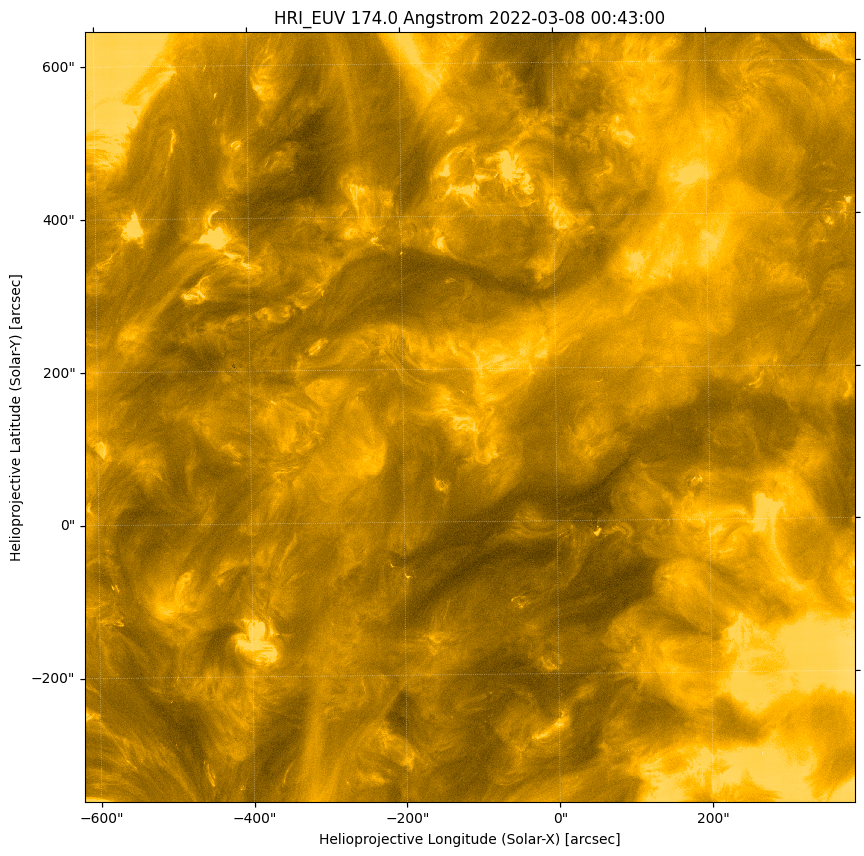

In [49]:
for each_map in eui_seq:

    each_map.plot_settings['norm'] = ImageNormalize(vmin=150, vmax=2000, stretch=SqrtStretch())

plt.figure()

ani = eui_seq.plot()
ani.save('gifs/eui_fullFOV_interval1.gif', fps=20)

### Get IRIS data

In [28]:
eui_seq[0].dsun.to(u.AU) # distance for reference

<Distance 0.48833816 AU>

In [10]:
time_delay = (eui_seq[0].meta['EAR_TDEL']*u.s).to(u.min) # account for time when retrieving other datasets
time_delay

<Quantity 4.1926516 min>

In [11]:
start_time_iris = astropy.time.Time(start_time_eui, format='iso') + time_delay
end_time_iris = astropy.time.Time(end_time_eui, format='iso') + time_delay

In [10]:
time = a.Time(start_time_iris, end_time_iris)

instrument = a.Instrument('IRIS')
wavelength = a.Wavelength(1400*u.angstrom) # SI IV SJI

iris_results = Fido.search(instrument & time & wavelength)
print(iris_results)

Results from 1 Provider:

2 Results from the VSOClient:
Source: https://sdac.virtualsolar.org/cgi/search
Data retrieval status: https://docs.virtualsolar.org/wiki/VSOHealthReport
Total estimated size: 1.51 Gbyte

       Start Time               End Time        Source ... Extent Type  Size 
                                                       ...             Mibyte
----------------------- ----------------------- ------ ... ----------- ------
2022-03-08 00:43:46.000 2022-03-08 03:04:06.000   IRIS ... PARTIAL_SUN 1192.0
2022-03-08 00:43:46.000 2022-03-08 03:04:01.000   IRIS ... PARTIAL_SUN  248.0




In [11]:
iris_files = Fido.fetch(iris_results) # fetch the data
iris_files

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

iris_l2_20220308_004346_3624605437_SJI_1400_t000.fits.gz:   0%|          | 0.00/261M [00:00<?, ?B/s]

iris_l2_20220308_004346_3624605437_raster.tar.gz:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

['/Users/ellisernsberger/sunpy/data/iris_l2_20220308_004346_3624605437_SJI_1400_t000.fits.gz', '/Users/ellisernsberger/sunpy/data/iris_l2_20220308_004346_3624605437_raster.tar.gz']

Find data on local device and move to new folder, with name such as "iris1400_interval1", if desired

In [12]:
sji_file = '/Users/ellisernsberger/sunpy/data/iris1400_interval1/iris_l2_20220308_004346_3624605437_SJI_1400_t000.fits.gz' # interested in SJI 1400, not raster

In [13]:
def get_iris_data(filename):

    # In: filename of IRIS data to read in
    # Out: IRIS observations as array of SunPy maps

    hdul = fits.open(filename)

    header = hdul[0].header    # get header info

    aux = hdul[1].data         # auxillary metadata
    aux_hd = hdul[1].header

    # get timing of observation
    time_diff = aux[:, aux_hd['TIME']]
    times = np.datetime64(header['DATE_OBS']) + time_diff * np.timedelta64(1, 's')

    # loop through and create SunPy maps for each
    iris_map_array = []

    for i in tqdm(range(len(hdul[0].data))):
        one_data = hdul[0].data[i]

        # change 'DATA_OBS' value in header; what SunPy will read as time
        time = times[i]
        header['DATE_OBS'] = str(time)

        iris_map = sunpy.map.Map((one_data, header))
        iris_map_array.append(iris_map)

    return sunpy.map.Map(iris_map_array, sequence=True)

In [14]:
iris_seq = get_iris_data(sji_file)

100%|████████████████████████████████████████████████████████████████████████| 1336/1336 [00:00<00:00, 1569.59it/s]


In [15]:
# use IRIS frame to get initial FOV bounds
iris_ref = iris_seq[0]

# pad corners by 20 arcsec in both directions to prevent clipping when derotating
pad = 20 * u.arcsec

bl = SkyCoord(
    iris_ref.bottom_left_coord.Tx - pad,
    iris_ref.bottom_left_coord.Ty - pad,
    frame=iris_ref.coordinate_frame
)

tr = SkyCoord(
    iris_ref.top_right_coord.Tx + pad,
    iris_ref.top_right_coord.Ty + pad,
    frame=iris_ref.coordinate_frame
)

2025-06-23 14:33:20 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:33:20 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [16]:
# build EUI submaps sequence from padded IRIS FOV
eui_submaps = [m.submap(bottom_left=bl, top_right=tr) for m in eui_seq]
eui_seq_submaps = sunpy.map.Map(eui_submaps, sequence=True)

2025-06-21 14:12:52 - matplotlib.animation - WARNING: MovieWriter ffmpeg unavailable; using Pillow instead.
2025-06-21 14:12:52 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


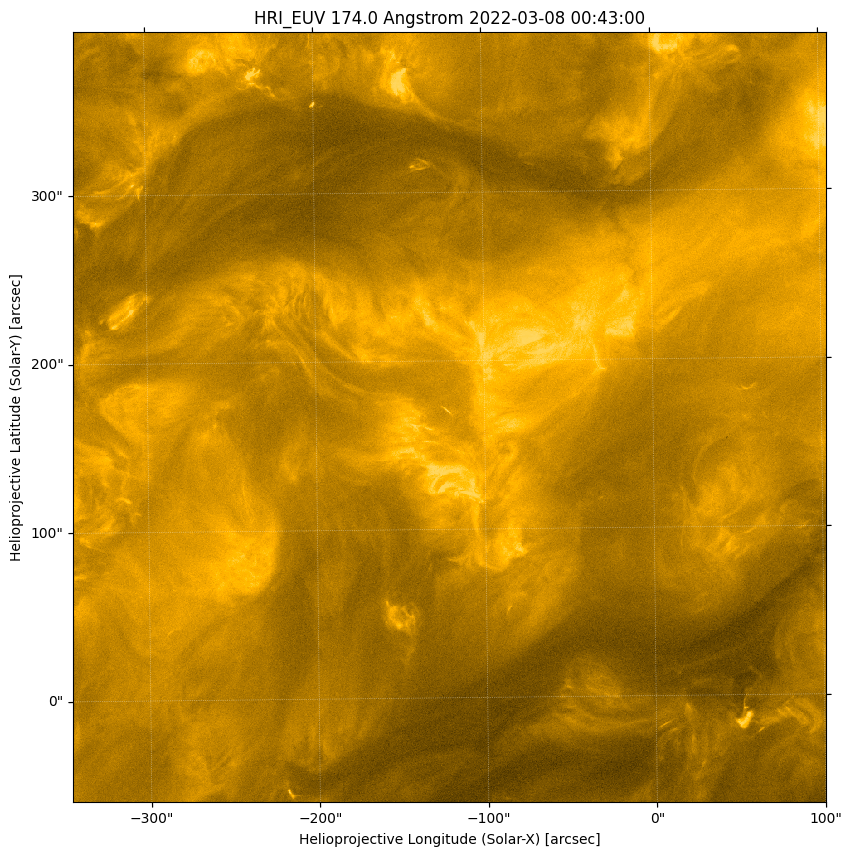

In [51]:
ani = eui_seq_submaps.plot(
    norm=ImageNormalize(vmin=150, vmax=2000, stretch=SqrtStretch())
    )
ani.save('gifs/eui_iris_matchedFOV_interval1.gif', fps=20)

In [17]:
def correct_diff_rot(one_map, ref):

    # In:     one_map = map to be derotated, ref = reference for derotation
    # Out:    out_warp = one_map rotated to ref

    in_time = one_map.date
    out_time = ref.date

    out_frame = sunpy.coordinates.Helioprojective(observer='earth',
                                                  obstime=out_time,
                                                  rsun=one_map.coordinate_frame.rsun)

    out_center = ref.center
    header = sunpy.map.make_fitswcs_header(one_map.data.shape,
                                           out_center,
                                           scale=u.Quantity(one_map.scale))
    out_wcs = astropy.wcs.WCS(header)

    with sunpy.coordinates.propagate_with_solar_surface():
        out_warp = one_map.reproject_to(out_wcs)

    return out_warp

In [18]:
# only rotate region of interest to save computation time
eui_rotated_submaps = []

for one_map in tqdm(eui_seq_submaps[0:]): # skip first one, it will be ref

    new_map = correct_diff_rot(one_map, eui_seq_submaps[0])

    eui_rotated_submaps.append(new_map)

eui_rotated_seq = sunpy.map.Map(eui_rotated_submaps, sequence=True)

2025-06-23 14:33:35 - reproject.common - INFO: Calling _reproject_full in non-dask mode    | 0/360 [00:00<?, ?it/s]
2025-06-23 14:33:35 - reproject.common - INFO: Calling _reproject_full in non-dask mode360 [00:00<01:33,  3.83it/s]
2025-06-23 14:33:35 - reproject.common - INFO: Calling _reproject_full in non-dask mode360 [00:00<02:27,  2.42it/s]
2025-06-23 14:33:36 - reproject.common - INFO: Calling _reproject_full in non-dask mode360 [00:01<02:45,  2.16it/s]
2025-06-23 14:33:37 - reproject.common - INFO: Calling _reproject_full in non-dask mode360 [00:01<02:53,  2.05it/s]
2025-06-23 14:33:37 - reproject.common - INFO: Calling _reproject_full in non-dask mode360 [00:02<02:58,  1.99it/s]
2025-06-23 14:33:38 - reproject.common - INFO: Calling _reproject_full in non-dask mode360 [00:02<03:00,  1.96it/s]
2025-06-23 14:33:38 - reproject.common - INFO: Calling _reproject_full in non-dask mode360 [00:03<03:00,  1.95it/s]
2025-06-23 14:33:39 - reproject.common - INFO: Calling _reproject_full i

2025-06-21 14:05:38 - matplotlib.animation - WARNING: MovieWriter ffmpeg unavailable; using Pillow instead.
2025-06-21 14:05:38 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


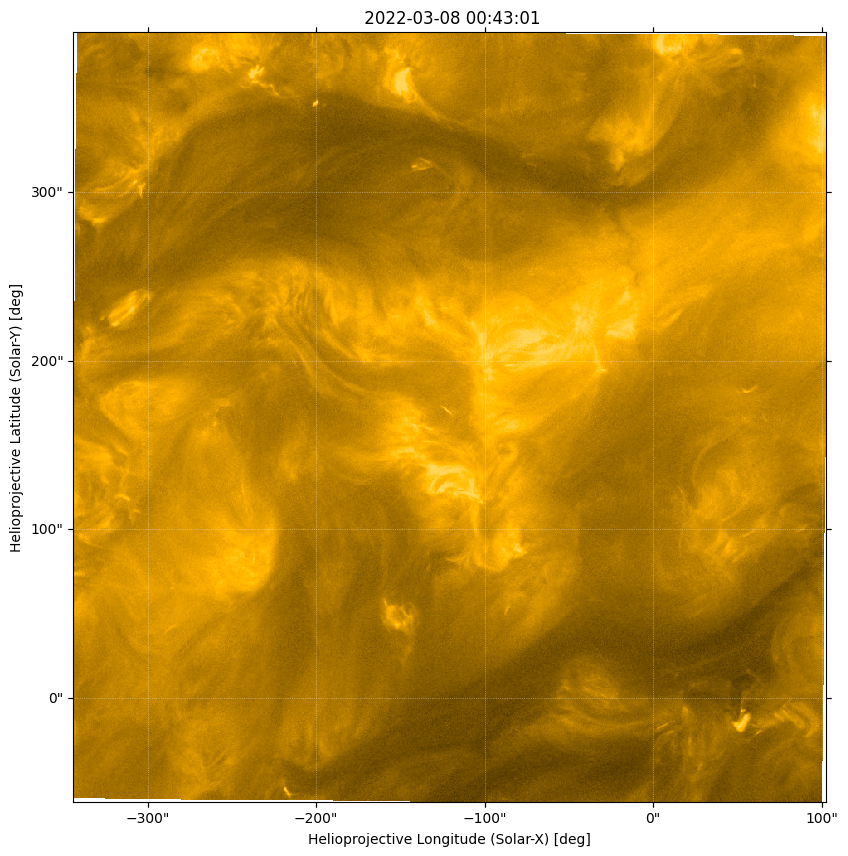

In [46]:
ani = eui_rotated_seq.plot(
    norm=ImageNormalize(vmin=150, vmax=2000, stretch=SqrtStretch())
    )
ani.save('gifs/eui_rotated_and_iris_matchedFOV_interval1.gif', fps=20)

### Choose a region of interest (ROI)

<sunpy.map.mapbase.GenericMap object at 0x11e82a350>
SunPy Map
---------
Observatory:		 
Instrument:		 
Detector:		 
Measurement:		 Unknown
Wavelength:		 Unknown
Observation Date:	 2022-03-08 00:43:01
Exposure Time:		 Unknown
Dimension:		 [255. 255.] pix
Coordinate System:	 helioprojective
Scale:			 [0.00013667 0.00013667] deg / pix
Reference Pixel:	 [-42.5 238. ] pix
Reference Coord:	 [-0.03352908  0.04637921] deg                   
array([[ 546.45031858,  524.50918923,  517.02095225, ...,  535.20597701,
         522.42714044,  554.3007651 ],
       [ 558.87247268,  553.77292465,  553.44210414, ...,  513.4405913 ,
         527.8656763 ,  558.71450394],
       [ 565.1215968 ,  550.81143475,  548.26814893, ...,  514.51630071,
         494.56177888,  490.17748405],
       ...,
       [1193.15251206, 1137.52951324, 1093.36864024, ...,  651.75876698,
         629.28775436,  569.83984021],
       [1206.85489949, 1162.70108931, 1108.11446867, ...,  632.70654866,
         605.34889324,  615.03004215],
       [1213.5564077 , 1234.63137649, 1248.7536295 , ...,  647.531047  ,
         636.58140008,  601.08928075]], shape=(255, 255))
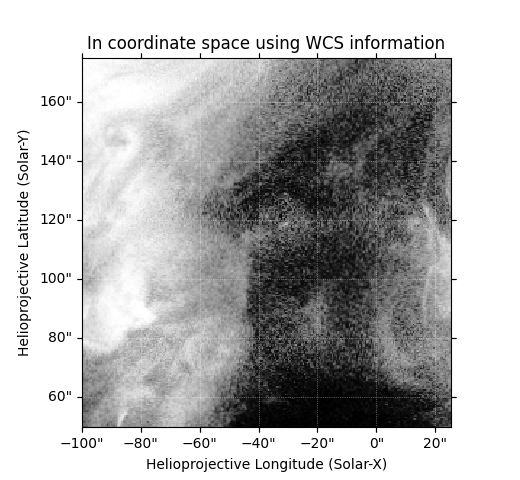
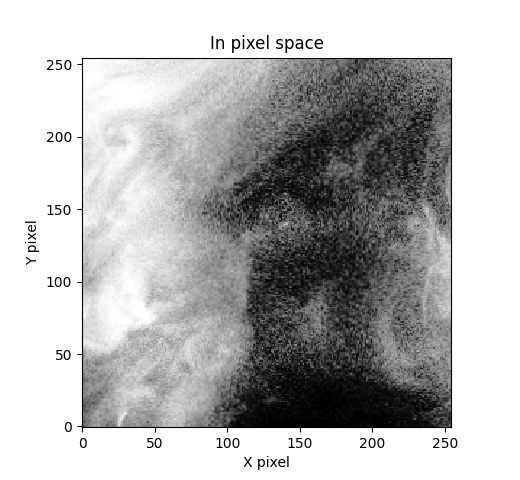
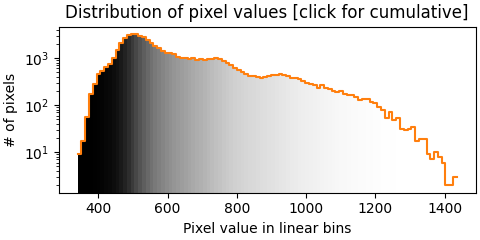
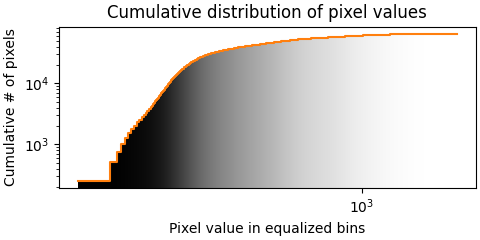

In [19]:
# region of interest
bl_roi_1 = SkyCoord(-100*u.arcsec, 50*u.arcsec, frame=eui_rotated_seq[0].coordinate_frame)
tr_roi_1 = SkyCoord(25*u.arcsec, 175*u.arcsec, frame=eui_rotated_seq[0].coordinate_frame)

# crop each derotated frame to this region
submaps = []
for m in eui_rotated_seq:
    m.plot_settings['norm'] = ImageNormalize(vmin=250, vmax=2000, stretch=SqrtStretch())
    sub = m.submap(bottom_left=bl_roi_1, top_right=tr_roi_1)
    submaps.append(sub)

eui_roi_1_seq = sunpy.map.Map(submaps, sequence=True)

# preview selection
eui_roi_1_seq[0]

2025-06-21 14:05:05 - matplotlib.animation - WARNING: MovieWriter ffmpeg unavailable; using Pillow instead.
2025-06-21 14:05:05 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


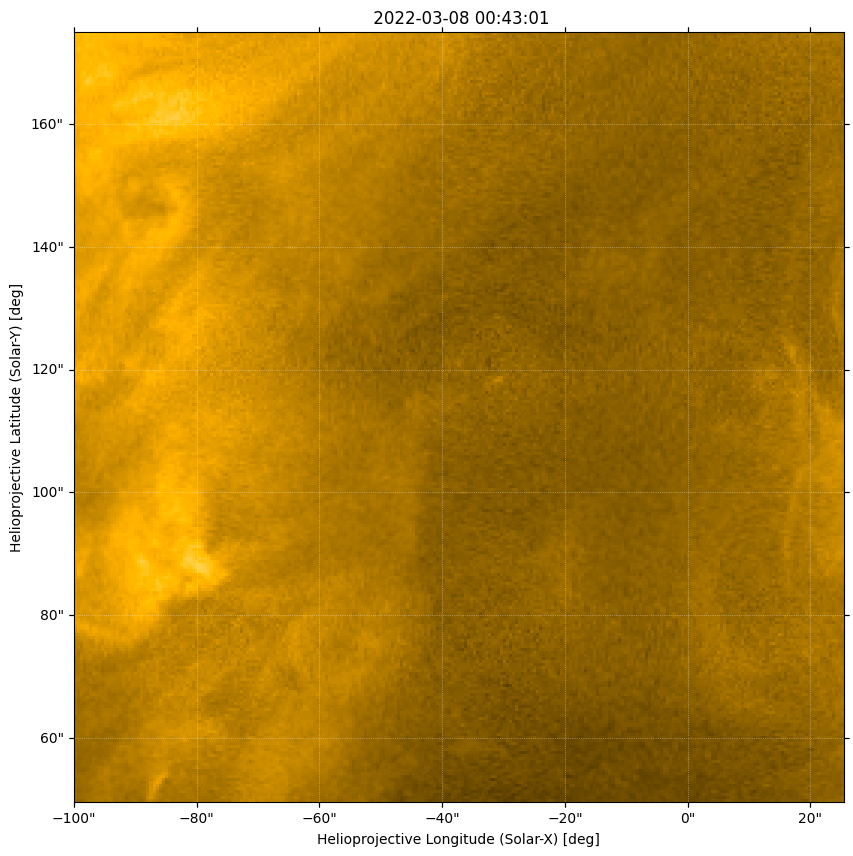

In [45]:
ani = eui_roi_1_seq.plot()
ani.save('gifs/eui_roi_1_interval1.gif', fps=20)

### Reduce jitter using cross-correlation

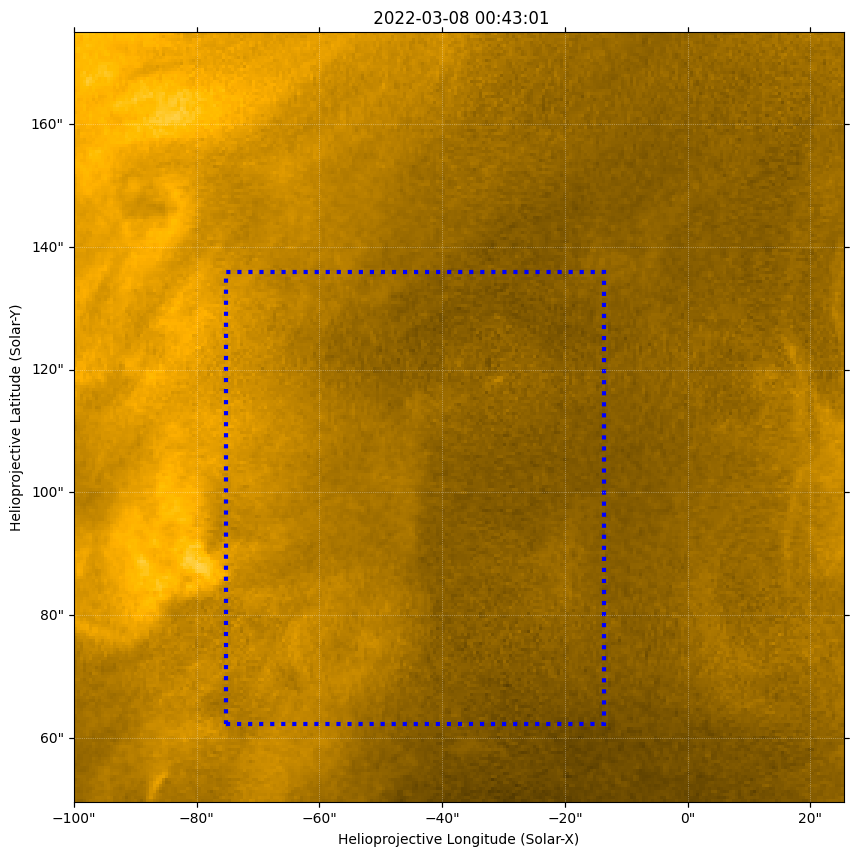

In [20]:
first_map = eui_roi_1_seq[0] # use example frame (e.g. first frame)

fig = plt.figure()
ax = fig.add_subplot(projection=first_map)
first_map.plot(axes=ax)

# cross-correlation region (aim for relatively stable seeming region from movie above)
# use preview graphic from above to decide region to be cross-correlated in pixels
box_xs = [50, 175]
box_ys = [25, 175]

# cc = cross-correlate
bl_cc_roi_1 = first_map.wcs.pixel_to_world(box_xs[0] * u.pixel, box_ys[0] * u.pixel) # bottom left of cross-correlation region
tr_cc_roi_1 = first_map.wcs.pixel_to_world(box_xs[1] * u.pixel, box_ys[1] * u.pixel) # top right of cross-correlation region

first_map.draw_quadrangle(bottom_left=bl_cc_roi_1, axes=ax, top_right=tr_cc_roi_1, edgecolor="blue", linestyle=":", linewidth=3)

In [21]:
# build shifts and filter by a certain threshold value to remove outlier spikes
shifts_rel = []
for i in range(len(eui_roi_1_seq)):
    if i == 0:
        shifts_rel.append([0.0, 0.0])
    else:
        img1 = eui_roi_1_seq[i-1].data[box_ys[0]:box_ys[1],
                                       box_xs[0]:box_xs[1]]
        img2 = eui_roi_1_seq[i].data[  box_ys[0]:box_ys[1],
                                       box_xs[0]:box_xs[1]]
        shift, error, _ = skimage.registration.phase_cross_correlation(
            img1, img2, upsample_factor=100,
            reference_mask=~np.isnan(img1),
            moving_mask=~np.isnan(img2)
        )
        # threshold in pixels
        if abs(shift[0]) > 1 or abs(shift[1]) > 1:
            shift = np.array([0.0, 0.0])
        shifts_rel.append(shift)

shifts_rel = np.array(shifts_rel)

# smooth using convolve (adjust kernel size/window as needed)
kernel = np.ones(3) / 5
y_smooth = np.convolve(shifts_rel[:,0], kernel, mode='same')
x_smooth = np.convolve(shifts_rel[:,1], kernel, mode='same')
shifts_smooth = np.vstack([y_smooth, x_smooth]).T

# cumulative shifts, no shift for ref
zero = np.zeros((1,2))
cum = np.vstack([zero, np.cumsum(shifts_smooth[1:], axis=0)])

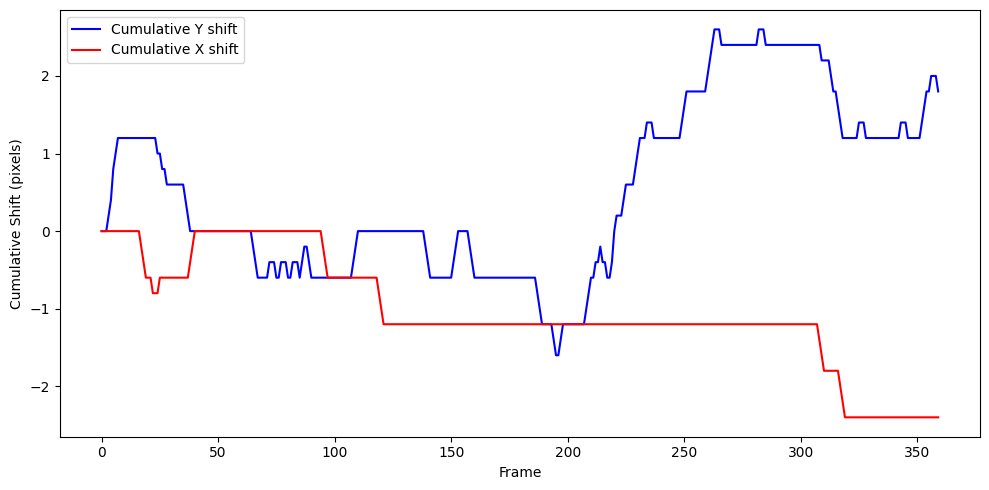

In [20]:
y_sum = cum[:, 0]
x_sum = cum[:, 1]

plt.figure(figsize=(10, 5))
plt.plot(y_sum, color='blue', label='Cumulative Y shift')
plt.plot(x_sum, color='red',  label='Cumulative X shift')
plt.xlabel('Frame')
plt.ylabel('Cumulative Shift (pixels)')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# sub-pixel shifts using fast-fourier
def apply_shift(img, shift, cmap, norm):

    data = img.data

    data[np.isnan(data)] = 0

    shift_img = scipy.ndimage.fourier_shift(np.fft.fftn(data), shift) # fast-fourier
    shift_img = np.fft.ifftn(shift_img).real # keep real

    # fill in with zeros where necessary and round to integer
    y, x = shift
    if y > 0:
        shift_img[:int(y+1), :] = 0
    else:
        shift_img[int(y-1):, :] = 0

    if x > 0:
        shift_img[:, :int(x+1)] = 0
    else:
        shift_img[:, int(x-1):] = 0

    shift_map = sunpy.map.Map((shift_img, img.meta))

    # color and normalize
    shift_map.plot_settings['cmap'] = cmap
    shift_map.plot_settings['norm'] = norm

    return shift_map

# apply shift
stable_maps = []
for m, offset in zip(eui_roi_1_seq, cum):
    stable_maps.append(
        apply_shift(
            m,
            -offset,
            cmap='solar orbiterhri_euv174',
            norm=ImageNormalize(vmin=250, vmax=2000, stretch=SqrtStretch())
        )
    )

eui_stable_roi_1_seq = sunpy.map.Map(stable_maps, sequence=True)

2025-06-21 14:27:15 - matplotlib.animation - WARNING: MovieWriter ffmpeg unavailable; using Pillow instead.
2025-06-21 14:27:15 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


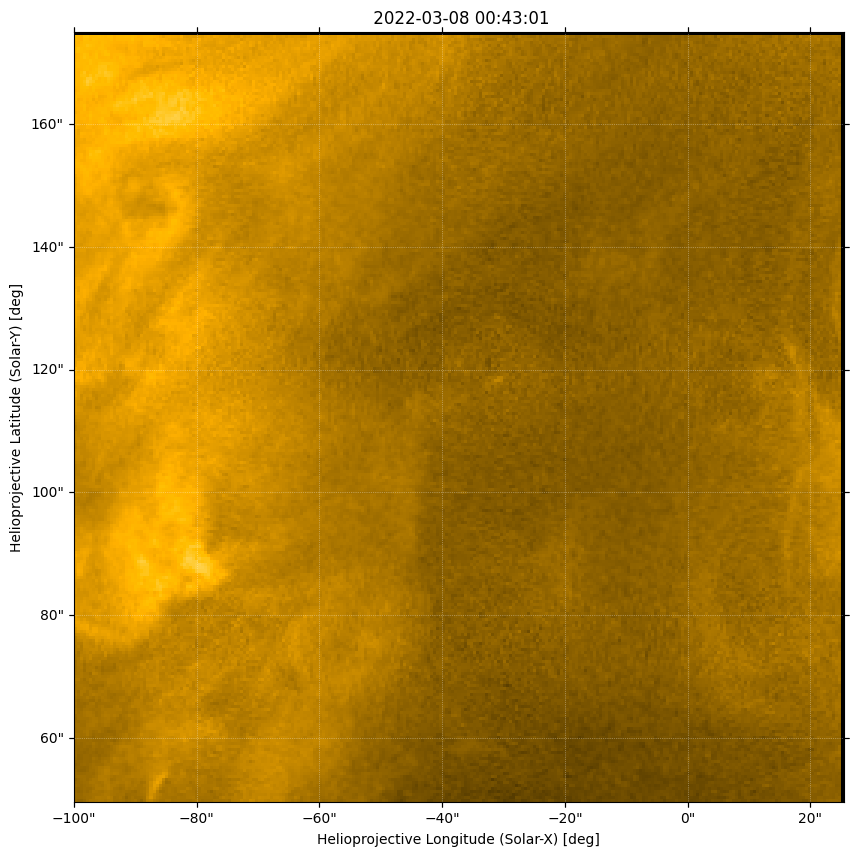

In [70]:
ani = eui_stable_roi_1_seq.plot()
ani.save('gifs/eui_stable_roi_1.gif', fps=20)

### Retrieve AIA 171

In [26]:
start_time_aia171 = astropy.time.Time('2022-03-08 00:43:00', format='iso') + time_delay
end_time_aia171 = astropy.time.Time('2022-03-08 01:13:00', format='iso') + time_delay

In [24]:
time = a.Time(start_time_aia171, end_time_aia171)

instrument = a.Instrument('AIA')
wavelength = a.Wavelength(171*u.angstrom)

aia171_result = Fido.search(instrument & time & wavelength)
print(aia171_result)

Results from 1 Provider:

281 Results from the VSOClient:
Source: https://sdac.virtualsolar.org/cgi/search
Data retrieval status: https://docs.virtualsolar.org/wiki/VSOHealthReport
Total estimated size: 19.049 Gbyte

       Start Time               End Time        Source ... Extent Type   Size  
                                                       ...              Mibyte 
----------------------- ----------------------- ------ ... ----------- --------
2022-03-08 00:47:15.000 2022-03-08 00:47:16.000    SDO ...    FULLDISK 64.64844
2022-03-08 00:47:21.000 2022-03-08 00:47:22.000    SDO ...    FULLDISK 64.64844
2022-03-08 00:47:27.000 2022-03-08 00:47:28.000    SDO ...    FULLDISK 64.64844
2022-03-08 00:47:33.000 2022-03-08 00:47:34.000    SDO ...    FULLDISK 64.64844
2022-03-08 00:47:39.000 2022-03-08 00:47:40.000    SDO ...    FULLDISK 64.64844
2022-03-08 00:47:45.000 2022-03-08 00:47:46.000    SDO ...    FULLDISK 64.64844
2022-03-08 00:47:51.000 2022-03-08 00:47:52.000    SDO ...    F

### Do not run cell below if already downloaded

In [72]:
aia171_files = Fido.fetch(aia171_result)
aia171_seq = sunpy.map.Map(aia171_files, sequence=True)

Files Downloaded:   0%|          | 0/281 [00:00<?, ?file/s]

aia.lev1.171A_2022_03_08T00_47_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_47_33.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_47_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_47_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_47_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_47_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_47_57.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_47_51.33Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_48_09.35Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_48_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_48_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_48_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_48_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_48_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_48_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_48_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_48_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_49_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_49_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_49_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_49_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_49_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_49_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_49_45.35Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_49_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_49_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_50_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_50_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_50_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_50_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_50_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_50_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_50_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_50_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_50_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_50_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_51_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_51_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_51_21.35Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_51_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_51_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_51_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_51_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_51_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_51_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_52_03.33Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_52_09.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_52_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_52_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_52_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_52_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_52_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_52_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_52_57.35Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_53_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_53_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_53_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_53_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_53_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_53_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_53_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_53_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_53_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_54_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_53_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_54_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_54_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_54_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_54_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_54_33.34Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_54_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_54_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_54_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_55_03.33Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_55_09.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_55_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_55_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_55_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_55_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_55_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_55_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_55_51.33Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_55_57.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_56_09.35Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_56_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_56_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_56_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_56_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_56_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_56_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_56_51.33Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_56_57.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_57_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_57_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_57_15.33Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_57_21.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_57_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_57_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_57_45.35Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_57_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_57_57.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_58_03.34Z.image_lev1.fits:   0%|          | 0.00/8.59M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_58_09.35Z.image_lev1.fits:   0%|          | 0.00/8.59M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_58_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_58_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_58_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_58_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_58_39.35Z.image_lev1.fits:   0%|          | 0.00/8.59M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_58_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_58_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_58_57.35Z.image_lev1.fits:   0%|          | 0.00/8.59M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_59_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_59_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_59_21.35Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_59_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_59_33.35Z.image_lev1.fits:   0%|          | 0.00/8.59M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_59_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_59_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_59_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T00_59_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_00_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_00_09.35Z.image_lev1.fits:   0%|          | 0.00/8.59M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_00_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_00_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_00_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_00_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_00_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_00_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_00_57.35Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_01_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_01_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_01_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_01_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_01_27.33Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_01_33.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_01_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_01_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_01_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_01_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_02_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_02_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_02_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_02_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_02_33.34Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_02_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_02_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_02_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_02_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_03_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_03_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_03_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_03_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_03_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_03_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_03_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_03_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_03_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_04_09.35Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_03_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_04_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_04_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_04_27.33Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_04_33.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_04_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_04_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_04_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_04_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_05_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_05_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_05_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_05_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_05_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_05_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_05_45.35Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_05_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_06_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_05_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_06_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_06_15.33Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_06_21.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_06_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_06_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_06_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_06_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_06_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_06_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_07_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_07_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_07_21.34Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_07_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_07_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_07_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_07_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_07_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_07_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_08_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_08_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_08_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_08_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_08_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_08_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_08_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_08_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_08_57.34Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_09_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_09_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_09_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_09_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_09_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_09_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_09_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_09_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_09_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_09_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_10_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_10_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_10_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_10_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_10_33.35Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_10_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_10_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_10_51.33Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_10_57.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_11_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_11_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_11_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_11_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_11_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_11_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_11_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_11_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_11_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_11_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_12_09.35Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_12_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_12_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_12_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_12_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_12_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_12_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_12_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_12_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_13_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_13_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_13_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_13_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_13_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_13_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_13_45.34Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_13_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_13_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_14_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_14_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_14_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_14_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_14_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_14_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_14_39.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_14_45.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_14_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_14_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_15_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_15_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_15_21.34Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_15_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_15_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_15_45.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_15_39.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_15_51.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_15_57.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_16_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_16_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_16_15.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_16_21.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_16_27.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_16_39.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_16_33.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_16_45.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_16_57.35Z.image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_17_03.34Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

aia.lev1.171A_2022_03_08T01_17_09.35Z.image_lev1.fits:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

In [27]:
# loading sequence from local device if already saved
data_dir_aia171 = '/Users/ellisernsberger/sunpy/data/aia171_interval1'
aia171_file_list = sorted(glob.glob(os.path.join(data_dir_aia171, 'aia.lev1.171A*.fits')))

# create map Sequence from local files
aia171_seq = sunpy.map.Map(aia171_file_list, sequence=True)

### Align AIA 171 in time with EUI 174

In [28]:
matched_aia_maps = []

for one_map in eui_seq: # for each map EUI seq

    eui_map = one_map # map with time to match

    wanted_time = astropy.time.Time(eui_map.date, format='iso') # want EUI time

    # add time delay
    times = [abs(astropy.time.Time(aia_map.date, format='iso') - time_delay - wanted_time) for aia_map in aia171_seq]

    # index of map that is closest in time
    closest_i = np.argmin(times)

    # aia map that is closest in time
    match_aia = aia171_seq[closest_i]

    matched_aia_maps.append(match_aia)

matched_aia_seq = sunpy.map.Map(matched_aia_maps, sequence=True)

### Derotate and Reproject AIA 171

In [29]:
# matched AIA maps in their native coords
matched = matched_aia_seq

# get WCS and shape from EUI ROI ref
ref_eui = eui_roi_1_seq[0]
target_wcs   = ref_eui.wcs
output_shape = ref_eui.data.shape

# derotated then reproject
aia_derotated = []
with propagate_with_solar_surface():  
    for m in matched:
        derot = m.reproject_to(target_wcs, shape_out=output_shape)
        derot.plot_settings['norm'] = ImageNormalize(vmin=20,
                                                     vmax=1000,
                                                     stretch=SqrtStretch())
        derot.plot_settings['cmap'] = 'sdoaia171'
        aia_derotated.append(derot)

aia171_derotated_seq = sunpy.map.Map(aia_derotated, sequence=True)

2025-06-23 14:39:10 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:39:10 - sunpy - WARNING: SunpyUserWarning: rsun mismatch detected: AIA 171.0 Angstrom 2022-03-08 00:47:15.rsun_meters=696000000.0 m;  2022-03-08 00:43:01.rsun_meters=695700000.0 m. This might cause unexpected results during reprojection.
2025-06-23 14:39:10 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:39:10 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:39:10 - sunpy - WARNING: SunpyUserWarning: rsun mismatch detected: AIA 171.0 Angstrom 2022-03-08 00:47:21.rsun_meters=696000000.0 m;  2022-03-08 00:43:01.rsun_meters=695700000.0 m. This might cause unexpected results during reprojection.
2025-06-23 14:39:10 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:39:10 - sunpy - WARNING: SunpyUserWarning: rsun mismatch detected: AIA 171.0 Angstrom 2022-03-08 00:47:27.rsun_meters=696000000.0 

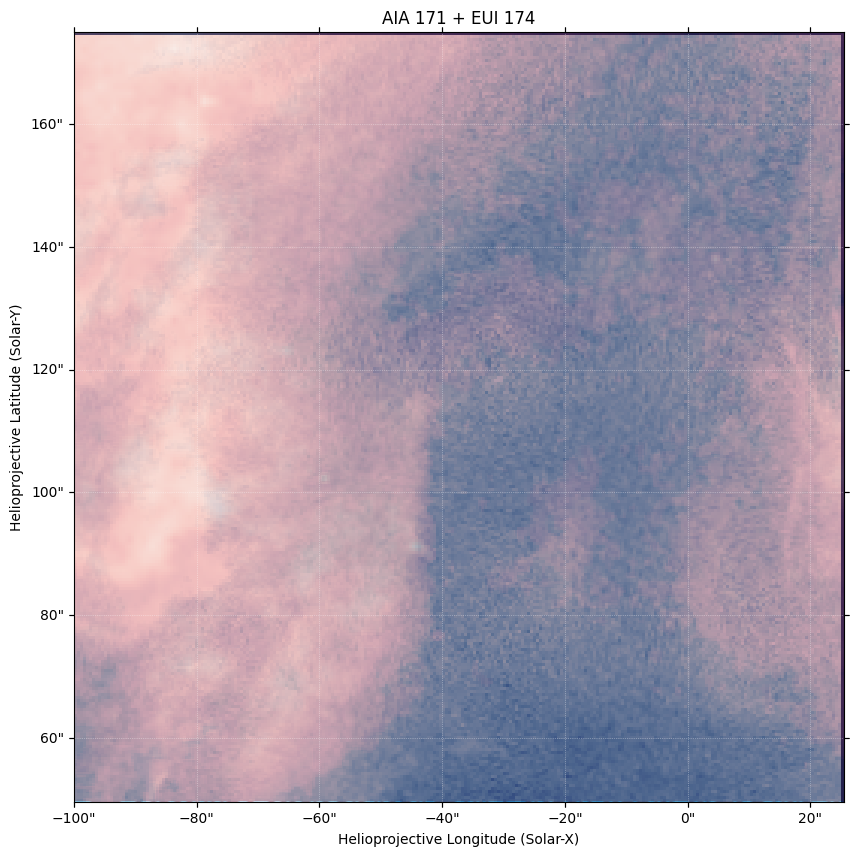

In [28]:
i = 0

aia_map = aia171_derotated_seq[i]
eui_map = eui_stable_roi_1_seq[i]

aia_norm = ImageNormalize(aia_map.data, vmin=80, vmax=500, stretch=SqrtStretch())
eui_norm = ImageNormalize(eui_map.data, vmin=300, vmax=1000, stretch=SqrtStretch())

fig = plt.figure()
ax = fig.add_subplot(111, projection=aia_map)

aia_overlay = aia_map.plot(axes=ax, norm=aia_norm, alpha=0.3, cmap='Reds_r', autoalign=True)
eui_overlay = eui_map.plot(axes=ax, norm=eui_norm, alpha=1, cmap='Blues_r')
ax.set_title('AIA 171 + EUI 174')

plt.show()

### Smooth shifts using Taylor approximation

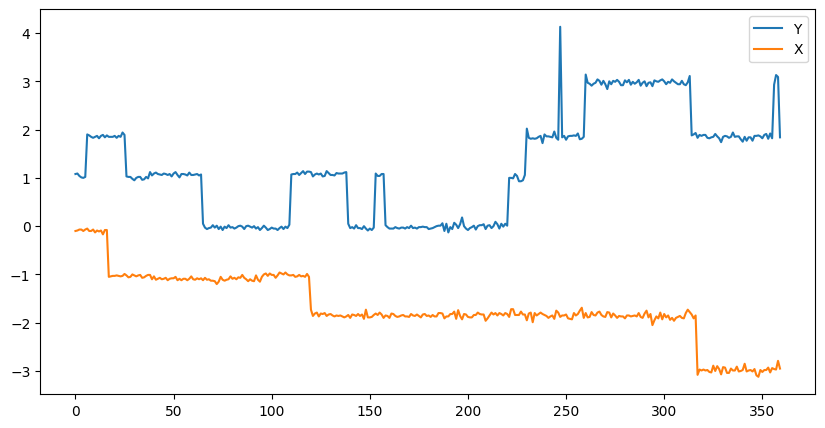

In [30]:
shifts = []

for i in range(len(eui_stable_roi_1_seq)): # on derotated aia seq
    
    aia_map = aia171_derotated_seq[i]
    eui_map = eui_stable_roi_1_seq[i]

    img1 = aia_map.data # ref
    img2 = eui_map.data # moving
    
    # sub-pixel cross-correlation
    shift, error, phasediff = skimage.registration.phase_cross_correlation(img1, # ref
                                                                           img2, # moving
                                                                           upsample_factor=100)
    shifts.append(shift)

plt.figure(figsize=(10,5))
plt.plot(shifts, label=['Y', 'X'])
plt.legend()

In [31]:
raw_shifts = np.array(shifts)

# choose window length and order of polynomial
smooth_shift = savgol_filter(raw_shifts, window_length=7, polyorder=2, axis=0)

# dampening/amplifying the amplitude (if necessary)
alpha = 0.5
damped_shift = smooth_shift * alpha

# manual shift to add (noticed overall shift that was consistent throughout the frames)
manual_offset = np.array([+20, +2])   # move all frames [y = +20, x = +2] pixels

aligned = []
for eui_map, s in zip(eui_stable_roi_1_seq, damped_shift):
    total_shift = s + manual_offset
    m = apply_shift(
        eui_map,
        total_shift,
        cmap='solar orbiterhri_euv174',
        norm=ImageNormalize(vmin=0, vmax=13000, stretch=SqrtStretch())
    )
    aligned.append(m)

eui_shifted_seq = sunpy.map.Map(aligned, sequence=True)

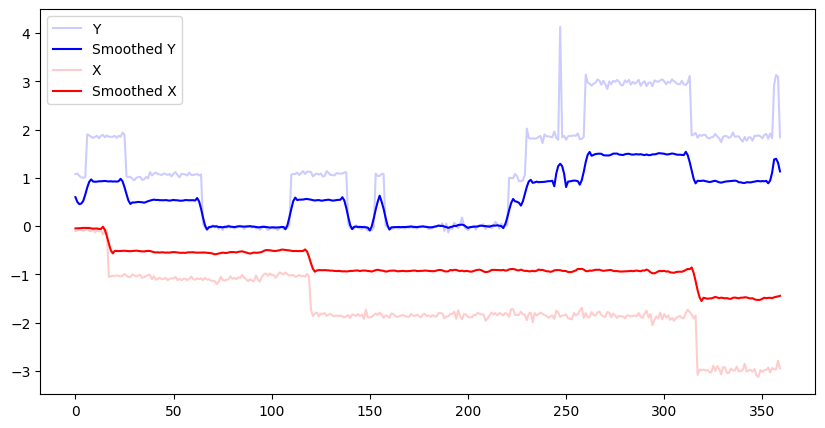

In [127]:
# shows difference from last plot if applying dampening and Taylor approximation 
plt.figure(figsize=(10,5))
taylor = np.arange(len(raw_shifts))
plt.plot(taylor, raw_shifts[:,0], alpha=0.2, label='Y', color="Blue")
plt.plot(taylor, damped_shift[:,0], label='Smoothed Y', color="Blue")
plt.plot(taylor, raw_shifts[:,1], alpha=0.2, label='X', color="Red")
plt.plot(taylor, damped_shift[:,1], label='Smoothed X', color="Red")
plt.legend()
plt.show()

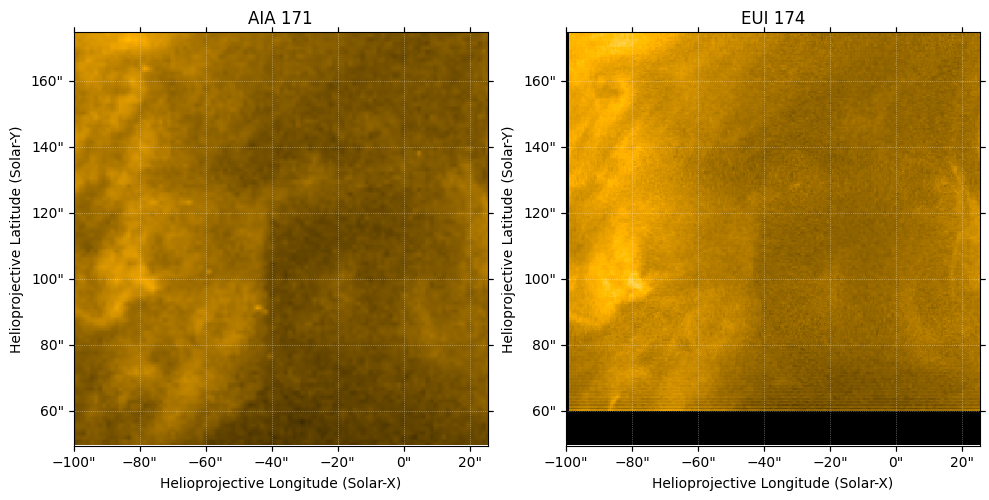

In [32]:
i = 0

aia_map = aia171_derotated_seq[i]
eui_map = eui_shifted_seq[i]

aia_norm = ImageNormalize(vmin=20,  vmax=600, stretch=SqrtStretch())
eui_norm = ImageNormalize(vmin=200, vmax=2000, stretch=SqrtStretch())

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(121, projection=aia_map)
aia_map.plot(axes=ax, norm=aia_norm, title='AIA 171')

ax = fig.add_subplot(122, projection=eui_map)
eui_map.plot(axes=ax, norm=eui_norm, title='EUI 174')

plt.tight_layout()

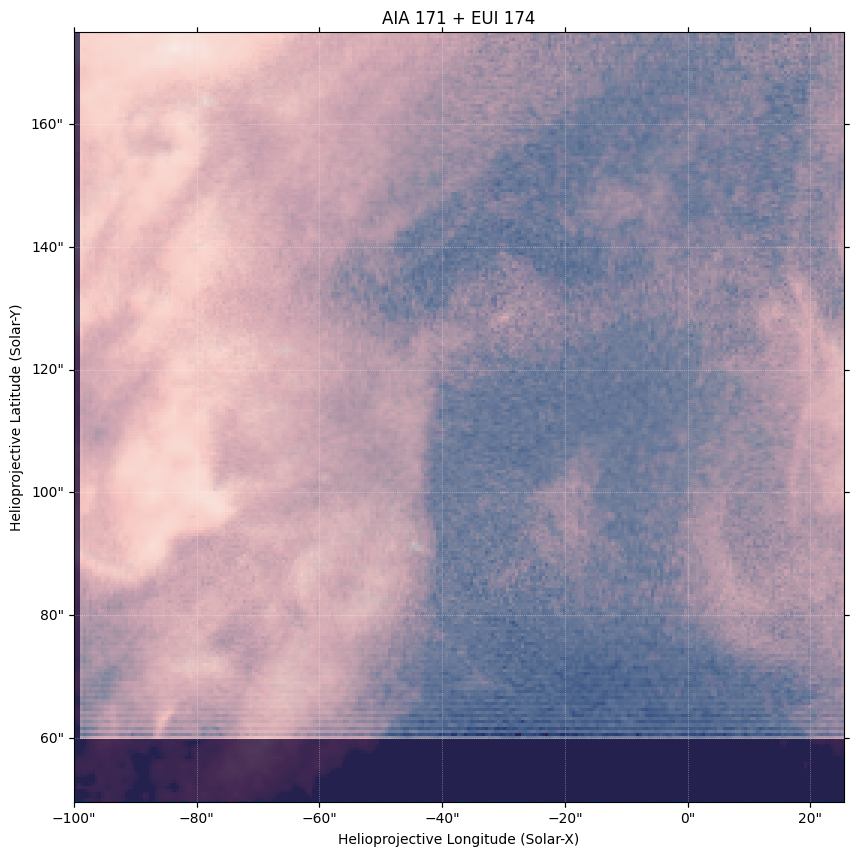

In [33]:
# check alignment
i = 0

aia_norm = ImageNormalize(aia_map.data, vmin=80, vmax=500, stretch=SqrtStretch())
eui_norm = ImageNormalize(eui_map.data, vmin=300, vmax=1000, stretch=SqrtStretch())

fig = plt.figure()
ax = fig.add_subplot(111, projection=aia_map)

aia_overlay = aia171_derotated_seq[i].plot(axes=ax, norm=aia_norm, alpha=0.3, cmap='Reds_r', autoalign=True)
eui_overlay = eui_shifted_seq[i].plot(axes=ax, norm=eui_norm, alpha=1, cmap='Blues_r')
ax.set_title('AIA 171 + EUI 174')

plt.show()

  0%|                                                                                      | 0/360 [00:00<?, ?it/s]

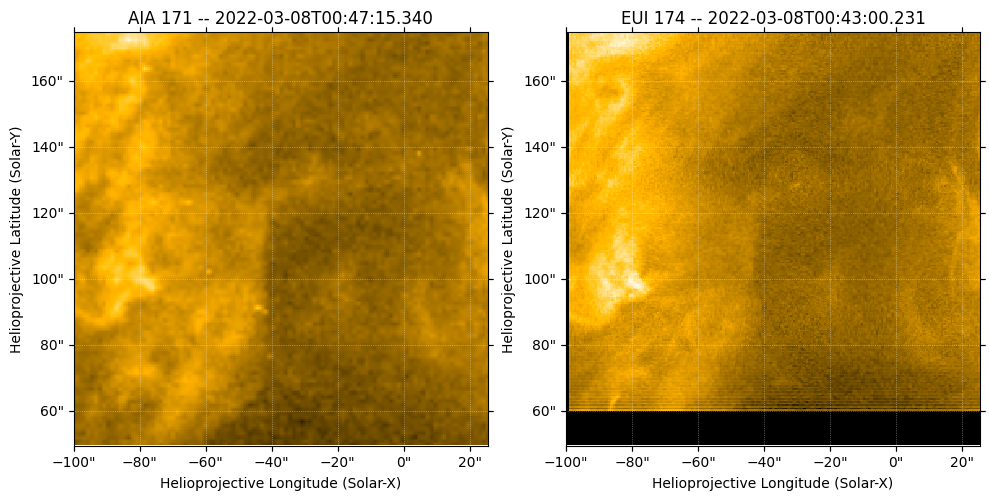

  0%|▏                                                                             | 1/360 [00:00<02:47,  2.14it/s]

<Figure size 1000x1000 with 0 Axes>

  1%|▍                                                                             | 2/360 [00:00<01:47,  3.35it/s]

<Figure size 1000x1000 with 0 Axes>

  1%|▋                                                                             | 3/360 [00:00<01:26,  4.13it/s]

<Figure size 1000x1000 with 0 Axes>

  1%|▊                                                                             | 4/360 [00:01<01:17,  4.61it/s]

<Figure size 1000x1000 with 0 Axes>

  1%|█                                                                             | 5/360 [00:01<01:12,  4.92it/s]

<Figure size 1000x1000 with 0 Axes>

  2%|█▎                                                                            | 6/360 [00:01<01:09,  5.12it/s]

<Figure size 1000x1000 with 0 Axes>

  2%|█▌                                                                            | 7/360 [00:01<01:07,  5.24it/s]

<Figure size 1000x1000 with 0 Axes>

  2%|█▋                                                                            | 8/360 [00:01<01:07,  5.24it/s]

<Figure size 1000x1000 with 0 Axes>

  2%|█▉                                                                            | 9/360 [00:01<01:06,  5.29it/s]

<Figure size 1000x1000 with 0 Axes>

  3%|██▏                                                                          | 10/360 [00:02<01:06,  5.25it/s]

<Figure size 1000x1000 with 0 Axes>

  3%|██▎                                                                          | 11/360 [00:02<01:06,  5.22it/s]

<Figure size 1000x1000 with 0 Axes>

  3%|██▌                                                                          | 12/360 [00:02<01:07,  5.13it/s]

<Figure size 1000x1000 with 0 Axes>

  4%|██▊                                                                          | 13/360 [00:02<01:08,  5.09it/s]

<Figure size 1000x1000 with 0 Axes>

  4%|██▉                                                                          | 14/360 [00:02<01:08,  5.07it/s]

<Figure size 1000x1000 with 0 Axes>

  4%|███▏                                                                         | 15/360 [00:03<01:07,  5.09it/s]

<Figure size 1000x1000 with 0 Axes>

  4%|███▍                                                                         | 16/360 [00:03<01:07,  5.07it/s]

<Figure size 1000x1000 with 0 Axes>

  5%|███▋                                                                         | 17/360 [00:03<01:07,  5.06it/s]

<Figure size 1000x1000 with 0 Axes>

  5%|███▊                                                                         | 18/360 [00:03<01:15,  4.55it/s]

<Figure size 1000x1000 with 0 Axes>

  5%|████                                                                         | 19/360 [00:03<01:13,  4.63it/s]

<Figure size 1000x1000 with 0 Axes>

  6%|████▎                                                                        | 20/360 [00:04<01:12,  4.67it/s]

<Figure size 1000x1000 with 0 Axes>

  6%|████▍                                                                        | 21/360 [00:04<01:11,  4.74it/s]

<Figure size 1000x1000 with 0 Axes>

  6%|████▋                                                                        | 22/360 [00:04<01:10,  4.77it/s]

<Figure size 1000x1000 with 0 Axes>

  6%|████▉                                                                        | 23/360 [00:04<01:10,  4.77it/s]

<Figure size 1000x1000 with 0 Axes>

  7%|█████▏                                                                       | 24/360 [00:05<01:10,  4.79it/s]

<Figure size 1000x1000 with 0 Axes>

  7%|█████▎                                                                       | 25/360 [00:05<01:10,  4.75it/s]

<Figure size 1000x1000 with 0 Axes>

  7%|█████▌                                                                       | 26/360 [00:05<01:10,  4.72it/s]

<Figure size 1000x1000 with 0 Axes>

  8%|█████▊                                                                       | 27/360 [00:05<01:10,  4.72it/s]

<Figure size 1000x1000 with 0 Axes>

  8%|█████▉                                                                       | 28/360 [00:05<01:10,  4.69it/s]

<Figure size 1000x1000 with 0 Axes>

  8%|██████▏                                                                      | 29/360 [00:06<01:10,  4.67it/s]

<Figure size 1000x1000 with 0 Axes>

  8%|██████▍                                                                      | 30/360 [00:06<01:11,  4.64it/s]

<Figure size 1000x1000 with 0 Axes>

  9%|██████▋                                                                      | 31/360 [00:06<01:11,  4.60it/s]

<Figure size 1000x1000 with 0 Axes>

  9%|██████▊                                                                      | 32/360 [00:06<01:12,  4.54it/s]

<Figure size 1000x1000 with 0 Axes>

  9%|███████                                                                      | 33/360 [00:06<01:12,  4.53it/s]

<Figure size 1000x1000 with 0 Axes>

  9%|███████▎                                                                     | 34/360 [00:07<01:11,  4.54it/s]

<Figure size 1000x1000 with 0 Axes>

 10%|███████▍                                                                     | 35/360 [00:07<01:11,  4.52it/s]

<Figure size 1000x1000 with 0 Axes>

 10%|███████▋                                                                     | 36/360 [00:07<01:11,  4.51it/s]

<Figure size 1000x1000 with 0 Axes>

 10%|███████▉                                                                     | 37/360 [00:07<01:11,  4.50it/s]

<Figure size 1000x1000 with 0 Axes>

 11%|████████▏                                                                    | 38/360 [00:08<01:11,  4.48it/s]

<Figure size 1000x1000 with 0 Axes>

 11%|████████▎                                                                    | 39/360 [00:08<01:11,  4.47it/s]

<Figure size 1000x1000 with 0 Axes>

 11%|████████▌                                                                    | 40/360 [00:08<01:13,  4.37it/s]

<Figure size 1000x1000 with 0 Axes>

 11%|████████▊                                                                    | 41/360 [00:08<01:13,  4.34it/s]

<Figure size 1000x1000 with 0 Axes>

 12%|████████▉                                                                    | 42/360 [00:09<01:13,  4.34it/s]

<Figure size 1000x1000 with 0 Axes>

 12%|█████████▏                                                                   | 43/360 [00:09<01:12,  4.34it/s]

<Figure size 1000x1000 with 0 Axes>

 12%|█████████▍                                                                   | 44/360 [00:09<01:12,  4.34it/s]

<Figure size 1000x1000 with 0 Axes>

 12%|█████████▋                                                                   | 45/360 [00:09<01:13,  4.31it/s]

<Figure size 1000x1000 with 0 Axes>

 13%|█████████▊                                                                   | 46/360 [00:09<01:13,  4.29it/s]

<Figure size 1000x1000 with 0 Axes>

 13%|██████████                                                                   | 47/360 [00:10<01:13,  4.27it/s]

<Figure size 1000x1000 with 0 Axes>

 13%|██████████▎                                                                  | 48/360 [00:10<01:13,  4.26it/s]

<Figure size 1000x1000 with 0 Axes>

 14%|██████████▍                                                                  | 49/360 [00:10<01:13,  4.24it/s]

<Figure size 1000x1000 with 0 Axes>

 14%|██████████▋                                                                  | 50/360 [00:10<01:14,  4.17it/s]

<Figure size 1000x1000 with 0 Axes>

 14%|██████████▉                                                                  | 51/360 [00:11<01:14,  4.16it/s]

<Figure size 1000x1000 with 0 Axes>

 14%|███████████                                                                  | 52/360 [00:11<01:14,  4.15it/s]

<Figure size 1000x1000 with 0 Axes>

 15%|███████████▎                                                                 | 53/360 [00:11<01:14,  4.12it/s]

<Figure size 1000x1000 with 0 Axes>

 15%|███████████▌                                                                 | 54/360 [00:11<01:20,  3.80it/s]

<Figure size 1000x1000 with 0 Axes>

 15%|███████████▊                                                                 | 55/360 [00:12<01:19,  3.86it/s]

<Figure size 1000x1000 with 0 Axes>

 16%|███████████▉                                                                 | 56/360 [00:12<01:17,  3.91it/s]

<Figure size 1000x1000 with 0 Axes>

 16%|████████████▏                                                                | 57/360 [00:12<01:22,  3.69it/s]

<Figure size 1000x1000 with 0 Axes>

 16%|████████████▍                                                                | 58/360 [00:13<01:19,  3.78it/s]

<Figure size 1000x1000 with 0 Axes>

 16%|████████████▌                                                                | 59/360 [00:13<01:18,  3.83it/s]

<Figure size 1000x1000 with 0 Axes>

 17%|████████████▊                                                                | 60/360 [00:13<01:17,  3.86it/s]

<Figure size 1000x1000 with 0 Axes>

 17%|█████████████                                                                | 61/360 [00:13<01:16,  3.89it/s]

<Figure size 1000x1000 with 0 Axes>

 17%|█████████████▎                                                               | 62/360 [00:14<01:16,  3.88it/s]

<Figure size 1000x1000 with 0 Axes>

 18%|█████████████▍                                                               | 63/360 [00:14<01:16,  3.89it/s]

<Figure size 1000x1000 with 0 Axes>

 18%|█████████████▋                                                               | 64/360 [00:14<01:16,  3.89it/s]

<Figure size 1000x1000 with 0 Axes>

 18%|█████████████▉                                                               | 65/360 [00:14<01:16,  3.88it/s]

<Figure size 1000x1000 with 0 Axes>

 18%|██████████████                                                               | 66/360 [00:15<01:16,  3.86it/s]

<Figure size 1000x1000 with 0 Axes>

 19%|██████████████▎                                                              | 67/360 [00:15<01:16,  3.85it/s]

<Figure size 1000x1000 with 0 Axes>

 19%|██████████████▌                                                              | 68/360 [00:15<01:15,  3.84it/s]

<Figure size 1000x1000 with 0 Axes>

 19%|██████████████▊                                                              | 69/360 [00:15<01:16,  3.81it/s]

<Figure size 1000x1000 with 0 Axes>

 19%|██████████████▉                                                              | 70/360 [00:16<01:16,  3.80it/s]

<Figure size 1000x1000 with 0 Axes>

 20%|███████████████▏                                                             | 71/360 [00:16<01:16,  3.77it/s]

<Figure size 1000x1000 with 0 Axes>

 20%|███████████████▍                                                             | 72/360 [00:16<01:17,  3.74it/s]

<Figure size 1000x1000 with 0 Axes>

 20%|███████████████▌                                                             | 73/360 [00:16<01:16,  3.73it/s]

<Figure size 1000x1000 with 0 Axes>

 21%|███████████████▊                                                             | 74/360 [00:17<01:16,  3.72it/s]

<Figure size 1000x1000 with 0 Axes>

 21%|████████████████                                                             | 75/360 [00:17<01:16,  3.72it/s]

<Figure size 1000x1000 with 0 Axes>

 21%|████████████████▎                                                            | 76/360 [00:17<01:16,  3.71it/s]

<Figure size 1000x1000 with 0 Axes>

 21%|████████████████▍                                                            | 77/360 [00:18<01:16,  3.70it/s]

<Figure size 1000x1000 with 0 Axes>

 22%|████████████████▋                                                            | 78/360 [00:18<01:16,  3.68it/s]

<Figure size 1000x1000 with 0 Axes>

 22%|████████████████▉                                                            | 79/360 [00:18<01:16,  3.66it/s]

<Figure size 1000x1000 with 0 Axes>

 22%|█████████████████                                                            | 80/360 [00:18<01:16,  3.64it/s]

<Figure size 1000x1000 with 0 Axes>

 22%|█████████████████▎                                                           | 81/360 [00:19<01:18,  3.54it/s]

<Figure size 1000x1000 with 0 Axes>

 23%|█████████████████▌                                                           | 82/360 [00:19<01:18,  3.53it/s]

<Figure size 1000x1000 with 0 Axes>

 23%|█████████████████▊                                                           | 83/360 [00:19<01:18,  3.53it/s]

<Figure size 1000x1000 with 0 Axes>

 23%|█████████████████▉                                                           | 84/360 [00:19<01:18,  3.52it/s]

<Figure size 1000x1000 with 0 Axes>

 24%|██████████████████▏                                                          | 85/360 [00:20<01:18,  3.51it/s]

<Figure size 1000x1000 with 0 Axes>

 24%|██████████████████▍                                                          | 86/360 [00:20<01:18,  3.51it/s]

<Figure size 1000x1000 with 0 Axes>

 24%|██████████████████▌                                                          | 87/360 [00:20<01:18,  3.50it/s]

<Figure size 1000x1000 with 0 Axes>

 24%|██████████████████▊                                                          | 88/360 [00:21<01:17,  3.49it/s]

<Figure size 1000x1000 with 0 Axes>

 25%|███████████████████                                                          | 89/360 [00:21<01:17,  3.48it/s]

<Figure size 1000x1000 with 0 Axes>

 25%|███████████████████▎                                                         | 90/360 [00:21<01:17,  3.48it/s]

<Figure size 1000x1000 with 0 Axes>

 25%|███████████████████▍                                                         | 91/360 [00:22<01:17,  3.47it/s]

<Figure size 1000x1000 with 0 Axes>

 26%|███████████████████▋                                                         | 92/360 [00:22<01:17,  3.46it/s]

<Figure size 1000x1000 with 0 Axes>

 26%|███████████████████▉                                                         | 93/360 [00:22<01:17,  3.44it/s]

<Figure size 1000x1000 with 0 Axes>

 26%|████████████████████                                                         | 94/360 [00:22<01:17,  3.42it/s]

<Figure size 1000x1000 with 0 Axes>

 26%|████████████████████▎                                                        | 95/360 [00:23<01:17,  3.40it/s]

<Figure size 1000x1000 with 0 Axes>

 27%|████████████████████▌                                                        | 96/360 [00:23<01:18,  3.37it/s]

<Figure size 1000x1000 with 0 Axes>

 27%|████████████████████▋                                                        | 97/360 [00:23<01:17,  3.38it/s]

<Figure size 1000x1000 with 0 Axes>

 27%|████████████████████▉                                                        | 98/360 [00:24<01:17,  3.36it/s]

<Figure size 1000x1000 with 0 Axes>

 28%|█████████████████████▏                                                       | 99/360 [00:24<01:18,  3.34it/s]

<Figure size 1000x1000 with 0 Axes>

 28%|█████████████████████                                                       | 100/360 [00:24<01:18,  3.31it/s]

<Figure size 1000x1000 with 0 Axes>

 28%|█████████████████████▎                                                      | 101/360 [00:25<01:18,  3.31it/s]

<Figure size 1000x1000 with 0 Axes>

 28%|█████████████████████▌                                                      | 102/360 [00:25<01:18,  3.30it/s]

<Figure size 1000x1000 with 0 Axes>

 29%|█████████████████████▋                                                      | 103/360 [00:25<01:18,  3.26it/s]

<Figure size 1000x1000 with 0 Axes>

 29%|█████████████████████▉                                                      | 104/360 [00:25<01:18,  3.27it/s]

<Figure size 1000x1000 with 0 Axes>

 29%|██████████████████████▏                                                     | 105/360 [00:26<01:18,  3.25it/s]

<Figure size 1000x1000 with 0 Axes>

 29%|██████████████████████▍                                                     | 106/360 [00:26<01:18,  3.24it/s]

<Figure size 1000x1000 with 0 Axes>

 30%|██████████████████████▌                                                     | 107/360 [00:26<01:18,  3.22it/s]

<Figure size 1000x1000 with 0 Axes>

 30%|██████████████████████▊                                                     | 108/360 [00:27<01:18,  3.20it/s]

<Figure size 1000x1000 with 0 Axes>

 30%|███████████████████████                                                     | 109/360 [00:27<01:18,  3.20it/s]

<Figure size 1000x1000 with 0 Axes>

 31%|███████████████████████▏                                                    | 110/360 [00:27<01:18,  3.18it/s]

<Figure size 1000x1000 with 0 Axes>

 31%|███████████████████████▍                                                    | 111/360 [00:28<01:18,  3.18it/s]

<Figure size 1000x1000 with 0 Axes>

 31%|███████████████████████▋                                                    | 112/360 [00:28<01:18,  3.18it/s]

<Figure size 1000x1000 with 0 Axes>

 31%|███████████████████████▊                                                    | 113/360 [00:28<01:17,  3.17it/s]

<Figure size 1000x1000 with 0 Axes>

 32%|████████████████████████                                                    | 114/360 [00:29<01:18,  3.15it/s]

<Figure size 1000x1000 with 0 Axes>

 32%|████████████████████████▎                                                   | 115/360 [00:29<01:18,  3.13it/s]

<Figure size 1000x1000 with 0 Axes>

 32%|████████████████████████▍                                                   | 116/360 [00:29<01:18,  3.13it/s]

<Figure size 1000x1000 with 0 Axes>

 32%|████████████████████████▋                                                   | 117/360 [00:30<01:17,  3.12it/s]

<Figure size 1000x1000 with 0 Axes>

 33%|████████████████████████▉                                                   | 118/360 [00:30<01:17,  3.11it/s]

<Figure size 1000x1000 with 0 Axes>

 33%|█████████████████████████                                                   | 119/360 [00:30<01:17,  3.10it/s]

<Figure size 1000x1000 with 0 Axes>

 33%|█████████████████████████▎                                                  | 120/360 [00:31<01:17,  3.09it/s]

<Figure size 1000x1000 with 0 Axes>

 34%|█████████████████████████▌                                                  | 121/360 [00:31<01:17,  3.09it/s]

<Figure size 1000x1000 with 0 Axes>

 34%|█████████████████████████▊                                                  | 122/360 [00:31<01:17,  3.07it/s]

<Figure size 1000x1000 with 0 Axes>

 34%|█████████████████████████▉                                                  | 123/360 [00:32<01:17,  3.06it/s]

<Figure size 1000x1000 with 0 Axes>

 34%|██████████████████████████▏                                                 | 124/360 [00:33<02:19,  1.70it/s]

<Figure size 1000x1000 with 0 Axes>

 35%|██████████████████████████▍                                                 | 125/360 [00:33<02:00,  1.95it/s]

<Figure size 1000x1000 with 0 Axes>

 35%|██████████████████████████▌                                                 | 126/360 [00:33<01:47,  2.17it/s]

<Figure size 1000x1000 with 0 Axes>

 35%|██████████████████████████▊                                                 | 127/360 [00:34<01:38,  2.36it/s]

<Figure size 1000x1000 with 0 Axes>

 36%|███████████████████████████                                                 | 128/360 [00:34<01:32,  2.51it/s]

<Figure size 1000x1000 with 0 Axes>

 36%|███████████████████████████▏                                                | 129/360 [00:34<01:28,  2.62it/s]

<Figure size 1000x1000 with 0 Axes>

 36%|███████████████████████████▍                                                | 130/360 [00:35<01:24,  2.71it/s]

<Figure size 1000x1000 with 0 Axes>

 36%|███████████████████████████▋                                                | 131/360 [00:35<01:22,  2.78it/s]

<Figure size 1000x1000 with 0 Axes>

 37%|███████████████████████████▊                                                | 132/360 [00:35<01:20,  2.83it/s]

<Figure size 1000x1000 with 0 Axes>

 37%|████████████████████████████                                                | 133/360 [00:36<01:19,  2.85it/s]

<Figure size 1000x1000 with 0 Axes>

 37%|████████████████████████████▎                                               | 134/360 [00:36<01:18,  2.87it/s]

<Figure size 1000x1000 with 0 Axes>

 38%|████████████████████████████▌                                               | 135/360 [00:36<01:18,  2.87it/s]

<Figure size 1000x1000 with 0 Axes>

 38%|████████████████████████████▋                                               | 136/360 [00:37<01:17,  2.89it/s]

<Figure size 1000x1000 with 0 Axes>

 38%|████████████████████████████▉                                               | 137/360 [00:37<01:17,  2.89it/s]

<Figure size 1000x1000 with 0 Axes>

 38%|█████████████████████████████▏                                              | 138/360 [00:37<01:17,  2.88it/s]

<Figure size 1000x1000 with 0 Axes>

 39%|█████████████████████████████▎                                              | 139/360 [00:38<01:16,  2.88it/s]

<Figure size 1000x1000 with 0 Axes>

 39%|█████████████████████████████▌                                              | 140/360 [00:38<01:16,  2.87it/s]

<Figure size 1000x1000 with 0 Axes>

 39%|█████████████████████████████▊                                              | 141/360 [00:39<01:16,  2.86it/s]

<Figure size 1000x1000 with 0 Axes>

 39%|█████████████████████████████▉                                              | 142/360 [00:39<01:16,  2.85it/s]

<Figure size 1000x1000 with 0 Axes>

 40%|██████████████████████████████▏                                             | 143/360 [00:39<01:16,  2.85it/s]

<Figure size 1000x1000 with 0 Axes>

 40%|██████████████████████████████▍                                             | 144/360 [00:40<01:16,  2.82it/s]

<Figure size 1000x1000 with 0 Axes>

 40%|██████████████████████████████▌                                             | 145/360 [00:40<01:16,  2.81it/s]

<Figure size 1000x1000 with 0 Axes>

 41%|██████████████████████████████▊                                             | 146/360 [00:40<01:16,  2.79it/s]

<Figure size 1000x1000 with 0 Axes>

 41%|███████████████████████████████                                             | 147/360 [00:41<01:16,  2.79it/s]

<Figure size 1000x1000 with 0 Axes>

 41%|███████████████████████████████▏                                            | 148/360 [00:41<01:16,  2.79it/s]

<Figure size 1000x1000 with 0 Axes>

 41%|███████████████████████████████▍                                            | 149/360 [00:41<01:15,  2.78it/s]

<Figure size 1000x1000 with 0 Axes>

 42%|███████████████████████████████▋                                            | 150/360 [00:42<01:15,  2.77it/s]

<Figure size 1000x1000 with 0 Axes>

 42%|███████████████████████████████▉                                            | 151/360 [00:42<01:15,  2.77it/s]

<Figure size 1000x1000 with 0 Axes>

 42%|████████████████████████████████                                            | 152/360 [00:43<01:15,  2.75it/s]

<Figure size 1000x1000 with 0 Axes>

 42%|████████████████████████████████▎                                           | 153/360 [00:43<01:15,  2.73it/s]

<Figure size 1000x1000 with 0 Axes>

 43%|████████████████████████████████▌                                           | 154/360 [00:43<01:15,  2.72it/s]

<Figure size 1000x1000 with 0 Axes>

 43%|████████████████████████████████▋                                           | 155/360 [00:44<01:16,  2.70it/s]

<Figure size 1000x1000 with 0 Axes>

 43%|████████████████████████████████▉                                           | 156/360 [00:44<01:15,  2.70it/s]

<Figure size 1000x1000 with 0 Axes>

 44%|█████████████████████████████████▏                                          | 157/360 [00:44<01:15,  2.68it/s]

<Figure size 1000x1000 with 0 Axes>

 44%|█████████████████████████████████▎                                          | 158/360 [00:45<01:16,  2.65it/s]

<Figure size 1000x1000 with 0 Axes>

 44%|█████████████████████████████████▌                                          | 159/360 [00:45<01:15,  2.65it/s]

<Figure size 1000x1000 with 0 Axes>

 44%|█████████████████████████████████▊                                          | 160/360 [00:46<01:15,  2.64it/s]

<Figure size 1000x1000 with 0 Axes>

 45%|█████████████████████████████████▉                                          | 161/360 [00:46<01:15,  2.63it/s]

<Figure size 1000x1000 with 0 Axes>

 45%|██████████████████████████████████▏                                         | 162/360 [00:46<01:15,  2.62it/s]

<Figure size 1000x1000 with 0 Axes>

 45%|██████████████████████████████████▍                                         | 163/360 [00:47<01:14,  2.63it/s]

<Figure size 1000x1000 with 0 Axes>

 46%|██████████████████████████████████▌                                         | 164/360 [00:47<01:14,  2.63it/s]

<Figure size 1000x1000 with 0 Axes>

 46%|██████████████████████████████████▊                                         | 165/360 [00:47<01:14,  2.62it/s]

<Figure size 1000x1000 with 0 Axes>

 46%|███████████████████████████████████                                         | 166/360 [00:48<01:13,  2.63it/s]

<Figure size 1000x1000 with 0 Axes>

 46%|███████████████████████████████████▎                                        | 167/360 [00:48<01:13,  2.62it/s]

<Figure size 1000x1000 with 0 Axes>

 47%|███████████████████████████████████▍                                        | 168/360 [00:49<01:13,  2.61it/s]

<Figure size 1000x1000 with 0 Axes>

 47%|███████████████████████████████████▋                                        | 169/360 [00:49<01:13,  2.60it/s]

<Figure size 1000x1000 with 0 Axes>

 47%|███████████████████████████████████▉                                        | 170/360 [00:49<01:13,  2.58it/s]

<Figure size 1000x1000 with 0 Axes>

 48%|████████████████████████████████████                                        | 171/360 [00:50<01:13,  2.57it/s]

<Figure size 1000x1000 with 0 Axes>

 48%|████████████████████████████████████▎                                       | 172/360 [00:50<01:13,  2.56it/s]

<Figure size 1000x1000 with 0 Axes>

 48%|████████████████████████████████████▌                                       | 173/360 [00:51<01:12,  2.56it/s]

<Figure size 1000x1000 with 0 Axes>

 48%|████████████████████████████████████▋                                       | 174/360 [00:51<01:12,  2.55it/s]

<Figure size 1000x1000 with 0 Axes>

 49%|████████████████████████████████████▉                                       | 175/360 [00:51<01:12,  2.55it/s]

<Figure size 1000x1000 with 0 Axes>

 49%|█████████████████████████████████████▏                                      | 176/360 [00:52<01:12,  2.55it/s]

<Figure size 1000x1000 with 0 Axes>

 49%|█████████████████████████████████████▎                                      | 177/360 [00:52<01:12,  2.54it/s]

<Figure size 1000x1000 with 0 Axes>

 49%|█████████████████████████████████████▌                                      | 178/360 [00:53<01:11,  2.54it/s]

<Figure size 1000x1000 with 0 Axes>

 50%|█████████████████████████████████████▊                                      | 179/360 [00:53<01:11,  2.53it/s]

<Figure size 1000x1000 with 0 Axes>

 50%|██████████████████████████████████████                                      | 180/360 [00:53<01:11,  2.52it/s]

<Figure size 1000x1000 with 0 Axes>

 50%|██████████████████████████████████████▏                                     | 181/360 [00:54<01:11,  2.51it/s]

<Figure size 1000x1000 with 0 Axes>

 51%|██████████████████████████████████████▍                                     | 182/360 [00:54<01:11,  2.50it/s]

<Figure size 1000x1000 with 0 Axes>

 51%|██████████████████████████████████████▋                                     | 183/360 [00:55<01:11,  2.48it/s]

<Figure size 1000x1000 with 0 Axes>

 51%|██████████████████████████████████████▊                                     | 184/360 [00:55<01:10,  2.48it/s]

<Figure size 1000x1000 with 0 Axes>

 51%|███████████████████████████████████████                                     | 185/360 [00:55<01:13,  2.37it/s]

<Figure size 1000x1000 with 0 Axes>

 52%|███████████████████████████████████████▎                                    | 186/360 [00:56<01:12,  2.39it/s]

<Figure size 1000x1000 with 0 Axes>

 52%|███████████████████████████████████████▍                                    | 187/360 [00:56<01:12,  2.39it/s]

<Figure size 1000x1000 with 0 Axes>

 52%|███████████████████████████████████████▋                                    | 188/360 [00:57<01:11,  2.41it/s]

<Figure size 1000x1000 with 0 Axes>

 52%|███████████████████████████████████████▉                                    | 189/360 [00:57<01:11,  2.40it/s]

<Figure size 1000x1000 with 0 Axes>

 53%|████████████████████████████████████████                                    | 190/360 [00:57<01:10,  2.41it/s]

<Figure size 1000x1000 with 0 Axes>

 53%|████████████████████████████████████████▎                                   | 191/360 [00:58<01:10,  2.40it/s]

<Figure size 1000x1000 with 0 Axes>

 53%|████████████████████████████████████████▌                                   | 192/360 [00:58<01:09,  2.40it/s]

<Figure size 1000x1000 with 0 Axes>

 54%|████████████████████████████████████████▋                                   | 193/360 [00:59<01:09,  2.40it/s]

<Figure size 1000x1000 with 0 Axes>

 54%|████████████████████████████████████████▉                                   | 194/360 [00:59<01:09,  2.39it/s]

<Figure size 1000x1000 with 0 Axes>

 54%|█████████████████████████████████████████▏                                  | 195/360 [01:00<01:10,  2.35it/s]

<Figure size 1000x1000 with 0 Axes>

 54%|█████████████████████████████████████████▍                                  | 196/360 [01:00<01:10,  2.34it/s]

<Figure size 1000x1000 with 0 Axes>

 55%|█████████████████████████████████████████▌                                  | 197/360 [01:00<01:09,  2.36it/s]

<Figure size 1000x1000 with 0 Axes>

 55%|█████████████████████████████████████████▊                                  | 198/360 [01:01<01:08,  2.36it/s]

<Figure size 1000x1000 with 0 Axes>

 55%|██████████████████████████████████████████                                  | 199/360 [01:01<01:08,  2.36it/s]

<Figure size 1000x1000 with 0 Axes>

 56%|██████████████████████████████████████████▏                                 | 200/360 [01:02<01:08,  2.35it/s]

<Figure size 1000x1000 with 0 Axes>

 56%|██████████████████████████████████████████▍                                 | 201/360 [01:02<01:07,  2.35it/s]

<Figure size 1000x1000 with 0 Axes>

 56%|██████████████████████████████████████████▋                                 | 202/360 [01:03<01:07,  2.35it/s]

<Figure size 1000x1000 with 0 Axes>

 56%|██████████████████████████████████████████▊                                 | 203/360 [01:03<01:06,  2.35it/s]

<Figure size 1000x1000 with 0 Axes>

 57%|███████████████████████████████████████████                                 | 204/360 [01:03<01:06,  2.34it/s]

<Figure size 1000x1000 with 0 Axes>

 57%|███████████████████████████████████████████▎                                | 205/360 [01:04<01:06,  2.34it/s]

<Figure size 1000x1000 with 0 Axes>

 57%|███████████████████████████████████████████▍                                | 206/360 [01:04<01:06,  2.31it/s]

<Figure size 1000x1000 with 0 Axes>

 57%|███████████████████████████████████████████▋                                | 207/360 [01:05<01:06,  2.31it/s]

<Figure size 1000x1000 with 0 Axes>

 58%|███████████████████████████████████████████▉                                | 208/360 [01:05<01:05,  2.31it/s]

<Figure size 1000x1000 with 0 Axes>

 58%|████████████████████████████████████████████                                | 209/360 [01:06<01:20,  1.88it/s]

<Figure size 1000x1000 with 0 Axes>

 58%|████████████████████████████████████████████▎                               | 210/360 [01:06<01:15,  1.98it/s]

<Figure size 1000x1000 with 0 Axes>

 59%|████████████████████████████████████████████▌                               | 211/360 [01:07<01:12,  2.06it/s]

<Figure size 1000x1000 with 0 Axes>

 59%|████████████████████████████████████████████▊                               | 212/360 [01:07<01:10,  2.11it/s]

<Figure size 1000x1000 with 0 Axes>

 59%|████████████████████████████████████████████▉                               | 213/360 [01:08<01:08,  2.16it/s]

<Figure size 1000x1000 with 0 Axes>

 59%|█████████████████████████████████████████████▏                              | 214/360 [01:08<01:06,  2.19it/s]

<Figure size 1000x1000 with 0 Axes>

 60%|█████████████████████████████████████████████▍                              | 215/360 [01:09<01:05,  2.20it/s]

<Figure size 1000x1000 with 0 Axes>

 60%|█████████████████████████████████████████████▌                              | 216/360 [01:09<01:05,  2.21it/s]

<Figure size 1000x1000 with 0 Axes>

 60%|█████████████████████████████████████████████▊                              | 217/360 [01:09<01:04,  2.22it/s]

<Figure size 1000x1000 with 0 Axes>

 61%|██████████████████████████████████████████████                              | 218/360 [01:10<01:03,  2.23it/s]

<Figure size 1000x1000 with 0 Axes>

 61%|██████████████████████████████████████████████▏                             | 219/360 [01:10<01:03,  2.21it/s]

<Figure size 1000x1000 with 0 Axes>

 61%|██████████████████████████████████████████████▍                             | 220/360 [01:11<01:03,  2.21it/s]

<Figure size 1000x1000 with 0 Axes>

 61%|██████████████████████████████████████████████▋                             | 221/360 [01:11<01:03,  2.20it/s]

<Figure size 1000x1000 with 0 Axes>

 62%|██████████████████████████████████████████████▊                             | 222/360 [01:12<01:02,  2.20it/s]

<Figure size 1000x1000 with 0 Axes>

 62%|███████████████████████████████████████████████                             | 223/360 [01:12<01:02,  2.20it/s]

<Figure size 1000x1000 with 0 Axes>

 62%|███████████████████████████████████████████████▎                            | 224/360 [01:13<01:01,  2.20it/s]

<Figure size 1000x1000 with 0 Axes>

 62%|███████████████████████████████████████████████▌                            | 225/360 [01:13<01:01,  2.20it/s]

<Figure size 1000x1000 with 0 Axes>

 63%|███████████████████████████████████████████████▋                            | 226/360 [01:14<01:01,  2.19it/s]

<Figure size 1000x1000 with 0 Axes>

 63%|███████████████████████████████████████████████▉                            | 227/360 [01:14<01:00,  2.19it/s]

<Figure size 1000x1000 with 0 Axes>

 63%|████████████████████████████████████████████████▏                           | 228/360 [01:14<01:00,  2.18it/s]

<Figure size 1000x1000 with 0 Axes>

 64%|████████████████████████████████████████████████▎                           | 229/360 [01:15<01:00,  2.18it/s]

<Figure size 1000x1000 with 0 Axes>

 64%|████████████████████████████████████████████████▌                           | 230/360 [01:15<00:59,  2.18it/s]

<Figure size 1000x1000 with 0 Axes>

 64%|████████████████████████████████████████████████▊                           | 231/360 [01:16<00:59,  2.16it/s]

<Figure size 1000x1000 with 0 Axes>

 64%|████████████████████████████████████████████████▉                           | 232/360 [01:16<00:59,  2.15it/s]

<Figure size 1000x1000 with 0 Axes>

 65%|█████████████████████████████████████████████████▏                          | 233/360 [01:17<00:59,  2.15it/s]

<Figure size 1000x1000 with 0 Axes>

 65%|█████████████████████████████████████████████████▍                          | 234/360 [01:17<00:58,  2.15it/s]

<Figure size 1000x1000 with 0 Axes>

 65%|█████████████████████████████████████████████████▌                          | 235/360 [01:18<00:58,  2.14it/s]

<Figure size 1000x1000 with 0 Axes>

 66%|█████████████████████████████████████████████████▊                          | 236/360 [01:18<00:57,  2.14it/s]

<Figure size 1000x1000 with 0 Axes>

 66%|██████████████████████████████████████████████████                          | 237/360 [01:19<00:57,  2.13it/s]

<Figure size 1000x1000 with 0 Axes>

 66%|██████████████████████████████████████████████████▏                         | 238/360 [01:19<00:57,  2.13it/s]

<Figure size 1000x1000 with 0 Axes>

 66%|██████████████████████████████████████████████████▍                         | 239/360 [01:20<00:57,  2.12it/s]

<Figure size 1000x1000 with 0 Axes>

 67%|██████████████████████████████████████████████████▋                         | 240/360 [01:20<00:56,  2.11it/s]

<Figure size 1000x1000 with 0 Axes>

 67%|██████████████████████████████████████████████████▉                         | 241/360 [01:21<00:56,  2.11it/s]

<Figure size 1000x1000 with 0 Axes>

 67%|███████████████████████████████████████████████████                         | 242/360 [01:21<00:55,  2.11it/s]

<Figure size 1000x1000 with 0 Axes>

 68%|███████████████████████████████████████████████████▎                        | 243/360 [01:22<00:55,  2.10it/s]

<Figure size 1000x1000 with 0 Axes>

 68%|███████████████████████████████████████████████████▌                        | 244/360 [01:22<00:55,  2.10it/s]

<Figure size 1000x1000 with 0 Axes>

 68%|███████████████████████████████████████████████████▋                        | 245/360 [01:23<00:54,  2.10it/s]

<Figure size 1000x1000 with 0 Axes>

 68%|███████████████████████████████████████████████████▉                        | 246/360 [01:23<00:54,  2.09it/s]

<Figure size 1000x1000 with 0 Axes>

 69%|████████████████████████████████████████████████████▏                       | 247/360 [01:23<00:54,  2.08it/s]

<Figure size 1000x1000 with 0 Axes>

 69%|████████████████████████████████████████████████████▎                       | 248/360 [01:24<00:54,  2.07it/s]

<Figure size 1000x1000 with 0 Axes>

 69%|████████████████████████████████████████████████████▌                       | 249/360 [01:24<00:53,  2.07it/s]

<Figure size 1000x1000 with 0 Axes>

 69%|████████████████████████████████████████████████████▊                       | 250/360 [01:25<00:53,  2.06it/s]

<Figure size 1000x1000 with 0 Axes>

 70%|████████████████████████████████████████████████████▉                       | 251/360 [01:25<00:52,  2.06it/s]

<Figure size 1000x1000 with 0 Axes>

 70%|█████████████████████████████████████████████████████▏                      | 252/360 [01:26<00:52,  2.05it/s]

<Figure size 1000x1000 with 0 Axes>

 70%|█████████████████████████████████████████████████████▍                      | 253/360 [01:26<00:52,  2.05it/s]

<Figure size 1000x1000 with 0 Axes>

 71%|█████████████████████████████████████████████████████▌                      | 254/360 [01:27<00:51,  2.04it/s]

<Figure size 1000x1000 with 0 Axes>

 71%|█████████████████████████████████████████████████████▊                      | 255/360 [01:27<00:51,  2.04it/s]

<Figure size 1000x1000 with 0 Axes>

 71%|██████████████████████████████████████████████████████                      | 256/360 [01:28<00:51,  2.03it/s]

<Figure size 1000x1000 with 0 Axes>

 71%|██████████████████████████████████████████████████████▎                     | 257/360 [01:28<00:50,  2.03it/s]

<Figure size 1000x1000 with 0 Axes>

 72%|██████████████████████████████████████████████████████▍                     | 258/360 [01:29<00:50,  2.01it/s]

<Figure size 1000x1000 with 0 Axes>

 72%|██████████████████████████████████████████████████████▋                     | 259/360 [01:29<00:50,  2.01it/s]

<Figure size 1000x1000 with 0 Axes>

 72%|██████████████████████████████████████████████████████▉                     | 260/360 [01:30<00:49,  2.01it/s]

<Figure size 1000x1000 with 0 Axes>

 72%|███████████████████████████████████████████████████████                     | 261/360 [01:30<00:49,  2.00it/s]

<Figure size 1000x1000 with 0 Axes>

 73%|███████████████████████████████████████████████████████▎                    | 262/360 [01:31<00:49,  2.00it/s]

<Figure size 1000x1000 with 0 Axes>

 73%|███████████████████████████████████████████████████████▌                    | 263/360 [01:31<00:48,  2.00it/s]

<Figure size 1000x1000 with 0 Axes>

 73%|███████████████████████████████████████████████████████▋                    | 264/360 [01:32<00:48,  1.97it/s]

<Figure size 1000x1000 with 0 Axes>

 74%|███████████████████████████████████████████████████████▉                    | 265/360 [01:32<00:48,  1.98it/s]

<Figure size 1000x1000 with 0 Axes>

 74%|████████████████████████████████████████████████████████▏                   | 266/360 [01:33<00:47,  1.98it/s]

<Figure size 1000x1000 with 0 Axes>

 74%|████████████████████████████████████████████████████████▎                   | 267/360 [01:33<00:47,  1.97it/s]

<Figure size 1000x1000 with 0 Axes>

 74%|████████████████████████████████████████████████████████▌                   | 268/360 [01:34<00:46,  1.96it/s]

<Figure size 1000x1000 with 0 Axes>

 75%|████████████████████████████████████████████████████████▊                   | 269/360 [01:34<00:46,  1.96it/s]

<Figure size 1000x1000 with 0 Axes>

 75%|█████████████████████████████████████████████████████████                   | 270/360 [01:35<00:45,  1.96it/s]

<Figure size 1000x1000 with 0 Axes>

 75%|█████████████████████████████████████████████████████████▏                  | 271/360 [01:35<00:45,  1.94it/s]

<Figure size 1000x1000 with 0 Axes>

 76%|█████████████████████████████████████████████████████████▍                  | 272/360 [01:36<00:45,  1.94it/s]

<Figure size 1000x1000 with 0 Axes>

 76%|█████████████████████████████████████████████████████████▋                  | 273/360 [01:37<00:44,  1.94it/s]

<Figure size 1000x1000 with 0 Axes>

 76%|█████████████████████████████████████████████████████████▊                  | 274/360 [01:37<00:44,  1.93it/s]

<Figure size 1000x1000 with 0 Axes>

 76%|██████████████████████████████████████████████████████████                  | 275/360 [01:38<00:44,  1.93it/s]

<Figure size 1000x1000 with 0 Axes>

 77%|██████████████████████████████████████████████████████████▎                 | 276/360 [01:38<00:43,  1.93it/s]

<Figure size 1000x1000 with 0 Axes>

 77%|██████████████████████████████████████████████████████████▍                 | 277/360 [01:39<00:43,  1.93it/s]

<Figure size 1000x1000 with 0 Axes>

 77%|██████████████████████████████████████████████████████████▋                 | 278/360 [01:39<00:42,  1.92it/s]

<Figure size 1000x1000 with 0 Axes>

 78%|██████████████████████████████████████████████████████████▉                 | 279/360 [01:40<00:42,  1.91it/s]

<Figure size 1000x1000 with 0 Axes>

 78%|███████████████████████████████████████████████████████████                 | 280/360 [01:40<00:41,  1.91it/s]

<Figure size 1000x1000 with 0 Axes>

 78%|███████████████████████████████████████████████████████████▎                | 281/360 [01:41<00:41,  1.90it/s]

<Figure size 1000x1000 with 0 Axes>

 78%|███████████████████████████████████████████████████████████▌                | 282/360 [01:41<00:41,  1.90it/s]

<Figure size 1000x1000 with 0 Axes>

 79%|███████████████████████████████████████████████████████████▋                | 283/360 [01:42<00:40,  1.90it/s]

<Figure size 1000x1000 with 0 Axes>

 79%|███████████████████████████████████████████████████████████▉                | 284/360 [01:42<00:40,  1.89it/s]

<Figure size 1000x1000 with 0 Axes>

 79%|████████████████████████████████████████████████████████████▏               | 285/360 [01:43<00:39,  1.89it/s]

<Figure size 1000x1000 with 0 Axes>

 79%|████████████████████████████████████████████████████████████▍               | 286/360 [01:43<00:39,  1.88it/s]

<Figure size 1000x1000 with 0 Axes>

 80%|████████████████████████████████████████████████████████████▌               | 287/360 [01:44<00:39,  1.86it/s]

<Figure size 1000x1000 with 0 Axes>

 80%|████████████████████████████████████████████████████████████▊               | 288/360 [01:44<00:38,  1.86it/s]

<Figure size 1000x1000 with 0 Axes>

 80%|█████████████████████████████████████████████████████████████               | 289/360 [01:45<00:38,  1.86it/s]

<Figure size 1000x1000 with 0 Axes>

 81%|█████████████████████████████████████████████████████████████▏              | 290/360 [01:46<00:37,  1.85it/s]

<Figure size 1000x1000 with 0 Axes>

 81%|█████████████████████████████████████████████████████████████▍              | 291/360 [01:46<00:37,  1.85it/s]

<Figure size 1000x1000 with 0 Axes>

 81%|█████████████████████████████████████████████████████████████▋              | 292/360 [01:47<00:36,  1.85it/s]

<Figure size 1000x1000 with 0 Axes>

 81%|█████████████████████████████████████████████████████████████▊              | 293/360 [01:47<00:36,  1.85it/s]

<Figure size 1000x1000 with 0 Axes>

 82%|██████████████████████████████████████████████████████████████              | 294/360 [01:48<00:35,  1.85it/s]

<Figure size 1000x1000 with 0 Axes>

 82%|██████████████████████████████████████████████████████████████▎             | 295/360 [01:48<00:35,  1.84it/s]

<Figure size 1000x1000 with 0 Axes>

 82%|██████████████████████████████████████████████████████████████▍             | 296/360 [01:49<00:34,  1.84it/s]

<Figure size 1000x1000 with 0 Axes>

 82%|██████████████████████████████████████████████████████████████▋             | 297/360 [01:49<00:34,  1.84it/s]

<Figure size 1000x1000 with 0 Axes>

 83%|██████████████████████████████████████████████████████████████▉             | 298/360 [01:50<00:33,  1.84it/s]

<Figure size 1000x1000 with 0 Axes>

 83%|███████████████████████████████████████████████████████████████             | 299/360 [01:50<00:33,  1.83it/s]

<Figure size 1000x1000 with 0 Axes>

 83%|███████████████████████████████████████████████████████████████▎            | 300/360 [01:51<00:32,  1.82it/s]

<Figure size 1000x1000 with 0 Axes>

 84%|███████████████████████████████████████████████████████████████▌            | 301/360 [01:52<00:32,  1.82it/s]

<Figure size 1000x1000 with 0 Axes>

 84%|███████████████████████████████████████████████████████████████▊            | 302/360 [01:52<00:31,  1.81it/s]

<Figure size 1000x1000 with 0 Axes>

 84%|███████████████████████████████████████████████████████████████▉            | 303/360 [01:53<00:31,  1.80it/s]

<Figure size 1000x1000 with 0 Axes>

 84%|████████████████████████████████████████████████████████████████▏           | 304/360 [01:54<00:37,  1.50it/s]

<Figure size 1000x1000 with 0 Axes>

 85%|████████████████████████████████████████████████████████████████▍           | 305/360 [01:54<00:35,  1.57it/s]

<Figure size 1000x1000 with 0 Axes>

 85%|████████████████████████████████████████████████████████████████▌           | 306/360 [01:55<00:33,  1.61it/s]

<Figure size 1000x1000 with 0 Axes>

 85%|████████████████████████████████████████████████████████████████▊           | 307/360 [01:55<00:32,  1.66it/s]

<Figure size 1000x1000 with 0 Axes>

 86%|█████████████████████████████████████████████████████████████████           | 308/360 [01:56<00:30,  1.68it/s]

<Figure size 1000x1000 with 0 Axes>

 86%|█████████████████████████████████████████████████████████████████▏          | 309/360 [01:56<00:29,  1.71it/s]

<Figure size 1000x1000 with 0 Axes>

 86%|█████████████████████████████████████████████████████████████████▍          | 310/360 [01:57<00:28,  1.72it/s]

<Figure size 1000x1000 with 0 Axes>

 86%|█████████████████████████████████████████████████████████████████▋          | 311/360 [01:58<00:28,  1.74it/s]

<Figure size 1000x1000 with 0 Axes>

 87%|█████████████████████████████████████████████████████████████████▊          | 312/360 [01:58<00:27,  1.74it/s]

<Figure size 1000x1000 with 0 Axes>

 87%|██████████████████████████████████████████████████████████████████          | 313/360 [01:59<00:26,  1.75it/s]

<Figure size 1000x1000 with 0 Axes>

 87%|██████████████████████████████████████████████████████████████████▎         | 314/360 [01:59<00:26,  1.75it/s]

<Figure size 1000x1000 with 0 Axes>

 88%|██████████████████████████████████████████████████████████████████▌         | 315/360 [02:00<00:25,  1.75it/s]

<Figure size 1000x1000 with 0 Axes>

 88%|██████████████████████████████████████████████████████████████████▋         | 316/360 [02:00<00:25,  1.75it/s]

<Figure size 1000x1000 with 0 Axes>

 88%|██████████████████████████████████████████████████████████████████▉         | 317/360 [02:01<00:24,  1.75it/s]

<Figure size 1000x1000 with 0 Axes>

 88%|███████████████████████████████████████████████████████████████████▏        | 318/360 [02:02<00:24,  1.74it/s]

<Figure size 1000x1000 with 0 Axes>

 89%|███████████████████████████████████████████████████████████████████▎        | 319/360 [02:02<00:23,  1.74it/s]

<Figure size 1000x1000 with 0 Axes>

 89%|███████████████████████████████████████████████████████████████████▌        | 320/360 [02:03<00:23,  1.74it/s]

<Figure size 1000x1000 with 0 Axes>

 89%|███████████████████████████████████████████████████████████████████▊        | 321/360 [02:03<00:22,  1.72it/s]

<Figure size 1000x1000 with 0 Axes>

 89%|███████████████████████████████████████████████████████████████████▉        | 322/360 [02:04<00:22,  1.72it/s]

<Figure size 1000x1000 with 0 Axes>

 90%|████████████████████████████████████████████████████████████████████▏       | 323/360 [02:05<00:21,  1.72it/s]

<Figure size 1000x1000 with 0 Axes>

 90%|████████████████████████████████████████████████████████████████████▍       | 324/360 [02:05<00:21,  1.67it/s]

<Figure size 1000x1000 with 0 Axes>

 90%|████████████████████████████████████████████████████████████████████▌       | 325/360 [02:06<00:20,  1.69it/s]

<Figure size 1000x1000 with 0 Axes>

 91%|████████████████████████████████████████████████████████████████████▊       | 326/360 [02:06<00:20,  1.69it/s]

<Figure size 1000x1000 with 0 Axes>

 91%|█████████████████████████████████████████████████████████████████████       | 327/360 [02:07<00:19,  1.70it/s]

<Figure size 1000x1000 with 0 Axes>

 91%|█████████████████████████████████████████████████████████████████████▏      | 328/360 [02:07<00:18,  1.70it/s]

<Figure size 1000x1000 with 0 Axes>

 91%|█████████████████████████████████████████████████████████████████████▍      | 329/360 [02:08<00:18,  1.70it/s]

<Figure size 1000x1000 with 0 Axes>

 92%|█████████████████████████████████████████████████████████████████████▋      | 330/360 [02:09<00:17,  1.70it/s]

<Figure size 1000x1000 with 0 Axes>

 92%|█████████████████████████████████████████████████████████████████████▉      | 331/360 [02:09<00:17,  1.69it/s]

<Figure size 1000x1000 with 0 Axes>

 92%|██████████████████████████████████████████████████████████████████████      | 332/360 [02:10<00:16,  1.69it/s]

<Figure size 1000x1000 with 0 Axes>

 92%|██████████████████████████████████████████████████████████████████████▎     | 333/360 [02:10<00:15,  1.69it/s]

<Figure size 1000x1000 with 0 Axes>

 93%|██████████████████████████████████████████████████████████████████████▌     | 334/360 [02:11<00:15,  1.69it/s]

<Figure size 1000x1000 with 0 Axes>

 93%|██████████████████████████████████████████████████████████████████████▋     | 335/360 [02:12<00:14,  1.67it/s]

<Figure size 1000x1000 with 0 Axes>

 93%|██████████████████████████████████████████████████████████████████████▉     | 336/360 [02:12<00:14,  1.67it/s]

<Figure size 1000x1000 with 0 Axes>

 94%|███████████████████████████████████████████████████████████████████████▏    | 337/360 [02:13<00:13,  1.67it/s]

<Figure size 1000x1000 with 0 Axes>

 94%|███████████████████████████████████████████████████████████████████████▎    | 338/360 [02:13<00:13,  1.67it/s]

<Figure size 1000x1000 with 0 Axes>

 94%|███████████████████████████████████████████████████████████████████████▌    | 339/360 [02:14<00:12,  1.67it/s]

<Figure size 1000x1000 with 0 Axes>

 94%|███████████████████████████████████████████████████████████████████████▊    | 340/360 [02:15<00:12,  1.66it/s]

<Figure size 1000x1000 with 0 Axes>

 95%|███████████████████████████████████████████████████████████████████████▉    | 341/360 [02:15<00:11,  1.66it/s]

<Figure size 1000x1000 with 0 Axes>

 95%|████████████████████████████████████████████████████████████████████████▏   | 342/360 [02:16<00:10,  1.66it/s]

<Figure size 1000x1000 with 0 Axes>

 95%|████████████████████████████████████████████████████████████████████████▍   | 343/360 [02:16<00:10,  1.66it/s]

<Figure size 1000x1000 with 0 Axes>

 96%|████████████████████████████████████████████████████████████████████████▌   | 344/360 [02:17<00:09,  1.65it/s]

<Figure size 1000x1000 with 0 Axes>

 96%|████████████████████████████████████████████████████████████████████████▊   | 345/360 [02:18<00:09,  1.65it/s]

<Figure size 1000x1000 with 0 Axes>

 96%|█████████████████████████████████████████████████████████████████████████   | 346/360 [02:18<00:08,  1.65it/s]

<Figure size 1000x1000 with 0 Axes>

 96%|█████████████████████████████████████████████████████████████████████████▎  | 347/360 [02:19<00:07,  1.63it/s]

<Figure size 1000x1000 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████▍  | 348/360 [02:20<00:07,  1.63it/s]

<Figure size 1000x1000 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████▋  | 349/360 [02:20<00:06,  1.62it/s]

<Figure size 1000x1000 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████▉  | 350/360 [02:21<00:06,  1.62it/s]

<Figure size 1000x1000 with 0 Axes>

 98%|██████████████████████████████████████████████████████████████████████████  | 351/360 [02:21<00:05,  1.62it/s]

<Figure size 1000x1000 with 0 Axes>

 98%|██████████████████████████████████████████████████████████████████████████▎ | 352/360 [02:22<00:04,  1.62it/s]

<Figure size 1000x1000 with 0 Axes>

 98%|██████████████████████████████████████████████████████████████████████████▌ | 353/360 [02:23<00:04,  1.61it/s]

<Figure size 1000x1000 with 0 Axes>

 98%|██████████████████████████████████████████████████████████████████████████▋ | 354/360 [02:23<00:03,  1.62it/s]

<Figure size 1000x1000 with 0 Axes>

 99%|██████████████████████████████████████████████████████████████████████████▉ | 355/360 [02:24<00:03,  1.61it/s]

<Figure size 1000x1000 with 0 Axes>

 99%|███████████████████████████████████████████████████████████████████████████▏| 356/360 [02:25<00:02,  1.61it/s]

<Figure size 1000x1000 with 0 Axes>

 99%|███████████████████████████████████████████████████████████████████████████▎| 357/360 [02:25<00:01,  1.60it/s]

<Figure size 1000x1000 with 0 Axes>

 99%|███████████████████████████████████████████████████████████████████████████▌| 358/360 [02:26<00:01,  1.59it/s]

<Figure size 1000x1000 with 0 Axes>

100%|███████████████████████████████████████████████████████████████████████████▊| 359/360 [02:26<00:00,  1.59it/s]

<Figure size 1000x1000 with 0 Axes>

100%|████████████████████████████████████████████████████████████████████████████| 360/360 [02:27<00:00,  2.44it/s]


In [133]:
aia_norm = ImageNormalize(aia_map.data, vmin=30, vmax=350, stretch=SqrtStretch())
eui_norm = ImageNormalize(eui_map.data, vmin=300, vmax=1500, stretch=SqrtStretch())

fig = plt.figure(figsize=(10, 5))

writer = PillowWriter(fps=20)
with writer.saving(fig, "gifs/aia_and_eui_roi_1_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(aia171_derotated_seq))):

        aia_map = aia171_derotated_seq[i]
        ax1 = fig.add_subplot(121, projection=aia_map.wcs)
        aia_map.plot(axes=ax1, title=f'AIA 171 -- {matched_aia_seq[i].date}', norm=aia_norm)

        eui_map = eui_shifted_seq[i]
        ax2 = fig.add_subplot(122, projection=eui_map.wcs)
        eui_map.plot(axes=ax2, title=f'EUI 174 -- {eui_seq[i].date}', norm=eui_norm)

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves frame

        ax1.clear(); ax2.clear()

plt.close()

![SegmentLocal](gifs/aia_and_eui_roi_1_interval1.gif "EUI 174 and AIA 171")

### Align IRIS in Time with EUI 174

In [34]:
matched_iris_maps = []

for one_map in eui_seq: # for each map EUI seq

    eui_map = one_map # map with time to match

    wanted_time = astropy.time.Time(eui_map.date, format='iso') # want EUI time

    # add time delay
    times = [abs(astropy.time.Time(iris_map.date, format='iso') - time_delay - wanted_time) for iris_map in iris_seq]

    # index of map that is closest in time
    closest_i = np.argmin(times)

    # iris map that is closest in time
    match_iris = iris_seq[closest_i]

    matched_iris_maps.append(match_iris)

matched_iris_seq = sunpy.map.Map(matched_iris_maps, sequence=True)

### Derotated and reproject

In [35]:
# matched IRIS maps in their native coords
matched = matched_iris_seq

# get WCS and shape from EUI ROI ref
ref_eui = eui_roi_1_seq[0]
target_wcs   = ref_eui.wcs
output_shape = ref_eui.data.shape

# derotated then reproject
iris_derotated = []
with propagate_with_solar_surface():  
    for m in matched:
        derot = m.reproject_to(target_wcs, shape_out=output_shape)
        derot.plot_settings['norm'] = ImageNormalize(vmin=20,
                                                     vmax=1000,
                                                     stretch=SqrtStretch())
        iris_derotated.append(derot)

iris_derotated_seq = sunpy.map.Map(iris_derotated, sequence=True)

2025-06-23 14:42:08 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:08 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:08 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:09 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:09 - sunpy - INFO: Missing metadata for solar radius: assuming the

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:09 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:09 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:09 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:09 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:09 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:09 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:09 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:09 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:09 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:09 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:09 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:09 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:10 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:10 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:10 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:10 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:10 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:10 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:10 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:10 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:10 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:10 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:10 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:10 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:10 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:10 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:10 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:10 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:10 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:10 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:10 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:10 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:10 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:10 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:10 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:10 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:11 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:11 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:11 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:11 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:11 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:11 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:11 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:11 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:11 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:11 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:11 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:11 - sunpy - INFO: Missing metadata for solar radius: assuming the

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:11 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:11 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:11 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:11 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:11 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:11 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:11 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:11 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:11 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:11 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:11 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:11 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:12 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:12 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:12 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:12 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:12 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:12 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:12 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:12 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:12 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:12 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:12 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:12 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:12 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:12 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:12 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:12 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:12 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:12 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:12 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:12 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:12 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:12 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:12 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:12 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:13 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:13 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:13 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:13 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:13 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:13 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:13 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:13 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:13 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:13 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:13 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:13 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:13 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:13 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:13 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:13 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:13 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:13 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:13 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:13 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:13 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:13 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:13 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:13 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:14 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:14 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:14 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:14 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:14 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:14 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:14 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:14 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:14 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:14 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:14 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:14 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:14 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:14 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:14 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:14 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:14 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:14 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:14 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:14 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:14 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:14 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,cr

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:15 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:15 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:15 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:15 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:15 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:15 - sunpy - INFO: Missing metadata for solar radius: assuming the

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:15 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:15 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:15 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:15 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:15 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:15 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:15 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:15 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:15 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:15 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:15 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:15 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:15 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:15 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:15 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:15 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:15 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:15 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:16 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:16 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:16 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:16 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:16 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:16 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:16 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:16 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:16 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:16 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:16 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:16 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:17 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:17 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:17 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:17 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:17 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:17 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:17 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:17 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:17 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:17 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:17 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:17 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:17 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:17 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:17 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:17 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:17 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:17 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:17 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:17 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:17 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:17 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:17 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:17 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:18 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:18 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:18 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:18 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:18 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:18 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:18 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:18 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:18 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:18 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:18 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:18 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:19 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:19 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:19 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:19 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:19 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:19 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:19 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:19 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:19 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:19 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:19 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:19 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:19 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:19 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:19 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:19 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:19 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:19 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:19 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:19 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:19 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:19 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:19 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:19 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:20 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:20 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:20 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:20 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:20 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:20 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:20 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:20 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:20 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:20 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:20 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:20 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:20 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:20 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:20 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:20 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:20 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:20 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:20 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:20 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:20 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:20 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:20 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:20 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:21 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:21 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:21 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:21 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:21 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:21 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:21 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:21 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:21 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:21 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:21 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:21 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:21 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:21 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:21 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:21 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:21 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:21 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:21 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:21 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:21 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:21 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:21 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:21 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:22 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:22 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:22 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:22 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:22 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:22 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:22 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:22 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:22 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:22 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:22 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:22 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:22 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:22 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:22 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:22 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:22 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:22 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:22 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:22 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:22 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:22 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:22 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:22 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:23 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:23 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:23 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:23 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:23 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:23 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:23 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:23 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:23 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:23 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:23 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:23 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:23 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:23 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:23 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:23 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:23 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:23 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:23 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:23 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:23 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:23 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:23 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:23 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:24 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:24 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:24 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:24 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:24 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:24 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:24 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:24 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:24 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:24 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:24 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:24 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:24 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:24 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:24 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:24 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:24 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:24 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:24 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:24 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:24 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:24 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:24 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:24 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:25 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:25 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:25 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:25 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:25 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:25 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:25 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:25 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:25 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:25 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:25 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:25 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:25 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:25 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:25 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:25 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:25 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:25 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:25 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:25 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:25 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:25 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:25 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:25 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:26 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:26 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:26 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:26 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:26 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:26 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:26 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:26 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:26 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:26 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:26 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:26 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:26 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:26 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:26 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:26 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:26 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:26 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:26 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:26 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:26 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:26 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:26 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:26 - sunpy - INFO: Missing metadata for solar radius: assuming the

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:27 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:27 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:27 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:27 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:27 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:27 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:27 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:27 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:27 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:27 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:27 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:27 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:27 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:27 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:27 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:27 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:27 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:27 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:27 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:27 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:27 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:27 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:27 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:27 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:28 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:28 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:28 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:28 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:28 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:28 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:28 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:28 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:28 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:28 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:28 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:28 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:28 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:28 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:28 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:28 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:28 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:28 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:28 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:28 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:28 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:28 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:28 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:28 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:29 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:29 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:29 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:29 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:29 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:29 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:29 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:29 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:29 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:29 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:29 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:29 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:29 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:29 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:29 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:29 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:29 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:29 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:29 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:29 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:29 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:29 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:29 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:29 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:30 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:30 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:30 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:30 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:30 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:30 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:30 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:30 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:30 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:30 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:30 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:30 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:30 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:30 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:30 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:30 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:30 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:30 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:30 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:30 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:30 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:30 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:30 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:30 - sunpy - INFO: Missing metadat

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:31 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:31 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:31 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:31 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:31 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:31 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-06-23 14:42:31 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:31 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs
 [sunpy.map.mapbase]
2025-06-23 14:42:31 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs

2025-06-23 14:42:31 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:31 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-06-23 14:42:31 - reproject.common - INFO: Call

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


### Retrieve AIA 1700 using built-in JSOC fetching function to align IRIS with SDO

Note: If AIA 1600 was available for this time, it would be used

Note: If previously used downloading method does not work, try downloading directly from JSOC. If this also does not work, try method below

In [36]:
client = JSOCClient()

query = client.search(
    a.Time('2022-03-08T00:47:19', '2022-03-08T01:17:19'),
    a.jsoc.Series('aia.lev1_uv_24s'),
    a.Wavelength(1700*u.angstrom),
    a.jsoc.Notify('ellis.ernsberger@gmail.com')
)

print(query)

       T_REC         TELESCOP INSTRUME WAVELNTH CAR_ROT
-------------------- -------- -------- -------- -------
2022-03-08T00:47:47Z  SDO/AIA    AIA_3     1700    2255
2022-03-08T00:49:23Z  SDO/AIA    AIA_3     1700    2255
2022-03-08T00:50:59Z  SDO/AIA    AIA_3     1700    2255
2022-03-08T00:52:35Z  SDO/AIA    AIA_3     1700    2255
2022-03-08T00:54:11Z  SDO/AIA    AIA_3     1700    2255
2022-03-08T00:55:47Z  SDO/AIA    AIA_3     1700    2255
2022-03-08T00:57:23Z  SDO/AIA    AIA_3     1700    2255
2022-03-08T00:58:59Z  SDO/AIA    AIA_3     1700    2255
2022-03-08T01:00:35Z  SDO/AIA    AIA_3     1700    2255
2022-03-08T01:02:11Z  SDO/AIA    AIA_3     1700    2255
2022-03-08T01:03:47Z  SDO/AIA    AIA_3     1700    2255
2022-03-08T01:05:23Z  SDO/AIA    AIA_3     1700    2255
2022-03-08T01:06:59Z  SDO/AIA    AIA_3     1700    2255
2022-03-08T01:08:35Z  SDO/AIA    AIA_3     1700    2255
2022-03-08T01:10:11Z  SDO/AIA    AIA_3     1700    2255
2022-03-08T01:11:47Z  SDO/AIA    AIA_3     1700 

In [37]:
downloaded_files = client.fetch(query)

print(f"Downloaded {len(downloaded_files)} files:")
for f in downloaded_files:
    print("  ", f)

2025-06-23 09:29:37 - drms - INFO: Export request pending. [id=JSOC_20250623_003425, status=2]
2025-06-23 09:29:37 - drms - INFO: Waiting for 0 seconds...
2025-06-23 09:29:37 - drms - INFO: Export request pending. [id=JSOC_20250623_003425, status=1]
2025-06-23 09:29:37 - drms - INFO: Waiting for 5 seconds...
2025-06-23 09:29:43 - drms - INFO: Export request pending. [id=JSOC_20250623_003425, status=1]
2025-06-23 09:29:43 - drms - INFO: Waiting for 5 seconds...
2025-06-23 09:29:48 - drms - INFO: Export request pending. [id=JSOC_20250623_003425, status=1]
2025-06-23 09:29:48 - drms - INFO: Waiting for 5 seconds...
2025-06-23 09:29:54 - drms - INFO: Export request pending. [id=JSOC_20250623_003425, status=1]
2025-06-23 09:29:54 - drms - INFO: Waiting for 5 seconds...
2025-06-23 09:29:59 - sunpy - INFO: 19 URLs found for download. Full request totaling 226MB


INFO: 19 URLs found for download. Full request totaling 226MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/19 [00:00<?, ?file/s]

aia.lev1_uv_24s.2022-03-08T004805Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T004941Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T005117Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T005253Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T005429Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T005605Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T005741Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T005917Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T010053Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T010229Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T010405Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T010541Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T010717Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T010853Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T011029Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T011205Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T011341Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T011517Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1_uv_24s.2022-03-08T011653Z.1700.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

Downloaded 19 files:
   /Users/ellisernsberger/sunpy/data/aia.lev1_uv_24s.2022-03-08T004805Z.1700.image_lev1.fits
   /Users/ellisernsberger/sunpy/data/aia.lev1_uv_24s.2022-03-08T004941Z.1700.image_lev1.fits
   /Users/ellisernsberger/sunpy/data/aia.lev1_uv_24s.2022-03-08T005117Z.1700.image_lev1.fits
   /Users/ellisernsberger/sunpy/data/aia.lev1_uv_24s.2022-03-08T005253Z.1700.image_lev1.fits
   /Users/ellisernsberger/sunpy/data/aia.lev1_uv_24s.2022-03-08T005429Z.1700.image_lev1.fits
   /Users/ellisernsberger/sunpy/data/aia.lev1_uv_24s.2022-03-08T005605Z.1700.image_lev1.fits
   /Users/ellisernsberger/sunpy/data/aia.lev1_uv_24s.2022-03-08T005741Z.1700.image_lev1.fits
   /Users/ellisernsberger/sunpy/data/aia.lev1_uv_24s.2022-03-08T005917Z.1700.image_lev1.fits
   /Users/ellisernsberger/sunpy/data/aia.lev1_uv_24s.2022-03-08T010053Z.1700.image_lev1.fits
   /Users/ellisernsberger/sunpy/data/aia.lev1_uv_24s.2022-03-08T010229Z.1700.image_lev1.fits
   /Users/ellisernsberger/sunpy/data/aia.lev1_uv_

In [36]:
# loading sequence from local device if already saved
data_dir_aia1700 = '/Users/ellisernsberger/sunpy/data/aia1700_interval1'
aia1700_file_list = sorted(glob.glob(os.path.join(data_dir_aia1700, 'aia.lev1_uv_24s*.fits')))

# create map Sequence from local files
aia1700_seq = sunpy.map.Map(aia1700_file_list, sequence=True)

### Align AIA 1700 in time with EUI 174

In [37]:
matched_aia1700_maps = []

for one_map in eui_seq: # for each map EUI seq

    eui_map = one_map # map with time to match

    wanted_time = astropy.time.Time(eui_map.date, format='iso') # want EUI time

    # add time delay
    times = [abs(astropy.time.Time(aia1700_map.date, format='iso') - time_delay - wanted_time) for aia1700_map in aia1700_seq]

    # index of map that is closest in time
    closest_i = np.argmin(times)

    # AIA 1700 map that is closest in time
    match_aia1700 = aia1700_seq[closest_i]

    matched_aia1700_maps.append(match_aia1700)

matched_aia1700_seq = sunpy.map.Map(matched_aia1700_maps, sequence=True)

### Derotated and Reproject AIA 1700

In [38]:
# matched AIA 1700 maps in their native coords
matched = matched_aia1700_seq

# get WCS and shape from EUI ROI ref
ref_eui = eui_roi_1_seq[0]
target_wcs   = ref_eui.wcs
output_shape = ref_eui.data.shape

# derotated then reproject
aia1700_derotated = []
with propagate_with_solar_surface():  
    for m in matched:
        derot = m.reproject_to(target_wcs, shape_out=output_shape)
        derot.plot_settings['norm'] = ImageNormalize(vmin=20,
                                                     vmax=1000,
                                                     stretch=SqrtStretch())
        aia1700_derotated.append(derot)

aia1700_derotated_seq = sunpy.map.Map(aia1700_derotated, sequence=True)

2025-06-23 14:42:52 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:52 - sunpy - WARNING: SunpyUserWarning: rsun mismatch detected: AIA 1700.0 Angstrom 2022-03-08 00:48:04.rsun_meters=696000000.0 m;  2022-03-08 00:43:01.rsun_meters=695700000.0 m. This might cause unexpected results during reprojection.
2025-06-23 14:42:52 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:52 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:52 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:52 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:52 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:52 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:52 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-06-23 14:42:52 - reproject.common - IN

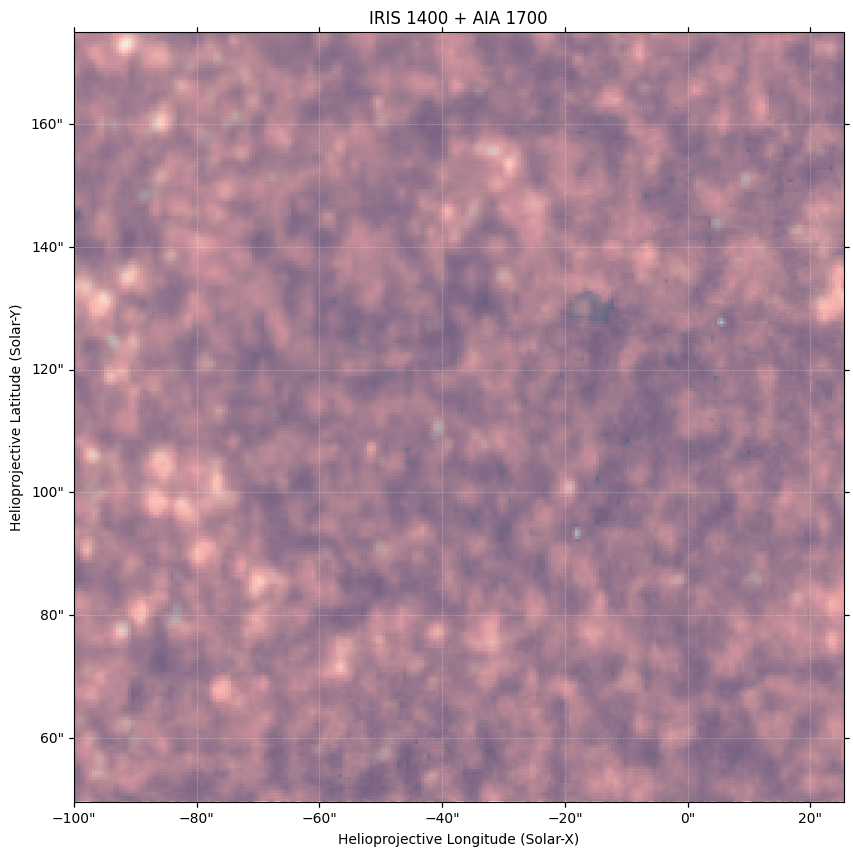

In [39]:
i = 0

iris_map = iris_derotated_seq[i]
aia1700_map = aia1700_derotated_seq[i]

iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=50, stretch=SqrtStretch())
aia1700_norm = ImageNormalize(aia1700_map.data, vmin=300, vmax=1800, stretch=SqrtStretch())

fig = plt.figure()
ax = fig.add_subplot(111, projection=aia1700_map)

iris_overlay = iris_map.plot(axes=ax, norm=iris_norm, alpha=0.4, cmap='Reds_r', autoalign=True)
aia1700_overlay = aia1700_map.plot(axes=ax, norm=aia1700_norm, alpha=1, cmap='Blues_r')
ax.set_title('IRIS 1400 + AIA 1700')

plt.show()

### AIA 1700 and IRIS appear to be relatively well aligned for all $\textit{i}$ in iris_derotated_seq and aia1700_derotated_seq

  0%|                                                                                                                                                                                                                     | 0/360 [00:00<?, ?it/s]

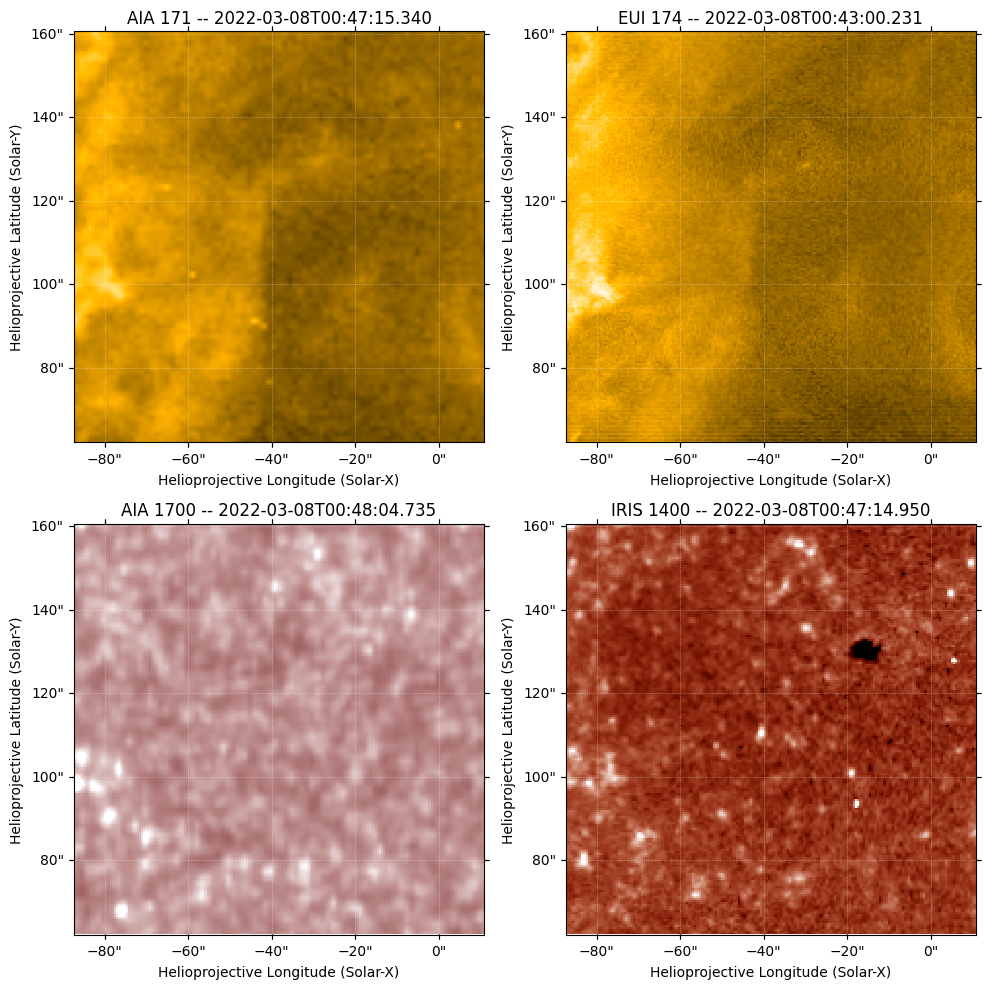

  0%|▌                                                                                                                                                                                                            | 1/360 [00:00<04:14,  1.41it/s]

<Figure size 1000x1000 with 0 Axes>

  1%|█▏                                                                                                                                                                                                           | 2/360 [00:01<02:54,  2.06it/s]

<Figure size 1000x1000 with 0 Axes>

  1%|█▋                                                                                                                                                                                                           | 3/360 [00:01<02:29,  2.39it/s]

<Figure size 1000x1000 with 0 Axes>

  1%|██▎                                                                                                                                                                                                          | 4/360 [00:01<02:18,  2.56it/s]

<Figure size 1000x1000 with 0 Axes>

  1%|██▊                                                                                                                                                                                                          | 5/360 [00:02<02:13,  2.67it/s]

<Figure size 1000x1000 with 0 Axes>

  2%|███▍                                                                                                                                                                                                         | 6/360 [00:02<02:09,  2.73it/s]

<Figure size 1000x1000 with 0 Axes>

  2%|███▉                                                                                                                                                                                                         | 7/360 [00:02<02:07,  2.77it/s]

<Figure size 1000x1000 with 0 Axes>

  2%|████▌                                                                                                                                                                                                        | 8/360 [00:03<02:06,  2.79it/s]

<Figure size 1000x1000 with 0 Axes>

  2%|█████▏                                                                                                                                                                                                       | 9/360 [00:03<02:37,  2.23it/s]

<Figure size 1000x1000 with 0 Axes>

  3%|█████▋                                                                                                                                                                                                      | 10/360 [00:04<02:27,  2.37it/s]

<Figure size 1000x1000 with 0 Axes>

  3%|██████▏                                                                                                                                                                                                     | 11/360 [00:04<02:21,  2.47it/s]

<Figure size 1000x1000 with 0 Axes>

  3%|██████▊                                                                                                                                                                                                     | 12/360 [00:04<02:16,  2.54it/s]

<Figure size 1000x1000 with 0 Axes>

  4%|███████▎                                                                                                                                                                                                    | 13/360 [00:05<02:14,  2.59it/s]

<Figure size 1000x1000 with 0 Axes>

  4%|███████▉                                                                                                                                                                                                    | 14/360 [00:05<02:12,  2.60it/s]

<Figure size 1000x1000 with 0 Axes>

  4%|████████▌                                                                                                                                                                                                   | 15/360 [00:05<02:11,  2.62it/s]

<Figure size 1000x1000 with 0 Axes>

  4%|█████████                                                                                                                                                                                                   | 16/360 [00:06<02:11,  2.62it/s]

<Figure size 1000x1000 with 0 Axes>

  5%|█████████▋                                                                                                                                                                                                  | 17/360 [00:06<02:11,  2.62it/s]

<Figure size 1000x1000 with 0 Axes>

  5%|██████████▏                                                                                                                                                                                                 | 18/360 [00:07<02:11,  2.61it/s]

<Figure size 1000x1000 with 0 Axes>

  5%|██████████▊                                                                                                                                                                                                 | 19/360 [00:07<02:11,  2.60it/s]

<Figure size 1000x1000 with 0 Axes>

  6%|███████████▎                                                                                                                                                                                                | 20/360 [00:07<02:11,  2.59it/s]

<Figure size 1000x1000 with 0 Axes>

  6%|███████████▉                                                                                                                                                                                                | 21/360 [00:08<02:11,  2.57it/s]

<Figure size 1000x1000 with 0 Axes>

  6%|████████████▍                                                                                                                                                                                               | 22/360 [00:08<02:13,  2.53it/s]

<Figure size 1000x1000 with 0 Axes>

  6%|█████████████                                                                                                                                                                                               | 23/360 [00:09<02:14,  2.51it/s]

<Figure size 1000x1000 with 0 Axes>

  7%|█████████████▌                                                                                                                                                                                              | 24/360 [00:09<02:16,  2.47it/s]

<Figure size 1000x1000 with 0 Axes>

  7%|██████████████▏                                                                                                                                                                                             | 25/360 [00:09<02:15,  2.46it/s]

<Figure size 1000x1000 with 0 Axes>

  7%|██████████████▋                                                                                                                                                                                             | 26/360 [00:10<02:16,  2.45it/s]

<Figure size 1000x1000 with 0 Axes>

  8%|███████████████▎                                                                                                                                                                                            | 27/360 [00:10<02:16,  2.44it/s]

<Figure size 1000x1000 with 0 Axes>

  8%|███████████████▊                                                                                                                                                                                            | 28/360 [00:11<02:16,  2.43it/s]

<Figure size 1000x1000 with 0 Axes>

  8%|████████████████▍                                                                                                                                                                                           | 29/360 [00:11<02:16,  2.42it/s]

<Figure size 1000x1000 with 0 Axes>

  8%|█████████████████                                                                                                                                                                                           | 30/360 [00:12<02:17,  2.41it/s]

<Figure size 1000x1000 with 0 Axes>

  9%|█████████████████▌                                                                                                                                                                                          | 31/360 [00:12<02:17,  2.39it/s]

<Figure size 1000x1000 with 0 Axes>

  9%|██████████████████▏                                                                                                                                                                                         | 32/360 [00:12<02:18,  2.37it/s]

<Figure size 1000x1000 with 0 Axes>

  9%|██████████████████▋                                                                                                                                                                                         | 33/360 [00:13<02:20,  2.33it/s]

<Figure size 1000x1000 with 0 Axes>

  9%|███████████████████▎                                                                                                                                                                                        | 34/360 [00:13<02:20,  2.32it/s]

<Figure size 1000x1000 with 0 Axes>

 10%|███████████████████▊                                                                                                                                                                                        | 35/360 [00:14<02:21,  2.30it/s]

<Figure size 1000x1000 with 0 Axes>

 10%|████████████████████▍                                                                                                                                                                                       | 36/360 [00:14<02:21,  2.28it/s]

<Figure size 1000x1000 with 0 Axes>

 10%|████████████████████▉                                                                                                                                                                                       | 37/360 [00:15<02:21,  2.28it/s]

<Figure size 1000x1000 with 0 Axes>

 11%|█████████████████████▌                                                                                                                                                                                      | 38/360 [00:15<02:47,  1.92it/s]

<Figure size 1000x1000 with 0 Axes>

 11%|██████████████████████                                                                                                                                                                                      | 39/360 [00:16<02:40,  2.00it/s]

<Figure size 1000x1000 with 0 Axes>

 11%|██████████████████████▋                                                                                                                                                                                     | 40/360 [00:16<02:35,  2.06it/s]

<Figure size 1000x1000 with 0 Axes>

 11%|███████████████████████▏                                                                                                                                                                                    | 41/360 [00:17<02:31,  2.10it/s]

<Figure size 1000x1000 with 0 Axes>

 12%|███████████████████████▊                                                                                                                                                                                    | 42/360 [00:17<02:31,  2.10it/s]

<Figure size 1000x1000 with 0 Axes>

 12%|████████████████████████▎                                                                                                                                                                                   | 43/360 [00:18<02:36,  2.02it/s]

<Figure size 1000x1000 with 0 Axes>

 12%|████████████████████████▉                                                                                                                                                                                   | 44/360 [00:18<02:34,  2.05it/s]

<Figure size 1000x1000 with 0 Axes>

 12%|█████████████████████████▌                                                                                                                                                                                  | 45/360 [00:19<02:31,  2.08it/s]

<Figure size 1000x1000 with 0 Axes>

 13%|██████████████████████████                                                                                                                                                                                  | 46/360 [00:19<02:29,  2.09it/s]

<Figure size 1000x1000 with 0 Axes>

 13%|██████████████████████████▋                                                                                                                                                                                 | 47/360 [00:20<02:29,  2.09it/s]

<Figure size 1000x1000 with 0 Axes>

 13%|███████████████████████████▏                                                                                                                                                                                | 48/360 [00:20<02:28,  2.10it/s]

<Figure size 1000x1000 with 0 Axes>

 14%|███████████████████████████▊                                                                                                                                                                                | 49/360 [00:21<02:29,  2.08it/s]

<Figure size 1000x1000 with 0 Axes>

 14%|████████████████████████████▎                                                                                                                                                                               | 50/360 [00:21<02:29,  2.08it/s]

<Figure size 1000x1000 with 0 Axes>

 14%|████████████████████████████▉                                                                                                                                                                               | 51/360 [00:22<02:28,  2.08it/s]

<Figure size 1000x1000 with 0 Axes>

 14%|█████████████████████████████▍                                                                                                                                                                              | 52/360 [00:22<02:28,  2.07it/s]

<Figure size 1000x1000 with 0 Axes>

 15%|██████████████████████████████                                                                                                                                                                              | 53/360 [00:22<02:30,  2.04it/s]

<Figure size 1000x1000 with 0 Axes>

 15%|██████████████████████████████▌                                                                                                                                                                             | 54/360 [00:23<02:32,  2.01it/s]

<Figure size 1000x1000 with 0 Axes>

 15%|███████████████████████████████▏                                                                                                                                                                            | 55/360 [00:24<02:33,  1.98it/s]

<Figure size 1000x1000 with 0 Axes>

 16%|███████████████████████████████▋                                                                                                                                                                            | 56/360 [00:24<02:34,  1.97it/s]

<Figure size 1000x1000 with 0 Axes>

 16%|████████████████████████████████▎                                                                                                                                                                           | 57/360 [00:25<02:35,  1.95it/s]

<Figure size 1000x1000 with 0 Axes>

 16%|████████████████████████████████▊                                                                                                                                                                           | 58/360 [00:25<02:35,  1.94it/s]

<Figure size 1000x1000 with 0 Axes>

 16%|█████████████████████████████████▍                                                                                                                                                                          | 59/360 [00:26<02:35,  1.93it/s]

<Figure size 1000x1000 with 0 Axes>

 17%|██████████████████████████████████                                                                                                                                                                          | 60/360 [00:26<02:36,  1.92it/s]

<Figure size 1000x1000 with 0 Axes>

 17%|██████████████████████████████████▌                                                                                                                                                                         | 61/360 [00:27<02:36,  1.91it/s]

<Figure size 1000x1000 with 0 Axes>

 17%|███████████████████████████████████▏                                                                                                                                                                        | 62/360 [00:27<02:36,  1.90it/s]

<Figure size 1000x1000 with 0 Axes>

 18%|███████████████████████████████████▋                                                                                                                                                                        | 63/360 [00:28<02:36,  1.90it/s]

<Figure size 1000x1000 with 0 Axes>

 18%|████████████████████████████████████▎                                                                                                                                                                       | 64/360 [00:28<02:36,  1.89it/s]

<Figure size 1000x1000 with 0 Axes>

 18%|████████████████████████████████████▊                                                                                                                                                                       | 65/360 [00:29<02:38,  1.86it/s]

<Figure size 1000x1000 with 0 Axes>

 18%|█████████████████████████████████████▍                                                                                                                                                                      | 66/360 [00:29<02:38,  1.85it/s]

<Figure size 1000x1000 with 0 Axes>

 19%|█████████████████████████████████████▉                                                                                                                                                                      | 67/360 [00:30<02:38,  1.85it/s]

<Figure size 1000x1000 with 0 Axes>

 19%|██████████████████████████████████████▌                                                                                                                                                                     | 68/360 [00:30<02:38,  1.84it/s]

<Figure size 1000x1000 with 0 Axes>

 19%|███████████████████████████████████████                                                                                                                                                                     | 69/360 [00:31<02:38,  1.84it/s]

<Figure size 1000x1000 with 0 Axes>

 19%|███████████████████████████████████████▋                                                                                                                                                                    | 70/360 [00:32<02:38,  1.83it/s]

<Figure size 1000x1000 with 0 Axes>

 20%|████████████████████████████████████████▏                                                                                                                                                                   | 71/360 [00:32<02:38,  1.82it/s]

<Figure size 1000x1000 with 0 Axes>

 20%|████████████████████████████████████████▊                                                                                                                                                                   | 72/360 [00:33<03:06,  1.54it/s]

<Figure size 1000x1000 with 0 Axes>

 20%|█████████████████████████████████████████▎                                                                                                                                                                  | 73/360 [00:34<03:00,  1.59it/s]

<Figure size 1000x1000 with 0 Axes>

 21%|█████████████████████████████████████████▉                                                                                                                                                                  | 74/360 [00:34<02:54,  1.64it/s]

<Figure size 1000x1000 with 0 Axes>

 21%|██████████████████████████████████████████▌                                                                                                                                                                 | 75/360 [00:35<02:50,  1.67it/s]

<Figure size 1000x1000 with 0 Axes>

 21%|███████████████████████████████████████████                                                                                                                                                                 | 76/360 [00:35<02:47,  1.69it/s]

<Figure size 1000x1000 with 0 Axes>

 21%|███████████████████████████████████████████▋                                                                                                                                                                | 77/360 [00:36<02:46,  1.70it/s]

<Figure size 1000x1000 with 0 Axes>

 22%|████████████████████████████████████████████▏                                                                                                                                                               | 78/360 [00:36<02:45,  1.70it/s]

<Figure size 1000x1000 with 0 Axes>

 22%|████████████████████████████████████████████▊                                                                                                                                                               | 79/360 [00:37<02:45,  1.70it/s]

<Figure size 1000x1000 with 0 Axes>

 22%|█████████████████████████████████████████████▎                                                                                                                                                              | 80/360 [00:38<02:43,  1.71it/s]

<Figure size 1000x1000 with 0 Axes>

 22%|█████████████████████████████████████████████▉                                                                                                                                                              | 81/360 [00:38<02:43,  1.71it/s]

<Figure size 1000x1000 with 0 Axes>

 23%|██████████████████████████████████████████████▍                                                                                                                                                             | 82/360 [00:39<02:43,  1.70it/s]

<Figure size 1000x1000 with 0 Axes>

 23%|███████████████████████████████████████████████                                                                                                                                                             | 83/360 [00:39<02:43,  1.70it/s]

<Figure size 1000x1000 with 0 Axes>

 23%|███████████████████████████████████████████████▌                                                                                                                                                            | 84/360 [00:40<02:43,  1.68it/s]

<Figure size 1000x1000 with 0 Axes>

 24%|████████████████████████████████████████████████▏                                                                                                                                                           | 85/360 [00:41<02:43,  1.68it/s]

<Figure size 1000x1000 with 0 Axes>

 24%|████████████████████████████████████████████████▋                                                                                                                                                           | 86/360 [00:41<02:43,  1.68it/s]

<Figure size 1000x1000 with 0 Axes>

 24%|█████████████████████████████████████████████████▎                                                                                                                                                          | 87/360 [00:42<02:43,  1.67it/s]

<Figure size 1000x1000 with 0 Axes>

 24%|█████████████████████████████████████████████████▊                                                                                                                                                          | 88/360 [00:42<02:43,  1.67it/s]

<Figure size 1000x1000 with 0 Axes>

 25%|██████████████████████████████████████████████████▍                                                                                                                                                         | 89/360 [00:43<02:43,  1.66it/s]

<Figure size 1000x1000 with 0 Axes>

 25%|███████████████████████████████████████████████████                                                                                                                                                         | 90/360 [00:44<02:47,  1.61it/s]

<Figure size 1000x1000 with 0 Axes>

 25%|███████████████████████████████████████████████████▌                                                                                                                                                        | 91/360 [00:44<02:47,  1.61it/s]

<Figure size 1000x1000 with 0 Axes>

 26%|████████████████████████████████████████████████████▏                                                                                                                                                       | 92/360 [00:45<02:46,  1.61it/s]

<Figure size 1000x1000 with 0 Axes>

 26%|████████████████████████████████████████████████████▋                                                                                                                                                       | 93/360 [00:46<02:46,  1.60it/s]

<Figure size 1000x1000 with 0 Axes>

 26%|█████████████████████████████████████████████████████▎                                                                                                                                                      | 94/360 [00:46<02:47,  1.59it/s]

<Figure size 1000x1000 with 0 Axes>

 26%|█████████████████████████████████████████████████████▊                                                                                                                                                      | 95/360 [00:47<02:47,  1.59it/s]

<Figure size 1000x1000 with 0 Axes>

 27%|██████████████████████████████████████████████████████▍                                                                                                                                                     | 96/360 [00:47<02:46,  1.58it/s]

<Figure size 1000x1000 with 0 Axes>

 27%|██████████████████████████████████████████████████████▉                                                                                                                                                     | 97/360 [00:48<02:46,  1.58it/s]

<Figure size 1000x1000 with 0 Axes>

 27%|███████████████████████████████████████████████████████▌                                                                                                                                                    | 98/360 [00:49<02:46,  1.57it/s]

<Figure size 1000x1000 with 0 Axes>

 28%|████████████████████████████████████████████████████████                                                                                                                                                    | 99/360 [00:49<02:46,  1.57it/s]

<Figure size 1000x1000 with 0 Axes>

 28%|████████████████████████████████████████████████████████▍                                                                                                                                                  | 100/360 [00:50<02:46,  1.57it/s]

<Figure size 1000x1000 with 0 Axes>

 28%|████████████████████████████████████████████████████████▉                                                                                                                                                  | 101/360 [00:51<02:45,  1.56it/s]

<Figure size 1000x1000 with 0 Axes>

 28%|█████████████████████████████████████████████████████████▌                                                                                                                                                 | 102/360 [00:51<02:48,  1.53it/s]

<Figure size 1000x1000 with 0 Axes>

 29%|██████████████████████████████████████████████████████████                                                                                                                                                 | 103/360 [00:52<02:47,  1.53it/s]

<Figure size 1000x1000 with 0 Axes>

 29%|██████████████████████████████████████████████████████████▋                                                                                                                                                | 104/360 [00:53<02:47,  1.53it/s]

<Figure size 1000x1000 with 0 Axes>

 29%|███████████████████████████████████████████████████████████▏                                                                                                                                               | 105/360 [00:53<02:52,  1.48it/s]

<Figure size 1000x1000 with 0 Axes>

 29%|███████████████████████████████████████████████████████████▊                                                                                                                                               | 106/360 [00:54<02:51,  1.49it/s]

<Figure size 1000x1000 with 0 Axes>

 30%|████████████████████████████████████████████████████████████▎                                                                                                                                              | 107/360 [00:55<02:49,  1.49it/s]

<Figure size 1000x1000 with 0 Axes>

 30%|████████████████████████████████████████████████████████████▉                                                                                                                                              | 108/360 [00:55<02:48,  1.49it/s]

<Figure size 1000x1000 with 0 Axes>

 30%|█████████████████████████████████████████████████████████████▍                                                                                                                                             | 109/360 [00:56<02:48,  1.49it/s]

<Figure size 1000x1000 with 0 Axes>

 31%|██████████████████████████████████████████████████████████████                                                                                                                                             | 110/360 [00:57<02:47,  1.49it/s]

<Figure size 1000x1000 with 0 Axes>

 31%|██████████████████████████████████████████████████████████████▌                                                                                                                                            | 111/360 [00:58<03:11,  1.30it/s]

<Figure size 1000x1000 with 0 Axes>

 31%|███████████████████████████████████████████████████████████████▏                                                                                                                                           | 112/360 [00:58<03:04,  1.34it/s]

<Figure size 1000x1000 with 0 Axes>

 31%|███████████████████████████████████████████████████████████████▋                                                                                                                                           | 113/360 [00:59<02:58,  1.38it/s]

<Figure size 1000x1000 with 0 Axes>

 32%|████████████████████████████████████████████████████████████████▎                                                                                                                                          | 114/360 [01:00<02:55,  1.40it/s]

<Figure size 1000x1000 with 0 Axes>

 32%|████████████████████████████████████████████████████████████████▊                                                                                                                                          | 115/360 [01:00<02:52,  1.42it/s]

<Figure size 1000x1000 with 0 Axes>

 32%|█████████████████████████████████████████████████████████████████▍                                                                                                                                         | 116/360 [01:01<02:50,  1.43it/s]

<Figure size 1000x1000 with 0 Axes>

 32%|█████████████████████████████████████████████████████████████████▉                                                                                                                                         | 117/360 [01:02<02:50,  1.43it/s]

<Figure size 1000x1000 with 0 Axes>

 33%|██████████████████████████████████████████████████████████████████▌                                                                                                                                        | 118/360 [01:03<02:50,  1.42it/s]

<Figure size 1000x1000 with 0 Axes>

 33%|███████████████████████████████████████████████████████████████████                                                                                                                                        | 119/360 [01:03<02:50,  1.42it/s]

<Figure size 1000x1000 with 0 Axes>

 33%|███████████████████████████████████████████████████████████████████▋                                                                                                                                       | 120/360 [01:04<02:49,  1.41it/s]

<Figure size 1000x1000 with 0 Axes>

 34%|████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 121/360 [01:05<02:48,  1.42it/s]

<Figure size 1000x1000 with 0 Axes>

 34%|████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 122/360 [01:05<02:48,  1.41it/s]

<Figure size 1000x1000 with 0 Axes>

 34%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 123/360 [01:06<02:47,  1.41it/s]

<Figure size 1000x1000 with 0 Axes>

 34%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 124/360 [01:07<02:47,  1.41it/s]

<Figure size 1000x1000 with 0 Axes>

 35%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 125/360 [01:08<02:48,  1.40it/s]

<Figure size 1000x1000 with 0 Axes>

 35%|███████████████████████████████████████████████████████████████████████                                                                                                                                    | 126/360 [01:08<02:47,  1.40it/s]

<Figure size 1000x1000 with 0 Axes>

 35%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 127/360 [01:09<02:46,  1.40it/s]

<Figure size 1000x1000 with 0 Axes>

 36%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 128/360 [01:10<02:47,  1.39it/s]

<Figure size 1000x1000 with 0 Axes>

 36%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 129/360 [01:10<02:47,  1.38it/s]

<Figure size 1000x1000 with 0 Axes>

 36%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 130/360 [01:11<02:46,  1.38it/s]

<Figure size 1000x1000 with 0 Axes>

 36%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 131/360 [01:12<02:45,  1.38it/s]

<Figure size 1000x1000 with 0 Axes>

 37%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 132/360 [01:13<02:45,  1.38it/s]

<Figure size 1000x1000 with 0 Axes>

 37%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 133/360 [01:13<02:46,  1.37it/s]

<Figure size 1000x1000 with 0 Axes>

 37%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 134/360 [01:14<02:45,  1.36it/s]

<Figure size 1000x1000 with 0 Axes>

 38%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 135/360 [01:15<02:46,  1.35it/s]

<Figure size 1000x1000 with 0 Axes>

 38%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 136/360 [01:16<02:46,  1.34it/s]

<Figure size 1000x1000 with 0 Axes>

 38%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 137/360 [01:16<02:47,  1.33it/s]

<Figure size 1000x1000 with 0 Axes>

 38%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 138/360 [01:17<02:46,  1.33it/s]

<Figure size 1000x1000 with 0 Axes>

 39%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 139/360 [01:18<02:46,  1.33it/s]

<Figure size 1000x1000 with 0 Axes>

 39%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 140/360 [01:19<02:45,  1.33it/s]

<Figure size 1000x1000 with 0 Axes>

 39%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 141/360 [01:19<02:44,  1.33it/s]

<Figure size 1000x1000 with 0 Axes>

 39%|████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 142/360 [01:20<02:44,  1.33it/s]

<Figure size 1000x1000 with 0 Axes>

 40%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 143/360 [01:21<02:45,  1.31it/s]

<Figure size 1000x1000 with 0 Axes>

 40%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 144/360 [01:22<02:45,  1.30it/s]

<Figure size 1000x1000 with 0 Axes>

 40%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 145/360 [01:22<02:45,  1.30it/s]

<Figure size 1000x1000 with 0 Axes>

 41%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 146/360 [01:23<02:44,  1.30it/s]

<Figure size 1000x1000 with 0 Axes>

 41%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 147/360 [01:24<02:43,  1.30it/s]

<Figure size 1000x1000 with 0 Axes>

 41%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 148/360 [01:25<02:43,  1.29it/s]

<Figure size 1000x1000 with 0 Axes>

 41%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 149/360 [01:26<02:44,  1.29it/s]

<Figure size 1000x1000 with 0 Axes>

 42%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 150/360 [01:26<02:44,  1.27it/s]

<Figure size 1000x1000 with 0 Axes>

 42%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 151/360 [01:27<02:44,  1.27it/s]

<Figure size 1000x1000 with 0 Axes>

 42%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 152/360 [01:28<02:45,  1.26it/s]

<Figure size 1000x1000 with 0 Axes>

 42%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 153/360 [01:29<02:44,  1.26it/s]

<Figure size 1000x1000 with 0 Axes>

 43%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 154/360 [01:30<02:46,  1.24it/s]

<Figure size 1000x1000 with 0 Axes>

 43%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 155/360 [01:30<02:45,  1.24it/s]

<Figure size 1000x1000 with 0 Axes>

 43%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 156/360 [01:31<02:45,  1.23it/s]

<Figure size 1000x1000 with 0 Axes>

 44%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 157/360 [01:32<03:07,  1.08it/s]

<Figure size 1000x1000 with 0 Axes>

 44%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 158/360 [01:33<03:00,  1.12it/s]

<Figure size 1000x1000 with 0 Axes>

 44%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 159/360 [01:34<02:56,  1.14it/s]

<Figure size 1000x1000 with 0 Axes>

 44%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 160/360 [01:35<02:51,  1.17it/s]

<Figure size 1000x1000 with 0 Axes>

 45%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 161/360 [01:36<02:48,  1.18it/s]

<Figure size 1000x1000 with 0 Axes>

 45%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 162/360 [01:37<02:46,  1.19it/s]

<Figure size 1000x1000 with 0 Axes>

 45%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 163/360 [01:37<02:45,  1.19it/s]

<Figure size 1000x1000 with 0 Axes>

 46%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 164/360 [01:38<02:43,  1.20it/s]

<Figure size 1000x1000 with 0 Axes>

 46%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 165/360 [01:39<02:42,  1.20it/s]

<Figure size 1000x1000 with 0 Axes>

 46%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 166/360 [01:40<02:42,  1.20it/s]

<Figure size 1000x1000 with 0 Axes>

 46%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 167/360 [01:41<02:40,  1.20it/s]

<Figure size 1000x1000 with 0 Axes>

 47%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 168/360 [01:42<02:40,  1.20it/s]

<Figure size 1000x1000 with 0 Axes>

 47%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 169/360 [01:42<02:39,  1.20it/s]

<Figure size 1000x1000 with 0 Axes>

 47%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 170/360 [01:43<02:39,  1.19it/s]

<Figure size 1000x1000 with 0 Axes>

 48%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 171/360 [01:44<02:39,  1.18it/s]

<Figure size 1000x1000 with 0 Axes>

 48%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 172/360 [01:45<02:38,  1.18it/s]

<Figure size 1000x1000 with 0 Axes>

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 173/360 [01:46<02:39,  1.18it/s]

<Figure size 1000x1000 with 0 Axes>

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 174/360 [01:47<02:39,  1.17it/s]

<Figure size 1000x1000 with 0 Axes>

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 175/360 [01:48<02:40,  1.15it/s]

<Figure size 1000x1000 with 0 Axes>

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 176/360 [01:48<02:38,  1.16it/s]

<Figure size 1000x1000 with 0 Axes>

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 177/360 [01:49<02:39,  1.15it/s]

<Figure size 1000x1000 with 0 Axes>

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 178/360 [01:50<02:38,  1.15it/s]

<Figure size 1000x1000 with 0 Axes>

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 179/360 [01:51<02:37,  1.15it/s]

<Figure size 1000x1000 with 0 Axes>

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 180/360 [01:52<02:36,  1.15it/s]

<Figure size 1000x1000 with 0 Axes>

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 181/360 [01:53<02:36,  1.15it/s]

<Figure size 1000x1000 with 0 Axes>

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 182/360 [01:54<02:35,  1.15it/s]

<Figure size 1000x1000 with 0 Axes>

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 183/360 [01:55<02:34,  1.15it/s]

<Figure size 1000x1000 with 0 Axes>

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 184/360 [01:56<02:37,  1.12it/s]

<Figure size 1000x1000 with 0 Axes>

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 185/360 [01:56<02:37,  1.11it/s]

<Figure size 1000x1000 with 0 Axes>

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 186/360 [01:57<02:35,  1.12it/s]

<Figure size 1000x1000 with 0 Axes>

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 187/360 [01:58<02:34,  1.12it/s]

<Figure size 1000x1000 with 0 Axes>

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 188/360 [01:59<02:34,  1.12it/s]

<Figure size 1000x1000 with 0 Axes>

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 189/360 [02:00<02:33,  1.11it/s]

<Figure size 1000x1000 with 0 Axes>

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 190/360 [02:01<02:32,  1.11it/s]

<Figure size 1000x1000 with 0 Axes>

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 191/360 [02:02<02:31,  1.11it/s]

<Figure size 1000x1000 with 0 Axes>

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 192/360 [02:03<02:31,  1.11it/s]

<Figure size 1000x1000 with 0 Axes>

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 193/360 [02:04<02:31,  1.10it/s]

<Figure size 1000x1000 with 0 Axes>

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 194/360 [02:05<02:30,  1.10it/s]

<Figure size 1000x1000 with 0 Axes>

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 195/360 [02:05<02:29,  1.10it/s]

<Figure size 1000x1000 with 0 Axes>

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 196/360 [02:06<02:29,  1.10it/s]

<Figure size 1000x1000 with 0 Axes>

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 197/360 [02:07<02:28,  1.10it/s]

<Figure size 1000x1000 with 0 Axes>

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 198/360 [02:08<02:27,  1.10it/s]

<Figure size 1000x1000 with 0 Axes>

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 199/360 [02:09<02:26,  1.10it/s]

<Figure size 1000x1000 with 0 Axes>

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 200/360 [02:10<02:26,  1.09it/s]

<Figure size 1000x1000 with 0 Axes>

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 201/360 [02:11<02:26,  1.09it/s]

<Figure size 1000x1000 with 0 Axes>

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 202/360 [02:12<02:26,  1.08it/s]

<Figure size 1000x1000 with 0 Axes>

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 203/360 [02:13<02:25,  1.08it/s]

<Figure size 1000x1000 with 0 Axes>

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 204/360 [02:14<02:25,  1.07it/s]

<Figure size 1000x1000 with 0 Axes>

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 205/360 [02:15<02:24,  1.07it/s]

<Figure size 1000x1000 with 0 Axes>

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 206/360 [02:16<02:24,  1.07it/s]

<Figure size 1000x1000 with 0 Axes>

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 207/360 [02:17<02:23,  1.06it/s]

<Figure size 1000x1000 with 0 Axes>

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 208/360 [02:18<02:23,  1.06it/s]

<Figure size 1000x1000 with 0 Axes>

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 209/360 [02:19<02:22,  1.06it/s]

<Figure size 1000x1000 with 0 Axes>

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 210/360 [02:19<02:22,  1.05it/s]

<Figure size 1000x1000 with 0 Axes>

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 211/360 [02:21<02:41,  1.09s/it]

<Figure size 1000x1000 with 0 Axes>

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 212/360 [02:22<02:35,  1.05s/it]

<Figure size 1000x1000 with 0 Axes>

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 213/360 [02:23<02:30,  1.03s/it]

<Figure size 1000x1000 with 0 Axes>

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 214/360 [02:24<02:28,  1.01s/it]

<Figure size 1000x1000 with 0 Axes>

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 215/360 [02:25<02:25,  1.00s/it]

<Figure size 1000x1000 with 0 Axes>

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 216/360 [02:26<02:22,  1.01it/s]

<Figure size 1000x1000 with 0 Axes>

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 217/360 [02:27<02:21,  1.01it/s]

<Figure size 1000x1000 with 0 Axes>

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 218/360 [02:28<02:19,  1.02it/s]

<Figure size 1000x1000 with 0 Axes>

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 219/360 [02:29<02:18,  1.02it/s]

<Figure size 1000x1000 with 0 Axes>

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 220/360 [02:30<02:18,  1.01it/s]

<Figure size 1000x1000 with 0 Axes>

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 221/360 [02:31<02:17,  1.01it/s]

<Figure size 1000x1000 with 0 Axes>

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 222/360 [02:32<02:15,  1.02it/s]

<Figure size 1000x1000 with 0 Axes>

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 223/360 [02:33<02:15,  1.01it/s]

<Figure size 1000x1000 with 0 Axes>

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 224/360 [02:34<02:14,  1.01it/s]

<Figure size 1000x1000 with 0 Axes>

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 225/360 [02:35<02:14,  1.01it/s]

<Figure size 1000x1000 with 0 Axes>

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 226/360 [02:36<02:13,  1.01it/s]

<Figure size 1000x1000 with 0 Axes>

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 227/360 [02:37<02:12,  1.00it/s]

<Figure size 1000x1000 with 0 Axes>

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 228/360 [02:38<02:12,  1.00s/it]

<Figure size 1000x1000 with 0 Axes>

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 229/360 [02:39<02:11,  1.01s/it]

<Figure size 1000x1000 with 0 Axes>

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 230/360 [02:40<02:10,  1.01s/it]

<Figure size 1000x1000 with 0 Axes>

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 231/360 [02:41<02:11,  1.02s/it]

<Figure size 1000x1000 with 0 Axes>

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 232/360 [02:42<02:10,  1.02s/it]

<Figure size 1000x1000 with 0 Axes>

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 233/360 [02:43<02:09,  1.02s/it]

<Figure size 1000x1000 with 0 Axes>

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 234/360 [02:44<02:08,  1.02s/it]

<Figure size 1000x1000 with 0 Axes>

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 235/360 [02:45<02:08,  1.03s/it]

<Figure size 1000x1000 with 0 Axes>

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 236/360 [02:46<02:07,  1.03s/it]

<Figure size 1000x1000 with 0 Axes>

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 237/360 [02:47<02:06,  1.03s/it]

<Figure size 1000x1000 with 0 Axes>

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 238/360 [02:48<02:05,  1.03s/it]

<Figure size 1000x1000 with 0 Axes>

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 239/360 [02:49<02:05,  1.03s/it]

<Figure size 1000x1000 with 0 Axes>

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 240/360 [02:50<02:03,  1.03s/it]

<Figure size 1000x1000 with 0 Axes>

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 241/360 [02:51<02:03,  1.04s/it]

<Figure size 1000x1000 with 0 Axes>

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 242/360 [02:52<02:03,  1.04s/it]

<Figure size 1000x1000 with 0 Axes>

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 243/360 [02:53<02:02,  1.05s/it]

<Figure size 1000x1000 with 0 Axes>

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 244/360 [02:54<02:01,  1.05s/it]

<Figure size 1000x1000 with 0 Axes>

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 245/360 [02:55<01:59,  1.04s/it]

<Figure size 1000x1000 with 0 Axes>

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 246/360 [02:56<02:01,  1.07s/it]

<Figure size 1000x1000 with 0 Axes>

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 247/360 [02:57<02:00,  1.06s/it]

<Figure size 1000x1000 with 0 Axes>

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 248/360 [02:58<01:58,  1.06s/it]

<Figure size 1000x1000 with 0 Axes>

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 249/360 [02:59<01:57,  1.06s/it]

<Figure size 1000x1000 with 0 Axes>

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 250/360 [03:01<01:56,  1.06s/it]

<Figure size 1000x1000 with 0 Axes>

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 251/360 [03:02<01:54,  1.05s/it]

<Figure size 1000x1000 with 0 Axes>

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 252/360 [03:03<01:54,  1.06s/it]

<Figure size 1000x1000 with 0 Axes>

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 253/360 [03:04<01:53,  1.06s/it]

<Figure size 1000x1000 with 0 Axes>

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 254/360 [03:05<01:52,  1.06s/it]

<Figure size 1000x1000 with 0 Axes>

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 255/360 [03:06<01:52,  1.07s/it]

<Figure size 1000x1000 with 0 Axes>

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 256/360 [03:07<01:51,  1.07s/it]

<Figure size 1000x1000 with 0 Axes>

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 257/360 [03:08<01:50,  1.07s/it]

<Figure size 1000x1000 with 0 Axes>

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 258/360 [03:09<01:49,  1.07s/it]

<Figure size 1000x1000 with 0 Axes>

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 259/360 [03:10<01:48,  1.07s/it]

<Figure size 1000x1000 with 0 Axes>

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 260/360 [03:11<01:47,  1.07s/it]

<Figure size 1000x1000 with 0 Axes>

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 261/360 [03:12<01:46,  1.08s/it]

<Figure size 1000x1000 with 0 Axes>

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 262/360 [03:13<01:45,  1.08s/it]

<Figure size 1000x1000 with 0 Axes>

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 263/360 [03:14<01:45,  1.08s/it]

<Figure size 1000x1000 with 0 Axes>

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 264/360 [03:16<01:45,  1.09s/it]

<Figure size 1000x1000 with 0 Axes>

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 265/360 [03:17<01:44,  1.10s/it]

<Figure size 1000x1000 with 0 Axes>

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 266/360 [03:18<01:43,  1.10s/it]

<Figure size 1000x1000 with 0 Axes>

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 267/360 [03:19<01:42,  1.10s/it]

<Figure size 1000x1000 with 0 Axes>

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 268/360 [03:20<01:41,  1.10s/it]

<Figure size 1000x1000 with 0 Axes>

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 269/360 [03:21<01:40,  1.10s/it]

<Figure size 1000x1000 with 0 Axes>

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 270/360 [03:22<01:39,  1.10s/it]

<Figure size 1000x1000 with 0 Axes>

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 271/360 [03:23<01:38,  1.11s/it]

<Figure size 1000x1000 with 0 Axes>

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 272/360 [03:24<01:37,  1.11s/it]

<Figure size 1000x1000 with 0 Axes>

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 273/360 [03:26<01:49,  1.26s/it]

<Figure size 1000x1000 with 0 Axes>

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 274/360 [03:27<01:45,  1.22s/it]

<Figure size 1000x1000 with 0 Axes>

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 275/360 [03:28<01:41,  1.19s/it]

<Figure size 1000x1000 with 0 Axes>

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 276/360 [03:29<01:38,  1.17s/it]

<Figure size 1000x1000 with 0 Axes>

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 277/360 [03:31<01:36,  1.16s/it]

<Figure size 1000x1000 with 0 Axes>

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 278/360 [03:32<01:34,  1.15s/it]

<Figure size 1000x1000 with 0 Axes>

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 279/360 [03:33<01:32,  1.15s/it]

<Figure size 1000x1000 with 0 Axes>

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 280/360 [03:34<01:31,  1.14s/it]

<Figure size 1000x1000 with 0 Axes>

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 281/360 [03:35<01:30,  1.14s/it]

<Figure size 1000x1000 with 0 Axes>

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 282/360 [03:36<01:30,  1.16s/it]

<Figure size 1000x1000 with 0 Axes>

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 283/360 [03:37<01:28,  1.15s/it]

<Figure size 1000x1000 with 0 Axes>

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 284/360 [03:39<01:28,  1.16s/it]

<Figure size 1000x1000 with 0 Axes>

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 285/360 [03:40<01:27,  1.16s/it]

<Figure size 1000x1000 with 0 Axes>

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 286/360 [03:41<01:25,  1.16s/it]

<Figure size 1000x1000 with 0 Axes>

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 287/360 [03:42<01:24,  1.16s/it]

<Figure size 1000x1000 with 0 Axes>

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 288/360 [03:43<01:23,  1.16s/it]

<Figure size 1000x1000 with 0 Axes>

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 289/360 [03:44<01:22,  1.16s/it]

<Figure size 1000x1000 with 0 Axes>

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 290/360 [03:46<01:21,  1.17s/it]

<Figure size 1000x1000 with 0 Axes>

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 291/360 [03:47<01:20,  1.17s/it]

<Figure size 1000x1000 with 0 Axes>

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 292/360 [03:48<01:19,  1.17s/it]

<Figure size 1000x1000 with 0 Axes>

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 293/360 [03:49<01:18,  1.17s/it]

<Figure size 1000x1000 with 0 Axes>

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 294/360 [03:50<01:17,  1.17s/it]

<Figure size 1000x1000 with 0 Axes>

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 295/360 [03:52<01:16,  1.17s/it]

<Figure size 1000x1000 with 0 Axes>

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 296/360 [03:53<01:15,  1.18s/it]

<Figure size 1000x1000 with 0 Axes>

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 297/360 [03:54<01:14,  1.19s/it]

<Figure size 1000x1000 with 0 Axes>

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 298/360 [03:55<01:13,  1.19s/it]

<Figure size 1000x1000 with 0 Axes>

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 299/360 [03:56<01:12,  1.19s/it]

<Figure size 1000x1000 with 0 Axes>

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 300/360 [03:57<01:11,  1.19s/it]

<Figure size 1000x1000 with 0 Axes>

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 301/360 [03:59<01:10,  1.19s/it]

<Figure size 1000x1000 with 0 Axes>

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 302/360 [04:00<01:09,  1.19s/it]

<Figure size 1000x1000 with 0 Axes>

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 303/360 [04:01<01:08,  1.20s/it]

<Figure size 1000x1000 with 0 Axes>

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 304/360 [04:02<01:07,  1.21s/it]

<Figure size 1000x1000 with 0 Axes>

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 305/360 [04:04<01:06,  1.22s/it]

<Figure size 1000x1000 with 0 Axes>

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 306/360 [04:05<01:05,  1.22s/it]

<Figure size 1000x1000 with 0 Axes>

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 307/360 [04:06<01:04,  1.22s/it]

<Figure size 1000x1000 with 0 Axes>

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 308/360 [04:07<01:03,  1.21s/it]

<Figure size 1000x1000 with 0 Axes>

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 309/360 [04:08<01:02,  1.22s/it]

<Figure size 1000x1000 with 0 Axes>

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 310/360 [04:10<01:00,  1.22s/it]

<Figure size 1000x1000 with 0 Axes>

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 311/360 [04:11<00:59,  1.22s/it]

<Figure size 1000x1000 with 0 Axes>

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 312/360 [04:12<00:58,  1.22s/it]

<Figure size 1000x1000 with 0 Axes>

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 313/360 [04:13<00:57,  1.22s/it]

<Figure size 1000x1000 with 0 Axes>

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 314/360 [04:15<00:56,  1.23s/it]

<Figure size 1000x1000 with 0 Axes>

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 315/360 [04:16<00:55,  1.23s/it]

<Figure size 1000x1000 with 0 Axes>

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 316/360 [04:17<00:54,  1.23s/it]

<Figure size 1000x1000 with 0 Axes>

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 317/360 [04:18<00:53,  1.24s/it]

<Figure size 1000x1000 with 0 Axes>

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 318/360 [04:20<00:52,  1.24s/it]

<Figure size 1000x1000 with 0 Axes>

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 319/360 [04:21<00:51,  1.26s/it]

<Figure size 1000x1000 with 0 Axes>

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 320/360 [04:22<00:50,  1.26s/it]

<Figure size 1000x1000 with 0 Axes>

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 321/360 [04:23<00:49,  1.26s/it]

<Figure size 1000x1000 with 0 Axes>

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 322/360 [04:25<00:47,  1.26s/it]

<Figure size 1000x1000 with 0 Axes>

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 323/360 [04:26<00:46,  1.26s/it]

<Figure size 1000x1000 with 0 Axes>

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 324/360 [04:27<00:45,  1.26s/it]

<Figure size 1000x1000 with 0 Axes>

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 325/360 [04:28<00:44,  1.27s/it]

<Figure size 1000x1000 with 0 Axes>

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 326/360 [04:30<00:43,  1.28s/it]

<Figure size 1000x1000 with 0 Axes>

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 327/360 [04:31<00:42,  1.28s/it]

<Figure size 1000x1000 with 0 Axes>

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 328/360 [04:32<00:40,  1.28s/it]

<Figure size 1000x1000 with 0 Axes>

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 329/360 [04:34<00:39,  1.28s/it]

<Figure size 1000x1000 with 0 Axes>

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 330/360 [04:35<00:38,  1.28s/it]

<Figure size 1000x1000 with 0 Axes>

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 331/360 [04:36<00:37,  1.29s/it]

<Figure size 1000x1000 with 0 Axes>

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 332/360 [04:37<00:36,  1.29s/it]

<Figure size 1000x1000 with 0 Axes>

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 333/360 [04:39<00:34,  1.29s/it]

<Figure size 1000x1000 with 0 Axes>

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 334/360 [04:40<00:33,  1.29s/it]

<Figure size 1000x1000 with 0 Axes>

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 335/360 [04:41<00:32,  1.29s/it]

<Figure size 1000x1000 with 0 Axes>

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 336/360 [04:43<00:30,  1.29s/it]

<Figure size 1000x1000 with 0 Axes>

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 337/360 [04:44<00:29,  1.30s/it]

<Figure size 1000x1000 with 0 Axes>

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 338/360 [04:45<00:28,  1.30s/it]

<Figure size 1000x1000 with 0 Axes>

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 339/360 [04:47<00:27,  1.30s/it]

<Figure size 1000x1000 with 0 Axes>

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 340/360 [04:48<00:26,  1.30s/it]

<Figure size 1000x1000 with 0 Axes>

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 341/360 [04:49<00:24,  1.31s/it]

<Figure size 1000x1000 with 0 Axes>

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 342/360 [04:50<00:23,  1.31s/it]

<Figure size 1000x1000 with 0 Axes>

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 343/360 [04:52<00:22,  1.32s/it]

<Figure size 1000x1000 with 0 Axes>

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 344/360 [04:54<00:23,  1.49s/it]

<Figure size 1000x1000 with 0 Axes>

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 345/360 [04:55<00:21,  1.46s/it]

<Figure size 1000x1000 with 0 Axes>

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 346/360 [04:56<00:20,  1.43s/it]

<Figure size 1000x1000 with 0 Axes>

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 347/360 [04:58<00:18,  1.40s/it]

<Figure size 1000x1000 with 0 Axes>

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 348/360 [04:59<00:17,  1.43s/it]

<Figure size 1000x1000 with 0 Axes>

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 349/360 [05:01<00:15,  1.41s/it]

<Figure size 1000x1000 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 350/360 [05:02<00:14,  1.41s/it]

<Figure size 1000x1000 with 0 Axes>

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 351/360 [05:03<00:12,  1.39s/it]

<Figure size 1000x1000 with 0 Axes>

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 352/360 [05:05<00:11,  1.38s/it]

<Figure size 1000x1000 with 0 Axes>

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 353/360 [05:06<00:09,  1.38s/it]

<Figure size 1000x1000 with 0 Axes>

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 354/360 [05:08<00:08,  1.39s/it]

<Figure size 1000x1000 with 0 Axes>

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 355/360 [05:09<00:06,  1.39s/it]

<Figure size 1000x1000 with 0 Axes>

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 356/360 [05:10<00:05,  1.40s/it]

<Figure size 1000x1000 with 0 Axes>

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 357/360 [05:12<00:04,  1.39s/it]

<Figure size 1000x1000 with 0 Axes>

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 358/360 [05:13<00:02,  1.39s/it]

<Figure size 1000x1000 with 0 Axes>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 359/360 [05:14<00:01,  1.39s/it]

<Figure size 1000x1000 with 0 Axes>

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [05:16<00:00,  1.14it/s]


In [59]:
aia171_norm = ImageNormalize(aia_map.data, vmin=30, vmax=350, stretch=SqrtStretch())
eui_norm = ImageNormalize(eui_map.data, vmin=300, vmax=1500, stretch=SqrtStretch())
iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=15, stretch=SqrtStretch())
aia1700_norm = ImageNormalize(aia1700_map.data, vmin=300, vmax=1800, stretch=SqrtStretch())

fig = plt.figure(figsize=(10, 10))

writer = PillowWriter(fps=20)
with writer.saving(fig, "gifs/aia_and_eui_and_iris.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_1_seq))):

        aia_map = aia171_derotated_seq[i]
        ax1 = fig.add_subplot(221, projection=aia_map.wcs)
        aia_map.plot(axes=ax1, norm=aia171_norm, title=f'AIA 171 -- {matched_aia_seq[i].date}')

        eui_map = eui_shifted_seq[i]
        ax2 = fig.add_subplot(222, projection=eui_map.wcs, sharex=ax1, sharey=ax1)
        eui_map.plot(axes=ax2, norm=eui_norm, title=f'EUI 174 -- {eui_seq[i].date}')

        aia1700_map = aia1700_derotated_seq[i]
        ax3 = fig.add_subplot(223, projection=aia1700_map.wcs, sharex=ax1, sharey=ax1)
        aia1700_map.plot(axes=ax3, norm=aia1700_norm, title=f'AIA 1700 -- {matched_aia1700_seq[i].date}')

        iris_map = iris_derotated_seq[i]
        ax4 = fig.add_subplot(224, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_map.plot(axes=ax4, norm=iris_norm, title=f'IRIS 1400 -- {matched_iris_seq[i].date}')

        # crop FOV to remove clipped region of EUI 174
        ax1.set_xlim(25, 225)
        ax1.set_ylim(25, 225)

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear(); ax4.clear()

# Save output of data alignment process

In [40]:
# spatially aligned (redefining to save)
eui174_aligned = eui_shifted_seq
iris1400_aligned = iris_derotated_seq
aia171_aligned = aia171_derotated_seq
aia1700_aligned = aia1700_derotated_seq

# temporally aligned (redefining to save)
eui174_matched = eui_seq
iris1400_matched = matched_iris_seq
aia171_matched = matched_aia_seq
aia1700_matched = matched_aia1700_seq

### View aligned EUI 174 and IRIS 1400

  0%|                                                                                                                                                                                                                     | 0/360 [00:00<?, ?it/s]

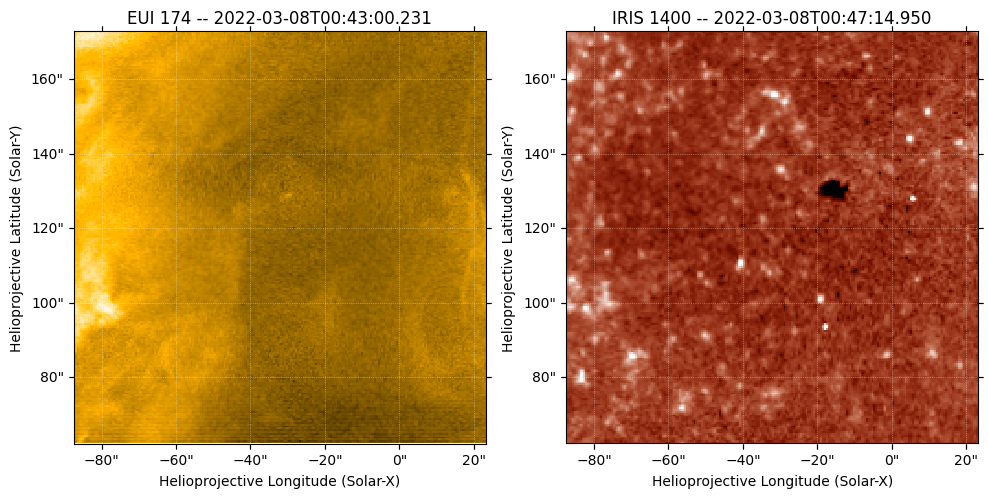

  0%|▌                                                                                                                                                                                                            | 1/360 [00:00<02:18,  2.59it/s]

<Figure size 1000x1000 with 0 Axes>

  1%|█▏                                                                                                                                                                                                           | 2/360 [00:00<01:32,  3.88it/s]

<Figure size 1000x1000 with 0 Axes>

  1%|█▋                                                                                                                                                                                                           | 3/360 [00:00<01:17,  4.58it/s]

<Figure size 1000x1000 with 0 Axes>

  1%|██▎                                                                                                                                                                                                          | 4/360 [00:00<01:11,  4.98it/s]

<Figure size 1000x1000 with 0 Axes>

  1%|██▊                                                                                                                                                                                                          | 5/360 [00:01<01:08,  5.20it/s]

<Figure size 1000x1000 with 0 Axes>

  2%|███▍                                                                                                                                                                                                         | 6/360 [00:01<01:07,  5.28it/s]

<Figure size 1000x1000 with 0 Axes>

  2%|███▉                                                                                                                                                                                                         | 7/360 [00:01<01:07,  5.25it/s]

<Figure size 1000x1000 with 0 Axes>

  2%|████▌                                                                                                                                                                                                        | 8/360 [00:01<01:05,  5.35it/s]

<Figure size 1000x1000 with 0 Axes>

  2%|█████▏                                                                                                                                                                                                       | 9/360 [00:01<01:04,  5.42it/s]

<Figure size 1000x1000 with 0 Axes>

  3%|█████▋                                                                                                                                                                                                      | 10/360 [00:01<01:04,  5.46it/s]

<Figure size 1000x1000 with 0 Axes>

  3%|██████▏                                                                                                                                                                                                     | 11/360 [00:02<01:04,  5.43it/s]

<Figure size 1000x1000 with 0 Axes>

  3%|██████▊                                                                                                                                                                                                     | 12/360 [00:02<01:04,  5.44it/s]

<Figure size 1000x1000 with 0 Axes>

  4%|███████▎                                                                                                                                                                                                    | 13/360 [00:02<01:04,  5.41it/s]

<Figure size 1000x1000 with 0 Axes>

  4%|███████▉                                                                                                                                                                                                    | 14/360 [00:02<01:04,  5.37it/s]

<Figure size 1000x1000 with 0 Axes>

  4%|████████▌                                                                                                                                                                                                   | 15/360 [00:02<01:04,  5.37it/s]

<Figure size 1000x1000 with 0 Axes>

  4%|█████████                                                                                                                                                                                                   | 16/360 [00:03<01:04,  5.32it/s]

<Figure size 1000x1000 with 0 Axes>

  5%|█████████▋                                                                                                                                                                                                  | 17/360 [00:03<01:04,  5.28it/s]

<Figure size 1000x1000 with 0 Axes>

  5%|██████████▏                                                                                                                                                                                                 | 18/360 [00:03<01:05,  5.24it/s]

<Figure size 1000x1000 with 0 Axes>

  5%|██████████▊                                                                                                                                                                                                 | 19/360 [00:03<01:05,  5.23it/s]

<Figure size 1000x1000 with 0 Axes>

  6%|███████████▎                                                                                                                                                                                                | 20/360 [00:03<01:05,  5.18it/s]

<Figure size 1000x1000 with 0 Axes>

  6%|███████████▉                                                                                                                                                                                                | 21/360 [00:04<01:06,  5.12it/s]

<Figure size 1000x1000 with 0 Axes>

  6%|████████████▍                                                                                                                                                                                               | 22/360 [00:04<01:06,  5.12it/s]

<Figure size 1000x1000 with 0 Axes>

  6%|█████████████                                                                                                                                                                                               | 23/360 [00:04<01:06,  5.05it/s]

<Figure size 1000x1000 with 0 Axes>

  7%|█████████████▌                                                                                                                                                                                              | 24/360 [00:04<01:07,  5.01it/s]

<Figure size 1000x1000 with 0 Axes>

  7%|██████████████▏                                                                                                                                                                                             | 25/360 [00:04<01:06,  5.02it/s]

<Figure size 1000x1000 with 0 Axes>

  7%|██████████████▋                                                                                                                                                                                             | 26/360 [00:05<01:06,  4.99it/s]

<Figure size 1000x1000 with 0 Axes>

  8%|███████████████▎                                                                                                                                                                                            | 27/360 [00:05<01:07,  4.92it/s]

<Figure size 1000x1000 with 0 Axes>

  8%|███████████████▊                                                                                                                                                                                            | 28/360 [00:05<01:07,  4.90it/s]

<Figure size 1000x1000 with 0 Axes>

  8%|████████████████▍                                                                                                                                                                                           | 29/360 [00:05<01:07,  4.88it/s]

<Figure size 1000x1000 with 0 Axes>

  8%|█████████████████                                                                                                                                                                                           | 30/360 [00:05<01:08,  4.84it/s]

<Figure size 1000x1000 with 0 Axes>

  9%|█████████████████▌                                                                                                                                                                                          | 31/360 [00:06<01:08,  4.78it/s]

<Figure size 1000x1000 with 0 Axes>

  9%|██████████████████▏                                                                                                                                                                                         | 32/360 [00:06<01:09,  4.73it/s]

<Figure size 1000x1000 with 0 Axes>

  9%|██████████████████▋                                                                                                                                                                                         | 33/360 [00:06<01:09,  4.70it/s]

<Figure size 1000x1000 with 0 Axes>

  9%|███████████████████▎                                                                                                                                                                                        | 34/360 [00:06<01:09,  4.67it/s]

<Figure size 1000x1000 with 0 Axes>

 10%|███████████████████▊                                                                                                                                                                                        | 35/360 [00:07<01:10,  4.63it/s]

<Figure size 1000x1000 with 0 Axes>

 10%|████████████████████▍                                                                                                                                                                                       | 36/360 [00:07<01:09,  4.63it/s]

<Figure size 1000x1000 with 0 Axes>

 10%|████████████████████▉                                                                                                                                                                                       | 37/360 [00:07<01:09,  4.61it/s]

<Figure size 1000x1000 with 0 Axes>

 11%|█████████████████████▌                                                                                                                                                                                      | 38/360 [00:07<01:10,  4.55it/s]

<Figure size 1000x1000 with 0 Axes>

 11%|██████████████████████                                                                                                                                                                                      | 39/360 [00:07<01:10,  4.54it/s]

<Figure size 1000x1000 with 0 Axes>

 11%|██████████████████████▋                                                                                                                                                                                     | 40/360 [00:08<01:10,  4.53it/s]

<Figure size 1000x1000 with 0 Axes>

 11%|███████████████████████▏                                                                                                                                                                                    | 41/360 [00:08<01:10,  4.50it/s]

<Figure size 1000x1000 with 0 Axes>

 12%|███████████████████████▊                                                                                                                                                                                    | 42/360 [00:08<01:11,  4.44it/s]

<Figure size 1000x1000 with 0 Axes>

 12%|████████████████████████▎                                                                                                                                                                                   | 43/360 [00:08<01:11,  4.42it/s]

<Figure size 1000x1000 with 0 Axes>

 12%|████████████████████████▉                                                                                                                                                                                   | 44/360 [00:09<01:11,  4.39it/s]

<Figure size 1000x1000 with 0 Axes>

 12%|█████████████████████████▌                                                                                                                                                                                  | 45/360 [00:09<01:12,  4.37it/s]

<Figure size 1000x1000 with 0 Axes>

 13%|██████████████████████████                                                                                                                                                                                  | 46/360 [00:09<01:12,  4.36it/s]

<Figure size 1000x1000 with 0 Axes>

 13%|██████████████████████████▋                                                                                                                                                                                 | 47/360 [00:09<01:12,  4.33it/s]

<Figure size 1000x1000 with 0 Axes>

 13%|███████████████████████████▏                                                                                                                                                                                | 48/360 [00:09<01:12,  4.30it/s]

<Figure size 1000x1000 with 0 Axes>

 14%|███████████████████████████▊                                                                                                                                                                                | 49/360 [00:10<01:12,  4.28it/s]

<Figure size 1000x1000 with 0 Axes>

 14%|████████████████████████████▎                                                                                                                                                                               | 50/360 [00:10<01:12,  4.26it/s]

<Figure size 1000x1000 with 0 Axes>

 14%|████████████████████████████▉                                                                                                                                                                               | 51/360 [00:10<01:13,  4.22it/s]

<Figure size 1000x1000 with 0 Axes>

 14%|█████████████████████████████▍                                                                                                                                                                              | 52/360 [00:10<01:13,  4.21it/s]

<Figure size 1000x1000 with 0 Axes>

 15%|██████████████████████████████                                                                                                                                                                              | 53/360 [00:11<01:13,  4.19it/s]

<Figure size 1000x1000 with 0 Axes>

 15%|██████████████████████████████▌                                                                                                                                                                             | 54/360 [00:11<01:13,  4.15it/s]

<Figure size 1000x1000 with 0 Axes>

 15%|███████████████████████████████▏                                                                                                                                                                            | 55/360 [00:11<01:13,  4.13it/s]

<Figure size 1000x1000 with 0 Axes>

 16%|███████████████████████████████▋                                                                                                                                                                            | 56/360 [00:11<01:14,  4.10it/s]

<Figure size 1000x1000 with 0 Axes>

 16%|████████████████████████████████▎                                                                                                                                                                           | 57/360 [00:12<01:14,  4.08it/s]

<Figure size 1000x1000 with 0 Axes>

 16%|████████████████████████████████▊                                                                                                                                                                           | 58/360 [00:12<01:14,  4.07it/s]

<Figure size 1000x1000 with 0 Axes>

 16%|█████████████████████████████████▍                                                                                                                                                                          | 59/360 [00:12<01:14,  4.04it/s]

<Figure size 1000x1000 with 0 Axes>

 17%|██████████████████████████████████                                                                                                                                                                          | 60/360 [00:12<01:14,  4.02it/s]

<Figure size 1000x1000 with 0 Axes>

 17%|██████████████████████████████████▌                                                                                                                                                                         | 61/360 [00:13<01:14,  4.00it/s]

<Figure size 1000x1000 with 0 Axes>

 17%|███████████████████████████████████▏                                                                                                                                                                        | 62/360 [00:13<01:14,  3.98it/s]

<Figure size 1000x1000 with 0 Axes>

 18%|███████████████████████████████████▋                                                                                                                                                                        | 63/360 [00:13<01:15,  3.95it/s]

<Figure size 1000x1000 with 0 Axes>

 18%|████████████████████████████████████▎                                                                                                                                                                       | 64/360 [00:13<01:15,  3.94it/s]

<Figure size 1000x1000 with 0 Axes>

 18%|████████████████████████████████████▊                                                                                                                                                                       | 65/360 [00:14<01:15,  3.92it/s]

<Figure size 1000x1000 with 0 Axes>

 18%|█████████████████████████████████████▍                                                                                                                                                                      | 66/360 [00:14<01:15,  3.89it/s]

<Figure size 1000x1000 with 0 Axes>

 19%|█████████████████████████████████████▉                                                                                                                                                                      | 67/360 [00:14<01:15,  3.87it/s]

<Figure size 1000x1000 with 0 Axes>

 19%|██████████████████████████████████████▌                                                                                                                                                                     | 68/360 [00:14<01:15,  3.86it/s]

<Figure size 1000x1000 with 0 Axes>

 19%|███████████████████████████████████████                                                                                                                                                                     | 69/360 [00:15<01:15,  3.84it/s]

<Figure size 1000x1000 with 0 Axes>

 19%|███████████████████████████████████████▋                                                                                                                                                                    | 70/360 [00:15<01:15,  3.82it/s]

<Figure size 1000x1000 with 0 Axes>

 20%|████████████████████████████████████████▏                                                                                                                                                                   | 71/360 [00:15<01:16,  3.80it/s]

<Figure size 1000x1000 with 0 Axes>

 20%|████████████████████████████████████████▊                                                                                                                                                                   | 72/360 [00:16<01:16,  3.78it/s]

<Figure size 1000x1000 with 0 Axes>

 20%|█████████████████████████████████████████▎                                                                                                                                                                  | 73/360 [00:16<01:16,  3.76it/s]

<Figure size 1000x1000 with 0 Axes>

 21%|█████████████████████████████████████████▉                                                                                                                                                                  | 74/360 [00:16<01:16,  3.73it/s]

<Figure size 1000x1000 with 0 Axes>

 21%|██████████████████████████████████████████▌                                                                                                                                                                 | 75/360 [00:16<01:16,  3.72it/s]

<Figure size 1000x1000 with 0 Axes>

 21%|███████████████████████████████████████████                                                                                                                                                                 | 76/360 [00:17<01:16,  3.70it/s]

<Figure size 1000x1000 with 0 Axes>

 21%|███████████████████████████████████████████▋                                                                                                                                                                | 77/360 [00:17<01:17,  3.67it/s]

<Figure size 1000x1000 with 0 Axes>

 22%|████████████████████████████████████████████▏                                                                                                                                                               | 78/360 [00:17<01:17,  3.65it/s]

<Figure size 1000x1000 with 0 Axes>

 22%|████████████████████████████████████████████▊                                                                                                                                                               | 79/360 [00:17<01:17,  3.64it/s]

<Figure size 1000x1000 with 0 Axes>

 22%|█████████████████████████████████████████████▎                                                                                                                                                              | 80/360 [00:18<01:17,  3.62it/s]

<Figure size 1000x1000 with 0 Axes>

 22%|█████████████████████████████████████████████▉                                                                                                                                                              | 81/360 [00:18<01:17,  3.60it/s]

<Figure size 1000x1000 with 0 Axes>

 23%|██████████████████████████████████████████████▍                                                                                                                                                             | 82/360 [00:18<01:17,  3.58it/s]

<Figure size 1000x1000 with 0 Axes>

 23%|███████████████████████████████████████████████                                                                                                                                                             | 83/360 [00:19<01:17,  3.57it/s]

<Figure size 1000x1000 with 0 Axes>

 23%|███████████████████████████████████████████████▌                                                                                                                                                            | 84/360 [00:19<01:17,  3.56it/s]

<Figure size 1000x1000 with 0 Axes>

 24%|████████████████████████████████████████████████▏                                                                                                                                                           | 85/360 [00:19<01:18,  3.50it/s]

<Figure size 1000x1000 with 0 Axes>

 24%|████████████████████████████████████████████████▋                                                                                                                                                           | 86/360 [00:19<01:18,  3.49it/s]

<Figure size 1000x1000 with 0 Axes>

 24%|█████████████████████████████████████████████████▎                                                                                                                                                          | 87/360 [00:20<01:18,  3.48it/s]

<Figure size 1000x1000 with 0 Axes>

 24%|█████████████████████████████████████████████████▊                                                                                                                                                          | 88/360 [00:20<01:18,  3.47it/s]

<Figure size 1000x1000 with 0 Axes>

 25%|██████████████████████████████████████████████████▍                                                                                                                                                         | 89/360 [00:20<01:18,  3.44it/s]

<Figure size 1000x1000 with 0 Axes>

 25%|███████████████████████████████████████████████████                                                                                                                                                         | 90/360 [00:21<01:24,  3.20it/s]

<Figure size 1000x1000 with 0 Axes>

 25%|███████████████████████████████████████████████████▌                                                                                                                                                        | 91/360 [00:21<01:23,  3.23it/s]

<Figure size 1000x1000 with 0 Axes>

 26%|████████████████████████████████████████████████████▏                                                                                                                                                       | 92/360 [00:21<01:21,  3.27it/s]

<Figure size 1000x1000 with 0 Axes>

 26%|████████████████████████████████████████████████████▋                                                                                                                                                       | 93/360 [00:22<01:21,  3.29it/s]

<Figure size 1000x1000 with 0 Axes>

 26%|█████████████████████████████████████████████████████▎                                                                                                                                                      | 94/360 [00:22<01:20,  3.31it/s]

<Figure size 1000x1000 with 0 Axes>

 26%|█████████████████████████████████████████████████████▊                                                                                                                                                      | 95/360 [00:22<01:20,  3.30it/s]

<Figure size 1000x1000 with 0 Axes>

 27%|██████████████████████████████████████████████████████▍                                                                                                                                                     | 96/360 [00:24<03:08,  1.40it/s]

<Figure size 1000x1000 with 0 Axes>

 27%|██████████████████████████████████████████████████████▉                                                                                                                                                     | 97/360 [00:24<02:35,  1.69it/s]

<Figure size 1000x1000 with 0 Axes>

 27%|███████████████████████████████████████████████████████▌                                                                                                                                                    | 98/360 [00:24<02:12,  1.98it/s]

<Figure size 1000x1000 with 0 Axes>

 28%|████████████████████████████████████████████████████████                                                                                                                                                    | 99/360 [00:25<01:56,  2.24it/s]

<Figure size 1000x1000 with 0 Axes>

 28%|████████████████████████████████████████████████████████▍                                                                                                                                                  | 100/360 [00:25<01:45,  2.47it/s]

<Figure size 1000x1000 with 0 Axes>

 28%|████████████████████████████████████████████████████████▉                                                                                                                                                  | 101/360 [00:25<01:37,  2.66it/s]

<Figure size 1000x1000 with 0 Axes>

 28%|█████████████████████████████████████████████████████████▌                                                                                                                                                 | 102/360 [00:26<01:31,  2.81it/s]

<Figure size 1000x1000 with 0 Axes>

 29%|██████████████████████████████████████████████████████████                                                                                                                                                 | 103/360 [00:26<01:27,  2.92it/s]

<Figure size 1000x1000 with 0 Axes>

 29%|██████████████████████████████████████████████████████████▋                                                                                                                                                | 104/360 [00:26<01:25,  2.99it/s]

<Figure size 1000x1000 with 0 Axes>

 29%|███████████████████████████████████████████████████████████▏                                                                                                                                               | 105/360 [00:27<01:23,  3.05it/s]

<Figure size 1000x1000 with 0 Axes>

 29%|███████████████████████████████████████████████████████████▊                                                                                                                                               | 106/360 [00:27<01:22,  3.08it/s]

<Figure size 1000x1000 with 0 Axes>

 30%|████████████████████████████████████████████████████████████▎                                                                                                                                              | 107/360 [00:27<01:21,  3.09it/s]

<Figure size 1000x1000 with 0 Axes>

 30%|████████████████████████████████████████████████████████████▉                                                                                                                                              | 108/360 [00:28<01:21,  3.11it/s]

<Figure size 1000x1000 with 0 Axes>

 30%|█████████████████████████████████████████████████████████████▍                                                                                                                                             | 109/360 [00:28<01:20,  3.11it/s]

<Figure size 1000x1000 with 0 Axes>

 31%|██████████████████████████████████████████████████████████████                                                                                                                                             | 110/360 [00:28<01:20,  3.11it/s]

<Figure size 1000x1000 with 0 Axes>

 31%|██████████████████████████████████████████████████████████████▌                                                                                                                                            | 111/360 [00:29<01:20,  3.11it/s]

<Figure size 1000x1000 with 0 Axes>

 31%|███████████████████████████████████████████████████████████████▏                                                                                                                                           | 112/360 [00:29<01:20,  3.10it/s]

<Figure size 1000x1000 with 0 Axes>

 31%|███████████████████████████████████████████████████████████████▋                                                                                                                                           | 113/360 [00:29<01:20,  3.08it/s]

<Figure size 1000x1000 with 0 Axes>

 32%|████████████████████████████████████████████████████████████████▎                                                                                                                                          | 114/360 [00:30<01:19,  3.08it/s]

<Figure size 1000x1000 with 0 Axes>

 32%|████████████████████████████████████████████████████████████████▊                                                                                                                                          | 115/360 [00:30<01:19,  3.07it/s]

<Figure size 1000x1000 with 0 Axes>

 32%|█████████████████████████████████████████████████████████████████▍                                                                                                                                         | 116/360 [00:30<01:19,  3.05it/s]

<Figure size 1000x1000 with 0 Axes>

 32%|█████████████████████████████████████████████████████████████████▉                                                                                                                                         | 117/360 [00:31<01:19,  3.04it/s]

<Figure size 1000x1000 with 0 Axes>

 33%|██████████████████████████████████████████████████████████████████▌                                                                                                                                        | 118/360 [00:31<01:19,  3.03it/s]

<Figure size 1000x1000 with 0 Axes>

 33%|███████████████████████████████████████████████████████████████████                                                                                                                                        | 119/360 [00:31<01:19,  3.01it/s]

<Figure size 1000x1000 with 0 Axes>

 33%|███████████████████████████████████████████████████████████████████▋                                                                                                                                       | 120/360 [00:32<01:19,  3.00it/s]

<Figure size 1000x1000 with 0 Axes>

 34%|████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 121/360 [00:32<01:19,  2.99it/s]

<Figure size 1000x1000 with 0 Axes>

 34%|████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 122/360 [00:32<01:19,  2.98it/s]

<Figure size 1000x1000 with 0 Axes>

 34%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 123/360 [00:33<01:19,  2.97it/s]

<Figure size 1000x1000 with 0 Axes>

 34%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 124/360 [00:33<01:20,  2.94it/s]

<Figure size 1000x1000 with 0 Axes>

 35%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 125/360 [00:33<01:20,  2.93it/s]

<Figure size 1000x1000 with 0 Axes>

 35%|███████████████████████████████████████████████████████████████████████                                                                                                                                    | 126/360 [00:34<01:20,  2.91it/s]

<Figure size 1000x1000 with 0 Axes>

 35%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 127/360 [00:34<01:20,  2.90it/s]

<Figure size 1000x1000 with 0 Axes>

 36%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 128/360 [00:34<01:20,  2.89it/s]

<Figure size 1000x1000 with 0 Axes>

 36%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 129/360 [00:35<01:20,  2.87it/s]

<Figure size 1000x1000 with 0 Axes>

 36%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 130/360 [00:35<01:20,  2.86it/s]

<Figure size 1000x1000 with 0 Axes>

 36%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 131/360 [00:35<01:20,  2.85it/s]

<Figure size 1000x1000 with 0 Axes>

 37%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 132/360 [00:36<01:20,  2.83it/s]

<Figure size 1000x1000 with 0 Axes>

 37%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 133/360 [00:36<01:20,  2.81it/s]

<Figure size 1000x1000 with 0 Axes>

 37%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 134/360 [00:36<01:21,  2.78it/s]

<Figure size 1000x1000 with 0 Axes>

 38%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 135/360 [00:37<01:21,  2.77it/s]

<Figure size 1000x1000 with 0 Axes>

 38%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 136/360 [00:37<01:21,  2.76it/s]

<Figure size 1000x1000 with 0 Axes>

 38%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 137/360 [00:38<01:20,  2.76it/s]

<Figure size 1000x1000 with 0 Axes>

 38%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 138/360 [00:38<01:20,  2.75it/s]

<Figure size 1000x1000 with 0 Axes>

 39%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 139/360 [00:38<01:20,  2.75it/s]

<Figure size 1000x1000 with 0 Axes>

 39%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 140/360 [00:39<01:20,  2.74it/s]

<Figure size 1000x1000 with 0 Axes>

 39%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 141/360 [00:39<01:20,  2.71it/s]

<Figure size 1000x1000 with 0 Axes>

 39%|████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 142/360 [00:39<01:20,  2.71it/s]

<Figure size 1000x1000 with 0 Axes>

 40%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 143/360 [00:40<01:20,  2.69it/s]

<Figure size 1000x1000 with 0 Axes>

 40%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 144/360 [00:40<01:20,  2.69it/s]

<Figure size 1000x1000 with 0 Axes>

 40%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 145/360 [00:40<01:19,  2.69it/s]

<Figure size 1000x1000 with 0 Axes>

 41%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 146/360 [00:41<01:19,  2.68it/s]

<Figure size 1000x1000 with 0 Axes>

 41%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 147/360 [00:41<01:19,  2.68it/s]

<Figure size 1000x1000 with 0 Axes>

 41%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 148/360 [00:42<01:19,  2.67it/s]

<Figure size 1000x1000 with 0 Axes>

 41%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 149/360 [00:42<01:19,  2.66it/s]

<Figure size 1000x1000 with 0 Axes>

 42%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 150/360 [00:42<01:19,  2.64it/s]

<Figure size 1000x1000 with 0 Axes>

 42%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 151/360 [00:43<01:19,  2.63it/s]

<Figure size 1000x1000 with 0 Axes>

 42%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 152/360 [00:43<01:19,  2.62it/s]

<Figure size 1000x1000 with 0 Axes>

 42%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 153/360 [00:44<01:19,  2.61it/s]

<Figure size 1000x1000 with 0 Axes>

 43%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 154/360 [00:44<01:19,  2.60it/s]

<Figure size 1000x1000 with 0 Axes>

 43%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 155/360 [00:44<01:19,  2.59it/s]

<Figure size 1000x1000 with 0 Axes>

 43%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 156/360 [00:45<01:18,  2.59it/s]

<Figure size 1000x1000 with 0 Axes>

 44%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 157/360 [00:45<01:18,  2.58it/s]

<Figure size 1000x1000 with 0 Axes>

 44%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 158/360 [00:45<01:18,  2.57it/s]

<Figure size 1000x1000 with 0 Axes>

 44%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 159/360 [00:46<01:19,  2.54it/s]

<Figure size 1000x1000 with 0 Axes>

 44%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 160/360 [00:46<01:19,  2.52it/s]

<Figure size 1000x1000 with 0 Axes>

 45%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 161/360 [00:47<01:18,  2.52it/s]

<Figure size 1000x1000 with 0 Axes>

 45%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 162/360 [00:47<01:18,  2.52it/s]

<Figure size 1000x1000 with 0 Axes>

 45%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 163/360 [00:47<01:18,  2.51it/s]

<Figure size 1000x1000 with 0 Axes>

 46%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 164/360 [00:48<01:18,  2.50it/s]

<Figure size 1000x1000 with 0 Axes>

 46%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 165/360 [00:48<01:18,  2.50it/s]

<Figure size 1000x1000 with 0 Axes>

 46%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 166/360 [00:49<01:17,  2.49it/s]

<Figure size 1000x1000 with 0 Axes>

 46%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 167/360 [00:49<01:17,  2.49it/s]

<Figure size 1000x1000 with 0 Axes>

 47%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 168/360 [00:50<01:17,  2.48it/s]

<Figure size 1000x1000 with 0 Axes>

 47%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 169/360 [00:50<01:17,  2.48it/s]

<Figure size 1000x1000 with 0 Axes>

 47%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 170/360 [00:50<01:17,  2.47it/s]

<Figure size 1000x1000 with 0 Axes>

 48%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 171/360 [00:51<01:16,  2.46it/s]

<Figure size 1000x1000 with 0 Axes>

 48%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 172/360 [00:51<01:17,  2.44it/s]

<Figure size 1000x1000 with 0 Axes>

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 173/360 [00:52<01:16,  2.43it/s]

<Figure size 1000x1000 with 0 Axes>

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 174/360 [00:52<01:16,  2.43it/s]

<Figure size 1000x1000 with 0 Axes>

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 175/360 [00:52<01:16,  2.42it/s]

<Figure size 1000x1000 with 0 Axes>

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 176/360 [00:53<01:16,  2.41it/s]

<Figure size 1000x1000 with 0 Axes>

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 177/360 [00:53<01:16,  2.41it/s]

<Figure size 1000x1000 with 0 Axes>

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 178/360 [00:54<01:16,  2.38it/s]

<Figure size 1000x1000 with 0 Axes>

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 179/360 [00:54<01:16,  2.38it/s]

<Figure size 1000x1000 with 0 Axes>

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 180/360 [00:55<01:18,  2.29it/s]

<Figure size 1000x1000 with 0 Axes>

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 181/360 [00:55<01:18,  2.29it/s]

<Figure size 1000x1000 with 0 Axes>

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 182/360 [00:55<01:16,  2.31it/s]

<Figure size 1000x1000 with 0 Axes>

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 183/360 [00:56<01:16,  2.32it/s]

<Figure size 1000x1000 with 0 Axes>

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 184/360 [00:56<01:15,  2.33it/s]

<Figure size 1000x1000 with 0 Axes>

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 185/360 [00:57<01:15,  2.31it/s]

<Figure size 1000x1000 with 0 Axes>

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 186/360 [00:57<01:15,  2.31it/s]

<Figure size 1000x1000 with 0 Axes>

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 187/360 [00:58<01:14,  2.32it/s]

<Figure size 1000x1000 with 0 Axes>

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 188/360 [00:58<01:14,  2.30it/s]

<Figure size 1000x1000 with 0 Axes>

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 189/360 [00:58<01:14,  2.30it/s]

<Figure size 1000x1000 with 0 Axes>

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 190/360 [00:59<01:13,  2.30it/s]

<Figure size 1000x1000 with 0 Axes>

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 191/360 [00:59<01:13,  2.30it/s]

<Figure size 1000x1000 with 0 Axes>

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 192/360 [01:00<01:13,  2.29it/s]

<Figure size 1000x1000 with 0 Axes>

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 193/360 [01:00<01:13,  2.27it/s]

<Figure size 1000x1000 with 0 Axes>

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 194/360 [01:01<01:13,  2.27it/s]

<Figure size 1000x1000 with 0 Axes>

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 195/360 [01:01<01:12,  2.26it/s]

<Figure size 1000x1000 with 0 Axes>

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 196/360 [01:02<01:12,  2.27it/s]

<Figure size 1000x1000 with 0 Axes>

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 197/360 [01:02<01:12,  2.25it/s]

<Figure size 1000x1000 with 0 Axes>

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 198/360 [01:02<01:12,  2.24it/s]

<Figure size 1000x1000 with 0 Axes>

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 199/360 [01:03<01:12,  2.24it/s]

<Figure size 1000x1000 with 0 Axes>

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 200/360 [01:03<01:11,  2.23it/s]

<Figure size 1000x1000 with 0 Axes>

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 201/360 [01:04<01:11,  2.23it/s]

<Figure size 1000x1000 with 0 Axes>

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 202/360 [01:04<01:11,  2.22it/s]

<Figure size 1000x1000 with 0 Axes>

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 203/360 [01:05<01:10,  2.21it/s]

<Figure size 1000x1000 with 0 Axes>

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 204/360 [01:05<01:10,  2.20it/s]

<Figure size 1000x1000 with 0 Axes>

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 205/360 [01:06<01:10,  2.20it/s]

<Figure size 1000x1000 with 0 Axes>

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 206/360 [01:06<01:10,  2.19it/s]

<Figure size 1000x1000 with 0 Axes>

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 207/360 [01:07<01:10,  2.18it/s]

<Figure size 1000x1000 with 0 Axes>

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 208/360 [01:07<01:10,  2.17it/s]

<Figure size 1000x1000 with 0 Axes>

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 209/360 [01:07<01:09,  2.16it/s]

<Figure size 1000x1000 with 0 Axes>

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 210/360 [01:08<01:09,  2.15it/s]

<Figure size 1000x1000 with 0 Axes>

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 211/360 [01:08<01:09,  2.13it/s]

<Figure size 1000x1000 with 0 Axes>

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 212/360 [01:09<01:11,  2.06it/s]

<Figure size 1000x1000 with 0 Axes>

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 213/360 [01:09<01:10,  2.08it/s]

<Figure size 1000x1000 with 0 Axes>

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 214/360 [01:10<01:10,  2.09it/s]

<Figure size 1000x1000 with 0 Axes>

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 215/360 [01:10<01:09,  2.10it/s]

<Figure size 1000x1000 with 0 Axes>

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 216/360 [01:11<01:08,  2.10it/s]

<Figure size 1000x1000 with 0 Axes>

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 217/360 [01:11<01:07,  2.11it/s]

<Figure size 1000x1000 with 0 Axes>

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 218/360 [01:12<01:07,  2.10it/s]

<Figure size 1000x1000 with 0 Axes>

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 219/360 [01:12<01:07,  2.09it/s]

<Figure size 1000x1000 with 0 Axes>

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 220/360 [01:13<01:06,  2.09it/s]

<Figure size 1000x1000 with 0 Axes>

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 221/360 [01:13<01:06,  2.09it/s]

<Figure size 1000x1000 with 0 Axes>

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 222/360 [01:14<01:06,  2.09it/s]

<Figure size 1000x1000 with 0 Axes>

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 223/360 [01:14<01:05,  2.08it/s]

<Figure size 1000x1000 with 0 Axes>

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 224/360 [01:15<01:05,  2.08it/s]

<Figure size 1000x1000 with 0 Axes>

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 225/360 [01:15<01:05,  2.07it/s]

<Figure size 1000x1000 with 0 Axes>

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 226/360 [01:16<01:04,  2.07it/s]

<Figure size 1000x1000 with 0 Axes>

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 227/360 [01:16<01:04,  2.06it/s]

<Figure size 1000x1000 with 0 Axes>

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 228/360 [01:17<01:04,  2.05it/s]

<Figure size 1000x1000 with 0 Axes>

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 229/360 [01:17<01:03,  2.05it/s]

<Figure size 1000x1000 with 0 Axes>

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 230/360 [01:18<01:03,  2.04it/s]

<Figure size 1000x1000 with 0 Axes>

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 231/360 [01:18<01:03,  2.03it/s]

<Figure size 1000x1000 with 0 Axes>

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 232/360 [01:19<01:03,  2.02it/s]

<Figure size 1000x1000 with 0 Axes>

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 233/360 [01:19<01:03,  2.00it/s]

<Figure size 1000x1000 with 0 Axes>

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 234/360 [01:20<01:02,  2.00it/s]

<Figure size 1000x1000 with 0 Axes>

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 235/360 [01:20<01:02,  1.99it/s]

<Figure size 1000x1000 with 0 Axes>

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 236/360 [01:21<01:02,  1.99it/s]

<Figure size 1000x1000 with 0 Axes>

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 237/360 [01:21<01:01,  1.99it/s]

<Figure size 1000x1000 with 0 Axes>

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 238/360 [01:22<01:01,  1.98it/s]

<Figure size 1000x1000 with 0 Axes>

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 239/360 [01:22<01:01,  1.98it/s]

<Figure size 1000x1000 with 0 Axes>

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 240/360 [01:23<01:00,  1.97it/s]

<Figure size 1000x1000 with 0 Axes>

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 241/360 [01:23<01:00,  1.96it/s]

<Figure size 1000x1000 with 0 Axes>

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 242/360 [01:24<01:00,  1.96it/s]

<Figure size 1000x1000 with 0 Axes>

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 243/360 [01:24<00:59,  1.95it/s]

<Figure size 1000x1000 with 0 Axes>

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 244/360 [01:25<00:59,  1.95it/s]

<Figure size 1000x1000 with 0 Axes>

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 245/360 [01:25<00:58,  1.95it/s]

<Figure size 1000x1000 with 0 Axes>

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 246/360 [01:26<00:58,  1.95it/s]

<Figure size 1000x1000 with 0 Axes>

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 247/360 [01:26<00:58,  1.94it/s]

<Figure size 1000x1000 with 0 Axes>

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 248/360 [01:27<00:57,  1.94it/s]

<Figure size 1000x1000 with 0 Axes>

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 249/360 [01:27<00:57,  1.93it/s]

<Figure size 1000x1000 with 0 Axes>

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 250/360 [01:28<00:57,  1.92it/s]

<Figure size 1000x1000 with 0 Axes>

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 251/360 [01:28<00:57,  1.91it/s]

<Figure size 1000x1000 with 0 Axes>

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 252/360 [01:29<00:56,  1.90it/s]

<Figure size 1000x1000 with 0 Axes>

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 253/360 [01:29<00:56,  1.90it/s]

<Figure size 1000x1000 with 0 Axes>

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 254/360 [01:30<00:55,  1.90it/s]

<Figure size 1000x1000 with 0 Axes>

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 255/360 [01:30<00:55,  1.89it/s]

<Figure size 1000x1000 with 0 Axes>

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 256/360 [01:31<00:55,  1.88it/s]

<Figure size 1000x1000 with 0 Axes>

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 257/360 [01:32<00:54,  1.88it/s]

<Figure size 1000x1000 with 0 Axes>

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 258/360 [01:32<00:54,  1.88it/s]

<Figure size 1000x1000 with 0 Axes>

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 259/360 [01:33<00:54,  1.87it/s]

<Figure size 1000x1000 with 0 Axes>

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 260/360 [01:33<00:53,  1.86it/s]

<Figure size 1000x1000 with 0 Axes>

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 261/360 [01:34<00:53,  1.85it/s]

<Figure size 1000x1000 with 0 Axes>

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 262/360 [01:34<00:53,  1.85it/s]

<Figure size 1000x1000 with 0 Axes>

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 263/360 [01:35<00:52,  1.85it/s]

<Figure size 1000x1000 with 0 Axes>

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 264/360 [01:35<00:52,  1.84it/s]

<Figure size 1000x1000 with 0 Axes>

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 265/360 [01:36<00:51,  1.84it/s]

<Figure size 1000x1000 with 0 Axes>

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 266/360 [01:36<00:51,  1.83it/s]

<Figure size 1000x1000 with 0 Axes>

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 267/360 [01:37<00:51,  1.82it/s]

<Figure size 1000x1000 with 0 Axes>

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 268/360 [01:38<00:50,  1.82it/s]

<Figure size 1000x1000 with 0 Axes>

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 269/360 [01:38<00:49,  1.82it/s]

<Figure size 1000x1000 with 0 Axes>

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 270/360 [01:39<00:49,  1.81it/s]

<Figure size 1000x1000 with 0 Axes>

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 271/360 [01:39<00:49,  1.79it/s]

<Figure size 1000x1000 with 0 Axes>

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 272/360 [01:40<00:49,  1.79it/s]

<Figure size 1000x1000 with 0 Axes>

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 273/360 [01:40<00:48,  1.79it/s]

<Figure size 1000x1000 with 0 Axes>

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 274/360 [01:41<00:47,  1.80it/s]

<Figure size 1000x1000 with 0 Axes>

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 275/360 [01:41<00:47,  1.79it/s]

<Figure size 1000x1000 with 0 Axes>

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 276/360 [01:42<00:47,  1.77it/s]

<Figure size 1000x1000 with 0 Axes>

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 277/360 [01:43<00:46,  1.77it/s]

<Figure size 1000x1000 with 0 Axes>

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 278/360 [01:43<00:46,  1.77it/s]

<Figure size 1000x1000 with 0 Axes>

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 279/360 [01:44<00:45,  1.76it/s]

<Figure size 1000x1000 with 0 Axes>

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 280/360 [01:44<00:45,  1.76it/s]

<Figure size 1000x1000 with 0 Axes>

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 281/360 [01:45<00:44,  1.76it/s]

<Figure size 1000x1000 with 0 Axes>

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 282/360 [01:45<00:44,  1.76it/s]

<Figure size 1000x1000 with 0 Axes>

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 283/360 [01:46<00:43,  1.76it/s]

<Figure size 1000x1000 with 0 Axes>

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 284/360 [01:47<00:43,  1.75it/s]

<Figure size 1000x1000 with 0 Axes>

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 285/360 [01:47<00:43,  1.74it/s]

<Figure size 1000x1000 with 0 Axes>

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 286/360 [01:48<00:42,  1.73it/s]

<Figure size 1000x1000 with 0 Axes>

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 287/360 [01:48<00:42,  1.73it/s]

<Figure size 1000x1000 with 0 Axes>

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 288/360 [01:49<00:41,  1.74it/s]

<Figure size 1000x1000 with 0 Axes>

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 289/360 [01:50<00:40,  1.73it/s]

<Figure size 1000x1000 with 0 Axes>

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 290/360 [01:50<00:40,  1.73it/s]

<Figure size 1000x1000 with 0 Axes>

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 291/360 [01:51<00:41,  1.66it/s]

<Figure size 1000x1000 with 0 Axes>

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 292/360 [01:51<00:40,  1.67it/s]

<Figure size 1000x1000 with 0 Axes>

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 293/360 [01:52<00:39,  1.68it/s]

<Figure size 1000x1000 with 0 Axes>

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 294/360 [01:52<00:38,  1.69it/s]

<Figure size 1000x1000 with 0 Axes>

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 295/360 [01:53<00:38,  1.70it/s]

<Figure size 1000x1000 with 0 Axes>

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 296/360 [01:54<00:37,  1.69it/s]

<Figure size 1000x1000 with 0 Axes>

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 297/360 [01:54<00:37,  1.68it/s]

<Figure size 1000x1000 with 0 Axes>

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 298/360 [01:55<00:36,  1.69it/s]

<Figure size 1000x1000 with 0 Axes>

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 299/360 [01:55<00:35,  1.70it/s]

<Figure size 1000x1000 with 0 Axes>

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 300/360 [01:56<00:35,  1.69it/s]

<Figure size 1000x1000 with 0 Axes>

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 301/360 [01:57<00:34,  1.69it/s]

<Figure size 1000x1000 with 0 Axes>

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 302/360 [01:57<00:34,  1.69it/s]

<Figure size 1000x1000 with 0 Axes>

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 303/360 [01:58<00:33,  1.68it/s]

<Figure size 1000x1000 with 0 Axes>

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 304/360 [01:58<00:33,  1.65it/s]

<Figure size 1000x1000 with 0 Axes>

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 305/360 [01:59<00:33,  1.66it/s]

<Figure size 1000x1000 with 0 Axes>

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 306/360 [02:00<00:32,  1.66it/s]

<Figure size 1000x1000 with 0 Axes>

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 307/360 [02:00<00:32,  1.64it/s]

<Figure size 1000x1000 with 0 Axes>

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 308/360 [02:01<00:31,  1.65it/s]

<Figure size 1000x1000 with 0 Axes>

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 309/360 [02:03<00:54,  1.07s/it]

<Figure size 1000x1000 with 0 Axes>

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 310/360 [02:04<00:46,  1.07it/s]

<Figure size 1000x1000 with 0 Axes>

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 311/360 [02:04<00:40,  1.20it/s]

<Figure size 1000x1000 with 0 Axes>

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 312/360 [02:05<00:36,  1.30it/s]

<Figure size 1000x1000 with 0 Axes>

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 313/360 [02:05<00:33,  1.39it/s]

<Figure size 1000x1000 with 0 Axes>

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 314/360 [02:06<00:31,  1.45it/s]

<Figure size 1000x1000 with 0 Axes>

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 315/360 [02:07<00:30,  1.50it/s]

<Figure size 1000x1000 with 0 Axes>

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 316/360 [02:07<00:28,  1.53it/s]

<Figure size 1000x1000 with 0 Axes>

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 317/360 [02:08<00:27,  1.56it/s]

<Figure size 1000x1000 with 0 Axes>

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 318/360 [02:09<00:26,  1.58it/s]

<Figure size 1000x1000 with 0 Axes>

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 319/360 [02:09<00:25,  1.60it/s]

<Figure size 1000x1000 with 0 Axes>

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 320/360 [02:10<00:24,  1.61it/s]

<Figure size 1000x1000 with 0 Axes>

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 321/360 [02:10<00:24,  1.61it/s]

<Figure size 1000x1000 with 0 Axes>

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 322/360 [02:11<00:23,  1.61it/s]

<Figure size 1000x1000 with 0 Axes>

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 323/360 [02:12<00:22,  1.62it/s]

<Figure size 1000x1000 with 0 Axes>

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 324/360 [02:12<00:22,  1.61it/s]

<Figure size 1000x1000 with 0 Axes>

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 325/360 [02:13<00:21,  1.61it/s]

<Figure size 1000x1000 with 0 Axes>

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 326/360 [02:13<00:21,  1.60it/s]

<Figure size 1000x1000 with 0 Axes>

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 327/360 [02:14<00:20,  1.60it/s]

<Figure size 1000x1000 with 0 Axes>

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 328/360 [02:15<00:20,  1.59it/s]

<Figure size 1000x1000 with 0 Axes>

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 329/360 [02:15<00:19,  1.59it/s]

<Figure size 1000x1000 with 0 Axes>

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 330/360 [02:16<00:18,  1.59it/s]

<Figure size 1000x1000 with 0 Axes>

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 331/360 [02:17<00:18,  1.58it/s]

<Figure size 1000x1000 with 0 Axes>

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 332/360 [02:17<00:17,  1.59it/s]

<Figure size 1000x1000 with 0 Axes>

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 333/360 [02:18<00:17,  1.59it/s]

<Figure size 1000x1000 with 0 Axes>

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 334/360 [02:19<00:16,  1.58it/s]

<Figure size 1000x1000 with 0 Axes>

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 335/360 [02:19<00:15,  1.56it/s]

<Figure size 1000x1000 with 0 Axes>

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 336/360 [02:20<00:15,  1.56it/s]

<Figure size 1000x1000 with 0 Axes>

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 337/360 [02:20<00:14,  1.56it/s]

<Figure size 1000x1000 with 0 Axes>

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 338/360 [02:21<00:14,  1.57it/s]

<Figure size 1000x1000 with 0 Axes>

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 339/360 [02:22<00:13,  1.56it/s]

<Figure size 1000x1000 with 0 Axes>

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 340/360 [02:22<00:12,  1.56it/s]

<Figure size 1000x1000 with 0 Axes>

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 341/360 [02:23<00:12,  1.56it/s]

<Figure size 1000x1000 with 0 Axes>

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 342/360 [02:24<00:11,  1.51it/s]

<Figure size 1000x1000 with 0 Axes>

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 343/360 [02:24<00:11,  1.52it/s]

<Figure size 1000x1000 with 0 Axes>

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 344/360 [02:25<00:10,  1.53it/s]

<Figure size 1000x1000 with 0 Axes>

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 345/360 [02:26<00:09,  1.53it/s]

<Figure size 1000x1000 with 0 Axes>

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 346/360 [02:26<00:09,  1.50it/s]

<Figure size 1000x1000 with 0 Axes>

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 347/360 [02:27<00:08,  1.47it/s]

<Figure size 1000x1000 with 0 Axes>

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 348/360 [02:28<00:08,  1.45it/s]

<Figure size 1000x1000 with 0 Axes>

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 349/360 [02:29<00:07,  1.45it/s]

<Figure size 1000x1000 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 350/360 [02:29<00:06,  1.45it/s]

<Figure size 1000x1000 with 0 Axes>

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 351/360 [02:30<00:06,  1.45it/s]

<Figure size 1000x1000 with 0 Axes>

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 352/360 [02:31<00:05,  1.45it/s]

<Figure size 1000x1000 with 0 Axes>

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 353/360 [02:31<00:04,  1.44it/s]

<Figure size 1000x1000 with 0 Axes>

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 354/360 [02:32<00:04,  1.43it/s]

<Figure size 1000x1000 with 0 Axes>

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 355/360 [02:33<00:03,  1.44it/s]

<Figure size 1000x1000 with 0 Axes>

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 356/360 [02:33<00:02,  1.44it/s]

<Figure size 1000x1000 with 0 Axes>

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 357/360 [02:34<00:02,  1.44it/s]

<Figure size 1000x1000 with 0 Axes>

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 358/360 [02:35<00:01,  1.45it/s]

<Figure size 1000x1000 with 0 Axes>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 359/360 [02:35<00:00,  1.47it/s]

<Figure size 1000x1000 with 0 Axes>

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [02:36<00:00,  2.30it/s]


In [64]:
eui_norm = ImageNormalize(eui_map.data, vmin=300, vmax=1500, stretch=SqrtStretch())
iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=15, stretch=SqrtStretch())

fig = plt.figure(figsize=(10, 5))

writer = PillowWriter(fps=20)
with writer.saving(fig, "gifs/eui_and_iris_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_1_seq))):

        eui_map = eui_shifted_seq[i]
        ax1= fig.add_subplot(121, projection=eui_map.wcs)
        eui_map.plot(axes=ax1, norm=eui_norm, title=f'EUI 174 -- {eui_seq[i].date}')

        iris_map = iris_derotated_seq[i]
        ax2 = fig.add_subplot(122, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_map.plot(axes=ax2, norm=iris_norm, title=f'IRIS 1400 -- {matched_iris_seq[i].date}')

        # crop FOV to remove clipped region of EUI 174
        ax1.set_xlim(25, 250)
        ax1.set_ylim(25, 250)

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear()

![SegmentLocal](gifs/eui_and_iris_interval1.gif "Aligned EUI 174 and IRIS 1400")

### Preview different frames to find flashes in EUI (and check if they exist in IRIS)

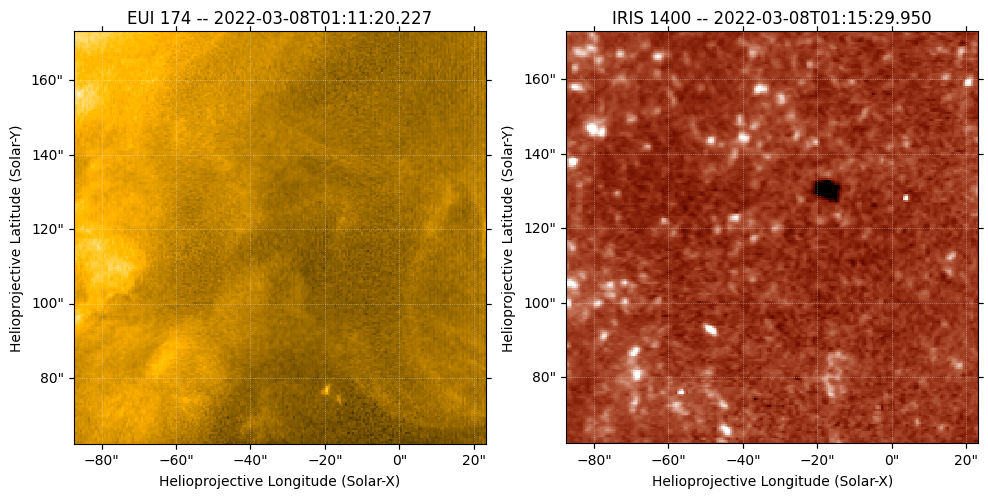

In [70]:
i = 340

eui_map = eui_shifted_seq[i]
iris_map = iris_derotated_seq[i]

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121, projection=eui_map)
eui_map.plot(axes=ax1, norm=eui_norm, title=f'EUI 174 -- {eui_seq[i].date}')

ax2 = fig.add_subplot(122, projection=iris_map, sharex=ax1, sharey=ax1)
iris_map.plot(axes=ax2, norm=iris_norm, title=f'IRIS 1400 -- {matched_iris_seq[i].date}')

ax1.set_xlim(25, 250)
ax1.set_ylim(25, 250)

plt.tight_layout()

### Choose second region of interest (ROI 2)